In [1]:
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xfeat
from xfeat.cat_encoder import TargetEncoder
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna.integration.lightgbm as lgb

In [2]:
all_new = pd.read_csv('data/feature_df_agg_svd132.csv')
#bert_embeded = pd.read_csv('data/bert_embeded.csv')
#bert_svd256 = pd.read_csv("data/bert_svd256.csv")
#ALBERT_svd256 = pd.read_csv("data/ALBERT_svd256.csv")
ROBERTA_svd256 = pd.read_csv("data/ROBERTA_svd256.csv")
#XLMROBERTA_svd256 = pd.read_csv("data/XLMROBERTA_svd256.csv")
#tfidf_svd_raw_64 = pd.read_csv("data/tfidf_svd_raw_64.csv")
tfidf_svd_raw_64 = pd.read_csv("data/tfidf_svd_raw_128_2gram.csv")
mfw_df = pd.read_csv('data/mfw.csv')
miw_df = pd.read_csv('data/miw.csv')

In [3]:
#all_new = pd.merge(all_new, bert_embeded, on="id", how="outer")
#all_new = pd.merge(all_new, bert_svd256, on="id", how="outer")
#all_new = pd.merge(all_new, ROBERTA_svd256, on="id", how="outer")
all_new = pd.merge(all_new, tfidf_svd_raw_64, on="id", how="outer")
all_new = pd.merge(all_new, miw_df, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df.drop(["mfw", "sfw"], axis=1), on="id", how="outer")

In [4]:
all_new.head(3)

,id,country,duration,category1,category2,state,data_type,number_of_chars,number_of_words,number_of_sentences,...,wordvec_15,wordvec_16,wordvec_17,wordvec_18,wordvec_19,wordvec_20,wordvec_21,wordvec_22,wordvec_23,wordvec_24
0,0,4,29,12,143,0.0,train,5289,961,40,...,0.10287,-0.17618,-1.28810,-0.598010,0.26131,-1.26190,0.392020,0.59309,-0.55232,0.005087
1,1,16,34,5,108,0.0,train,1144,202,9,...,0.35207,0.16624,-0.91364,0.693300,-0.65035,0.77353,-0.087782,-0.43228,-0.99982,-0.680770
2,2,21,30,7,122,0.0,train,3316,549,25,...,0.35500,0.16465,0.32006,-0.045544,-0.31911,-1.01380,-0.054359,0.20074,0.32061,-0.455840


In [5]:
def run_lgbm_with_te(test, train, target_cols, feature_cols, categorical_cols):
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    test_idx = X_test.index
    train_idx = X_train.index
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=123)
    kfold = KFold(n_splits=10, shuffle=True)
    cfold_test = ConstantFold([range(len(train_idx))], [range(len(train_idx)+1, len(train_idx)+len(test_idx))])
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, X_train["category2"])):
        X_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        X_tr = pd.concat([X_tr, y_tr], axis=1)
        X_tr = X_tr.reset_index(drop=True)

        X_tr = get_te_features(X_tr,
                                   categorical_cols=categorical_cols,
                                   target_col=target_cols,
                                   fold=kfold)
        X_tr = X_tr.drop(target_cols, axis=1)
        
        X_val = X_train.iloc[valid_index]
        y_val = y_train.iloc[valid_index]
        X_val = pd.concat([pd.concat([X_train.iloc[train_index], y_tr], axis=1), X_val],
                            axis=0)
        X_val = X_val.reset_index(drop=True)

        cfold_val = ConstantFold([range(len(train_index))], [range(len(train_index)+1, len(train_index)+len(valid_index))])
        X_val = get_te_features(X_val,
                                categorical_cols=categorical_cols,
                               target_col=target_cols,
                               fold=cfold_val)
        
        X_val = X_val.drop(target_cols, axis=1)
        X_val = X_val.iloc[-len(valid_index):]  # concatしてるのでX_val.iloc[valid_index]としてはダメ
        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=1000,
                          early_stopping_rounds=50,
                          )
        
        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        
        X_test_te = pd.concat([X_train, y_train], axis=1)
        X_test_te = pd.concat([X_test_te, X_test], axis=0)
        X_test_te = X_test_te.reset_index(drop=True)
        X_test_te = get_te_features(X_test_te,
                                   categorical_cols=categorical_cols,
                                   target_col=target_cols,
                                   fold=cfold_test)
        X_test_te = X_test_te.drop(target_cols, axis=1)
        X_test_te = X_test_te.iloc[-len(test_idx):]
        y_pred = model.predict(X_test_te,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=X_test_te.columns, columns=['importance'])
        display(importance)
        importances.append(importance)

    return oof_train, sum(y_preds) / len(y_preds), importances

In [6]:
def run_optuna_lgbm(test, train, target_cols, feature_cols, categorical_cols):
    """
    import optuna.integration.lightgbm as lgb
    """
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    #cv = KFold(n_splits=5, shuffle=True, random_state=0)
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=123)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, X_train["category2"])):
        X_tr = X_train.iloc[train_index]
        X_val = X_train.iloc[valid_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=1000,
                          early_stopping_rounds=10,
                          )
        
        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=X_test.columns, columns=['importance'])
        display(importance)
        importances.append(importance)

    return oof_train, sum(y_preds) / len(y_preds), importances

In [7]:
def get_categorical_cols(base_categorical_cols, feature_cols):
    selected_cols = list(base_categorical_cols)
    for col in base_categorical_cols:
        if col not in feature_cols:
            selected_cols.remove(col)
            print(f"remove: {col}")
        else:
            print(f"chosen: {col}")
    return selected_cols


def get_te_features(df_origin, categorical_cols, target_col, fold):
    df = df_origin.copy()
    encoder = TargetEncoder(
        input_cols=categorical_cols, 
        target_col=target_col,
        fold=fold,
        output_prefix="te_",
        output_suffix=""
        )
    output_df = encoder.fit_transform(df)
    return output_df


# target endordingをtest setに適用するためのクラス
class ConstantFold(KFold):
    def __init__(self, train_idx, val_idx):
        self.train_idx = np.array(train_idx)
        self.val_idx = np.array(val_idx)
        if len(self.train_idx) != len(self.val_idx):
            raise RuntimeError(f"length of 'train_idx'({len(self.train_idx)}) and 'val_idx'({len(self.val_idx)}) must be same.")
        
    def split(self, X):
        whole_idx = pd.DataFrame(X).index
        for tr_idx, val_idx in zip(self.train_idx, self.val_idx):
            tr_idx, val_idx = whole_idx[tr_idx], whole_idx[val_idx]
            yield tr_idx, val_idx

In [8]:
FEATURE_COLS = list(all_new.columns.drop(["id", "state","data_type"]))
print(len(FEATURE_COLS))
CATEGORICAL_COLS = [
    "country",
    "category1",
    "category2",
    "country+category1",
    "country+category2",
    "category1+category2",
]


1053


In [9]:
TARGET_COLS = ["state"]
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }

In [10]:
test_set = all_new[all_new["data_type"] == "test"]
train_set = all_new[all_new["data_type"] == "train"]
#_oof, _preds, importances = run_optuna_lgbm(test_set, train_set, target_cols, feature_cols, categorical_cols)

In [11]:
def feature_selection(test_set, train_set, target_cols, feature_cols, categorical_cols, num_features):
    _, _, importances = run_optuna_lgbm(test_set, train_set, target_cols, feature_cols, categorical_cols)
    features_set = set()
    for importance in importances:
        imp_df = importance.sort_values("importance")
        feature_selected = list(imp_df[-num_features:].index)
        features_set |= set(feature_selected)
    return list(features_set), importances

In [12]:
def recursive_feature_selection(test_set, train_set, target_cols, feature_cols, categorical_cols):
    worst_exist = True
    while worst_exist == True:
        oof, preds, importances = run_optuna_lgbm(test_set, train_set, target_cols, feature_cols, categorical_cols)
        #oof, preds, importances = run_lgbm_with_te(test_set, train_set, target_cols, feature_cols, categorical_cols)
        worst_features = check_worst_features(importances, 5)
        if worst_features == set():
            worst_exist = False
        else:
            for feature in worst_features:
                feature_cols.remove(feature)
                for category in categorical_cols:
                    if category not in feature_cols:
                        print(category)
                        categorical_cols.remove(category)
    return oof, preds, importances, feature_cols

In [13]:
def check_worst_features(importances, imp_threshold):
    worst_feature_set = set(importances[0].index)
    for n, importance in enumerate(importances):
        df = importance.sort_values('importance')
        worst_features = set(df[df["importance"] < imp_threshold].index)
        worst_feature_set &= worst_features
    return worst_feature_set

In [14]:
"""
feature_selected, importances = feature_selection(test_set, train_set, TARGET_COLS, FEATURE_COLS, CATEGORICAL_COLS, 150)
categorical_selected = get_categorical_cols(CATEGORICAL_COLS, feature_selected)
feature_selected
"""

'\nfeature_selected, importances = feature_selection(test_set, train_set, TARGET_COLS, FEATURE_COLS, CATEGORICAL_COLS, 150)\ncategorical_selected = get_categorical_cols(CATEGORICAL_COLS, feature_selected)\nfeature_selected\n'

In [15]:
#oof, preds, importances = run_lgbm_with_te(test_set, train_set, TARGET_COLS, FEATURE_COLS, CATEGORICAL_COLS)
#oof, preds, importances = run_optuna_lgbm(test_data, train_data, TARGET_COLS, FEATURE_COLS, CATEGORICAL_COLS)
_oof, _preds, _importances, feature_cols = recursive_feature_selection(test_set, train_set, TARGET_COLS, FEATURE_COLS, CATEGORICAL_COLS)
feature_cols

/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 12:28:18,544] A new study created in memory with name: no-name-f025d504-47f7-46c3-9fa1-3116d778f0c1
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.408861:  14%|#4        | 1/7 [00:02<00:15,  2.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402858:  29%|##8       | 2/7 [00:04<00:12,  2.41s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402858:  43%|####2     | 3/7 [00:07<00:09,  2.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402858:  57%|#####7    | 4/7 [00:09<00:07,  2.33s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402858:  71%|#######1  | 5/7 [00:11<00:04,  2.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402858:  86%|########5 | 6/7 [00:13<00:02,  2.30s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.402858:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401952:   5%|5         | 1/20 [00:03<00:57,  3.01s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401952:  10%|#         | 2/20 [00:05<00:51,  2.85s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401952:  15%|#5        | 3/20 [00:07<00:44,  2.64s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401952:  20%|##        | 4/20 [00:11<00:46,  2.88s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401952:  25%|##5       | 5/20 [00:14<00:43,  2.92s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401952:  30%|###       | 6/20 [00:15<00:35,  2.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  35%|###5      | 7/20 [00:18<00:33,  2.56s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  40%|####      | 8/20 [00:20<00:30,  2.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  45%|####5     | 9/20 [00:23<00:27,  2.50s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  50%|#####     | 10/20 [00:25<00:24,  2.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  55%|#####5    | 11/20 [00:27<00:20,  2.26s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  60%|######    | 12/20 [00:29<00:18,  2.34s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  65%|######5   | 13/20 [00:32<00:17,  2.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  70%|#######   | 14/20 [00:35<00:15,  2.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  75%|#######5  | 15/20 [00:38<00:12,  2.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  80%|########  | 16/20 [00:40<00:09,  2.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  85%|########5 | 17/20 [00:43<00:07,  2.64s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  90%|######### | 18/20 [00:45<00:05,  2.55s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401540:  95%|#########5| 19/20 [00:48<00:02,  2.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  10%|#         | 1/10 [00:02<00:19,  2.13s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  20%|##        | 2/10 [00:04<00:18,  2.26s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  30%|###       | 3/10 [00:06<00:15,  2.16s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  40%|####      | 4/10 [00:08<00:13,  2.19s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  50%|#####     | 5/10 [00:11<00:11,  2.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  60%|######    | 6/10 [00:14<00:09,  2.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  70%|#######   | 7/10 [00:16<00:06,  2.27s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  80%|########  | 8/10 [00:18<00:04,  2.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401540:  90%|######### | 9/10 [00:20<00:02,  2.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401540:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401540:  33%|###3      | 1/3 [00:02<00:05,  2.67s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401540:  67%|######6   | 2/3 [00:05<00:02,  2.65s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:   5%|5         | 1/20 [00:02<00:53,  2.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:  10%|#         | 2/20 [00:05<00:50,  2.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:  15%|#5        | 3/20 [00:08<00:47,  2.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:  20%|##        | 4/20 [00:11<00:44,  2.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:  25%|##5       | 5/20 [00:13<00:41,  2.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:  30%|###       | 6/20 [00:16<00:39,  2.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401540:  35%|###5      | 7/20 [00:19<00:36,  2.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  40%|####      | 8/20 [00:22<00:33,  2.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  45%|####5     | 9/20 [00:25<00:30,  2.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  50%|#####     | 10/20 [00:27<00:27,  2.73s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  55%|#####5    | 11/20 [00:30<00:24,  2.69s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  60%|######    | 12/20 [00:33<00:21,  2.72s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  65%|######5   | 13/20 [00:35<00:19,  2.73s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  70%|#######   | 14/20 [00:38<00:16,  2.74s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  75%|#######5  | 15/20 [00:41<00:13,  2.75s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401539:  80%|########  | 16/20 [00:44<00:10,  2.74s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398742:  85%|########5 | 17/20 [00:46<00:08,  2.69s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398742:  90%|######### | 18/20 [00:49<00:05,  2.70s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398742:  95%|#########5| 19/20 [00:52<00:02,  2.72s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398742:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398742:  20%|##        | 1/5 [00:02<00:11,  2.97s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398742:  40%|####      | 2/5 [00:05<00:08,  2.91s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398742:  60%|######    | 3/5 [00:08<00:05,  2.89s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398742:  80%|########  | 4/5 [00:10<00:02,  2.74s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

min_data_in_leaf, val_score: 0.398742: 100%|##########| 5/5 [00:13<00:00,  2.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,importance
country,3
duration,3
category1,3
category2,53
number_of_chars,0
...,...
wordvec_20,6
wordvec_21,12
wordvec_22,6
wordvec_23,10


[I 2021-01-29 12:31:05,827] A new study created in memory with name: no-name-f93fe073-afbd-4094-8fd9-7b901ed833e1
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425616:  14%|#4        | 1/7 [00:02<00:13,  2.25s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425616:  29%|##8       | 2/7 [00:04<00:11,  2.29s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419309:  43%|####2     | 3/7 [00:06<00:08,  2.25s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419309:  57%|#####7    | 4/7 [00:08<00:06,  2.19s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419309:  71%|#######1  | 5/7 [00:11<00:04,  2.20s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419309:  86%|########5 | 6/7 [00:13<00:02,  2.30s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:   5%|5         | 1/20 [00:01<00:33,  1.78s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  10%|#         | 2/20 [00:04<00:36,  2.02s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  15%|#5        | 3/20 [00:06<00:35,  2.12s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  20%|##        | 4/20 [00:10<00:40,  2.54s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  25%|##5       | 5/20 [00:12<00:35,  2.35s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  30%|###       | 6/20 [00:15<00:36,  2.64s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  35%|###5      | 7/20 [00:17<00:31,  2.41s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  40%|####      | 8/20 [00:20<00:30,  2.58s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  45%|####5     | 9/20 [00:22<00:27,  2.46s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  50%|#####     | 10/20 [00:25<00:26,  2.65s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  55%|#####5    | 11/20 [00:27<00:22,  2.49s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  60%|######    | 12/20 [00:30<00:21,  2.66s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  65%|######5   | 13/20 [00:33<00:18,  2.71s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  70%|#######   | 14/20 [00:35<00:14,  2.50s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  75%|#######5  | 15/20 [00:37<00:11,  2.34s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  80%|########  | 16/20 [00:39<00:09,  2.32s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  85%|########5 | 17/20 [00:41<00:06,  2.20s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  90%|######### | 18/20 [00:43<00:04,  2.11s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419309:  95%|#########5| 19/20 [00:45<00:02,  2.02s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  10%|#         | 1/10 [00:02<00:18,  2.08s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  20%|##        | 2/10 [00:04<00:16,  2.08s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  30%|###       | 3/10 [00:06<00:14,  2.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  40%|####      | 4/10 [00:07<00:11,  2.00s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  50%|#####     | 5/10 [00:09<00:10,  2.00s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  60%|######    | 6/10 [00:11<00:07,  1.96s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  70%|#######   | 7/10 [00:13<00:05,  1.99s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  80%|########  | 8/10 [00:15<00:03,  1.97s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419309:  90%|######### | 9/10 [00:17<00:02,  2.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419309:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419309:  17%|#6        | 1/6 [00:02<00:10,  2.04s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419309:  33%|###3      | 2/6 [00:03<00:08,  2.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419309:  50%|#####     | 3/6 [00:06<00:06,  2.03s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419309:  67%|######6   | 4/6 [00:08<00:04,  2.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419309:  83%|########3 | 5/6 [00:09<00:01,  1.98s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:   5%|5         | 1/20 [00:01<00:37,  1.96s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  10%|#         | 2/20 [00:04<00:37,  2.06s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  15%|#5        | 3/20 [00:06<00:36,  2.14s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  20%|##        | 4/20 [00:08<00:35,  2.19s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  25%|##5       | 5/20 [00:11<00:33,  2.23s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  30%|###       | 6/20 [00:13<00:31,  2.25s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  35%|###5      | 7/20 [00:15<00:29,  2.28s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  40%|####      | 8/20 [00:18<00:27,  2.29s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  45%|####5     | 9/20 [00:20<00:25,  2.29s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  50%|#####     | 10/20 [00:22<00:23,  2.30s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  55%|#####5    | 11/20 [00:25<00:20,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  60%|######    | 12/20 [00:27<00:18,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  65%|######5   | 13/20 [00:29<00:16,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  70%|#######   | 14/20 [00:32<00:13,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  75%|#######5  | 15/20 [00:34<00:11,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  80%|########  | 16/20 [00:36<00:09,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  85%|########5 | 17/20 [00:38<00:06,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  90%|######### | 18/20 [00:41<00:04,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419309:  95%|#########5| 19/20 [00:43<00:02,  2.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419309:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419309:  20%|##        | 1/5 [00:02<00:08,  2.05s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419309:  40%|####      | 2/5 [00:04<00:06,  2.09s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419309:  60%|######    | 3/5 [00:06<00:04,  2.20s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419309:  80%|########  | 4/5 [00:08<00:02,  2.18s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185598
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419309: 100%|##########| 5/5 [00:10<00:00,  2.17s/it]


,importance
country,4
duration,2
category1,1
category2,88
number_of_chars,0
...,...
wordvec_20,3
wordvec_21,2
wordvec_22,2
wordvec_23,7


[I 2021-01-29 12:33:38,719] A new study created in memory with name: no-name-6867b181-7ae0-4f3e-a2f5-b4059fcbbc3e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.381629:  14%|#4        | 1/7 [00:02<00:13,  2.19s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.381629:  29%|##8       | 2/7 [00:04<00:10,  2.19s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.381629:  43%|####2     | 3/7 [00:07<00:09,  2.38s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.381629:  57%|#####7    | 4/7 [00:09<00:06,  2.33s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.381629:  71%|#######1  | 5/7 [00:12<00:05,  2.51s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.381629:  86%|########5 | 6/7 [00:15<00:02,  2.61s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:   5%|5         | 1/20 [00:02<00:43,  2.31s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  10%|#         | 2/20 [00:04<00:43,  2.40s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  15%|#5        | 3/20 [00:06<00:37,  2.19s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  20%|##        | 4/20 [00:10<00:42,  2.64s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  25%|##5       | 5/20 [00:13<00:42,  2.85s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  30%|###       | 6/20 [00:16<00:40,  2.88s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  35%|###5      | 7/20 [00:19<00:38,  2.96s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  40%|####      | 8/20 [00:21<00:32,  2.68s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  45%|####5     | 9/20 [00:24<00:30,  2.75s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  50%|#####     | 10/20 [00:27<00:28,  2.86s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  55%|#####5    | 11/20 [00:30<00:24,  2.73s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  60%|######    | 12/20 [00:33<00:23,  2.97s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  65%|######5   | 13/20 [00:35<00:18,  2.70s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  70%|#######   | 14/20 [00:38<00:16,  2.72s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  75%|#######5  | 15/20 [00:41<00:13,  2.67s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  80%|########  | 16/20 [00:43<00:09,  2.50s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  85%|########5 | 17/20 [00:45<00:07,  2.45s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  90%|######### | 18/20 [00:47<00:04,  2.43s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381629:  95%|#########5| 19/20 [00:50<00:02,  2.46s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  10%|#         | 1/10 [00:01<00:16,  1.87s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  20%|##        | 2/10 [00:03<00:15,  1.92s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  30%|###       | 3/10 [00:05<00:13,  1.95s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  40%|####      | 4/10 [00:07<00:11,  1.90s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  50%|#####     | 5/10 [00:09<00:09,  1.97s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  60%|######    | 6/10 [00:11<00:07,  1.98s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  70%|#######   | 7/10 [00:14<00:06,  2.08s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  80%|########  | 8/10 [00:16<00:04,  2.03s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381629:  90%|######### | 9/10 [00:18<00:01,  2.00s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.381629:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.381629:  33%|###3      | 1/3 [00:02<00:04,  2.13s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.381629:  67%|######6   | 2/3 [00:04<00:02,  2.14s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381629:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:   5%|5         | 1/20 [00:02<00:43,  2.28s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  10%|#         | 2/20 [00:04<00:41,  2.28s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  15%|#5        | 3/20 [00:06<00:38,  2.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  20%|##        | 4/20 [00:09<00:36,  2.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  25%|##5       | 5/20 [00:11<00:34,  2.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  30%|###       | 6/20 [00:13<00:32,  2.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  35%|###5      | 7/20 [00:16<00:29,  2.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  40%|####      | 8/20 [00:18<00:27,  2.30s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  45%|####5     | 9/20 [00:20<00:25,  2.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  50%|#####     | 10/20 [00:22<00:22,  2.22s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  55%|#####5    | 11/20 [00:24<00:19,  2.20s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  60%|######    | 12/20 [00:27<00:17,  2.23s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  65%|######5   | 13/20 [00:29<00:15,  2.25s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  70%|#######   | 14/20 [00:31<00:13,  2.26s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  75%|#######5  | 15/20 [00:34<00:11,  2.27s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  80%|########  | 16/20 [00:36<00:09,  2.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  85%|########5 | 17/20 [00:38<00:07,  2.39s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  90%|######### | 18/20 [00:41<00:04,  2.37s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381140:  95%|#########5| 19/20 [00:43<00:02,  2.35s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381140:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381140:  20%|##        | 1/5 [00:02<00:10,  2.70s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381140:  40%|####      | 2/5 [00:04<00:07,  2.57s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381140:  60%|######    | 3/5 [00:07<00:04,  2.48s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381140:  80%|########  | 4/5 [00:09<00:02,  2.40s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185309
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379729: 100%|##########| 5/5 [00:11<00:00,  2.39s/it]


,importance
country,5
duration,3
category1,1
category2,110
number_of_chars,2
...,...
wordvec_20,2
wordvec_21,9
wordvec_22,3
wordvec_23,3


[I 2021-01-29 12:36:14,312] A new study created in memory with name: no-name-b34f8513-7a79-41fc-b25c-6037e2feec28
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399338:  14%|#4        | 1/7 [00:03<00:22,  3.75s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399338:  29%|##8       | 2/7 [00:06<00:16,  3.35s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399338:  43%|####2     | 3/7 [00:08<00:11,  2.98s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399338:  57%|#####7    | 4/7 [00:10<00:08,  2.82s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399338:  71%|#######1  | 5/7 [00:13<00:05,  2.67s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399338:  86%|########5 | 6/7 [00:15<00:02,  2.74s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:   5%|5         | 1/20 [00:03<01:10,  3.73s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  10%|#         | 2/20 [00:08<01:13,  4.08s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  15%|#5        | 3/20 [00:13<01:12,  4.27s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  20%|##        | 4/20 [00:15<00:56,  3.53s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  25%|##5       | 5/20 [00:16<00:45,  3.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  30%|###       | 6/20 [00:20<00:45,  3.26s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.399338:  35%|###5      | 7/20 [00:26<00:51,  3.97s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  40%|####      | 8/20 [00:29<00:45,  3.82s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.399338:  45%|####5     | 9/20 [00:35<00:47,  4.35s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  50%|#####     | 10/20 [00:40<00:45,  4.53s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  55%|#####5    | 11/20 [00:43<00:36,  4.08s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  60%|######    | 12/20 [00:47<00:33,  4.15s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  65%|######5   | 13/20 [00:52<00:30,  4.41s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  70%|#######   | 14/20 [00:55<00:23,  3.92s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  75%|#######5  | 15/20 [00:59<00:19,  3.95s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  80%|########  | 16/20 [01:04<00:17,  4.35s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  85%|########5 | 17/20 [01:09<00:13,  4.48s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  90%|######### | 18/20 [01:13<00:08,  4.35s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399338:  95%|#########5| 19/20 [01:16<00:03,  3.77s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  10%|#         | 1/10 [00:02<00:21,  2.34s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  20%|##        | 2/10 [00:05<00:21,  2.65s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  30%|###       | 3/10 [00:08<00:18,  2.65s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  40%|####      | 4/10 [00:11<00:16,  2.75s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  50%|#####     | 5/10 [00:14<00:14,  2.87s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  60%|######    | 6/10 [00:17<00:11,  2.96s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  70%|#######   | 7/10 [00:19<00:08,  2.75s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  80%|########  | 8/10 [00:22<00:05,  2.69s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399338:  90%|######### | 9/10 [00:25<00:02,  2.79s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399338:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399338:  33%|###3      | 1/3 [00:03<00:06,  3.00s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399338:  67%|######6   | 2/3 [00:05<00:02,  2.95s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399338:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399338:   5%|5         | 1/20 [00:02<00:54,  2.87s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399338:  10%|#         | 2/20 [00:06<00:53,  2.98s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399338:  15%|#5        | 3/20 [00:08<00:49,  2.94s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399338:  20%|##        | 4/20 [00:11<00:45,  2.86s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399338:  25%|##5       | 5/20 [00:14<00:42,  2.80s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399338:  30%|###       | 6/20 [00:17<00:41,  2.97s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  35%|###5      | 7/20 [00:21<00:42,  3.27s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  40%|####      | 8/20 [00:25<00:41,  3.50s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  45%|####5     | 9/20 [00:29<00:39,  3.60s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  50%|#####     | 10/20 [00:33<00:37,  3.71s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  55%|#####5    | 11/20 [00:37<00:34,  3.79s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  60%|######    | 12/20 [00:41<00:30,  3.85s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  65%|######5   | 13/20 [00:45<00:27,  3.91s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  70%|#######   | 14/20 [00:49<00:23,  3.98s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  75%|#######5  | 15/20 [00:53<00:19,  3.97s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  80%|########  | 16/20 [00:57<00:16,  4.03s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  85%|########5 | 17/20 [01:01<00:12,  4.03s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  90%|######### | 18/20 [01:05<00:08,  4.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399337:  95%|#########5| 19/20 [01:09<00:04,  4.03s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399337:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399337:  20%|##        | 1/5 [00:03<00:14,  3.57s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399337:  40%|####      | 2/5 [00:06<00:10,  3.46s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399337:  60%|######    | 3/5 [00:10<00:06,  3.39s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399337:  80%|########  | 4/5 [00:12<00:03,  3.19s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186060
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399337: 100%|##########| 5/5 [00:15<00:00,  3.09s/it]


,importance
country,5
duration,0
category1,0
category2,161
number_of_chars,0
...,...
wordvec_20,5
wordvec_21,9
wordvec_22,4
wordvec_23,6


[I 2021-01-29 12:39:57,668] A new study created in memory with name: no-name-6e556a80-1ffb-48a7-9786-2a40db0f03e0
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.407334:  14%|#4        | 1/7 [00:02<00:15,  2.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.407334:  29%|##8       | 2/7 [00:04<00:12,  2.50s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.407334:  43%|####2     | 3/7 [00:08<00:11,  2.76s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.407334:  57%|#####7    | 4/7 [00:10<00:07,  2.55s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.407334:  71%|#######1  | 5/7 [00:13<00:05,  2.61s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.403930:  86%|########5 | 6/7 [00:15<00:02,  2.56s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:   5%|5         | 1/20 [00:02<00:41,  2.18s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  10%|#         | 2/20 [00:05<00:42,  2.38s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  15%|#5        | 3/20 [00:08<00:47,  2.78s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  20%|##        | 4/20 [00:12<00:49,  3.09s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  25%|##5       | 5/20 [00:14<00:41,  2.74s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  30%|###       | 6/20 [00:17<00:40,  2.91s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  35%|###5      | 7/20 [00:20<00:38,  3.00s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  40%|####      | 8/20 [00:23<00:35,  2.94s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.403930:  45%|####5     | 9/20 [00:27<00:35,  3.19s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  50%|#####     | 10/20 [00:31<00:33,  3.34s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  55%|#####5    | 11/20 [00:33<00:27,  3.03s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  60%|######    | 12/20 [00:36<00:24,  3.09s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  65%|######5   | 13/20 [00:39<00:20,  2.99s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  70%|#######   | 14/20 [00:42<00:17,  2.90s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  75%|#######5  | 15/20 [00:45<00:15,  3.01s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  80%|########  | 16/20 [00:48<00:11,  2.99s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  85%|########5 | 17/20 [00:51<00:08,  2.88s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  90%|######### | 18/20 [00:55<00:06,  3.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403930:  95%|#########5| 19/20 [00:58<00:03,  3.18s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  10%|#         | 1/10 [00:02<00:20,  2.25s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  20%|##        | 2/10 [00:04<00:18,  2.29s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  30%|###       | 3/10 [00:06<00:15,  2.26s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  40%|####      | 4/10 [00:09<00:13,  2.26s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  50%|#####     | 5/10 [00:11<00:10,  2.17s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  60%|######    | 6/10 [00:13<00:08,  2.16s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  70%|#######   | 7/10 [00:15<00:06,  2.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  80%|########  | 8/10 [00:17<00:04,  2.09s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.403930:  90%|######### | 9/10 [00:19<00:02,  2.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.403930:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.403930:  17%|#6        | 1/6 [00:02<00:11,  2.23s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.403930:  33%|###3      | 2/6 [00:04<00:08,  2.18s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.403930:  50%|#####     | 3/6 [00:06<00:06,  2.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.403930:  67%|######6   | 4/6 [00:08<00:04,  2.16s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.403930:  83%|########3 | 5/6 [00:10<00:02,  2.19s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:   5%|5         | 1/20 [00:03<00:59,  3.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  10%|#         | 2/20 [00:06<00:55,  3.09s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  15%|#5        | 3/20 [00:08<00:50,  2.94s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  20%|##        | 4/20 [00:11<00:44,  2.78s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  25%|##5       | 5/20 [00:14<00:42,  2.81s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  30%|###       | 6/20 [00:16<00:37,  2.67s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  35%|###5      | 7/20 [00:18<00:32,  2.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  40%|####      | 8/20 [00:20<00:29,  2.46s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  45%|####5     | 9/20 [00:23<00:26,  2.43s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  50%|#####     | 10/20 [00:25<00:23,  2.39s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.403930:  55%|#####5    | 11/20 [00:27<00:21,  2.39s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402346:  60%|######    | 12/20 [00:30<00:19,  2.45s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402345:  65%|######5   | 13/20 [00:33<00:17,  2.53s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402345:  70%|#######   | 14/20 [00:35<00:15,  2.56s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402345:  75%|#######5  | 15/20 [00:38<00:12,  2.54s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402345:  80%|########  | 16/20 [00:40<00:10,  2.56s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402345:  85%|########5 | 17/20 [00:43<00:07,  2.59s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402345:  90%|######### | 18/20 [00:46<00:05,  2.61s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.402345:  95%|#########5| 19/20 [00:48<00:02,  2.61s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.402345:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.402345:  20%|##        | 1/5 [00:02<00:10,  2.63s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.402345:  40%|####      | 2/5 [00:05<00:07,  2.58s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.402345:  60%|######    | 3/5 [00:07<00:05,  2.58s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.402345:  80%|########  | 4/5 [00:10<00:02,  2.68s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1052
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.402345: 100%|##########| 5/5 [00:12<00:00,  2.56s/it]


,importance
country,8
duration,0
category1,0
category2,119
number_of_chars,0
...,...
wordvec_20,2
wordvec_21,4
wordvec_22,2
wordvec_23,5


[I 2021-01-29 12:42:57,161] A new study created in memory with name: no-name-bfc574b9-2c20-4a1b-a4aa-08a2e1dde479
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.413335:  14%|#4        | 1/7 [00:01<00:11,  1.97s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.410853:  29%|##8       | 2/7 [00:04<00:10,  2.04s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.410853:  43%|####2     | 3/7 [00:06<00:08,  2.20s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.410853:  57%|#####7    | 4/7 [00:09<00:06,  2.23s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.410853:  71%|#######1  | 5/7 [00:11<00:04,  2.41s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.410853:  86%|########5 | 6/7 [00:14<00:02,  2.50s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:   5%|5         | 1/20 [00:02<00:54,  2.86s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  10%|#         | 2/20 [00:05<00:52,  2.93s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  15%|#5        | 3/20 [00:08<00:46,  2.75s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  20%|##        | 4/20 [00:11<00:47,  2.97s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  25%|##5       | 5/20 [00:13<00:39,  2.64s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  30%|###       | 6/20 [00:17<00:41,  2.96s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  35%|###5      | 7/20 [00:20<00:38,  2.97s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  40%|####      | 8/20 [00:22<00:33,  2.80s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  45%|####5     | 9/20 [00:25<00:31,  2.86s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  50%|#####     | 10/20 [00:28<00:27,  2.78s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  55%|#####5    | 11/20 [00:30<00:22,  2.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  60%|######    | 12/20 [00:33<00:21,  2.65s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  65%|######5   | 13/20 [00:35<00:18,  2.67s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  70%|#######   | 14/20 [00:37<00:14,  2.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  75%|#######5  | 15/20 [00:41<00:13,  2.73s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  80%|########  | 16/20 [00:44<00:11,  2.81s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  85%|########5 | 17/20 [00:46<00:08,  2.77s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  90%|######### | 18/20 [00:49<00:05,  2.78s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.410853:  95%|#########5| 19/20 [00:53<00:02,  2.96s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  10%|#         | 1/10 [00:02<00:19,  2.13s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  20%|##        | 2/10 [00:04<00:16,  2.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  30%|###       | 3/10 [00:06<00:14,  2.10s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  40%|####      | 4/10 [00:08<00:13,  2.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  50%|#####     | 5/10 [00:10<00:10,  2.12s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  60%|######    | 6/10 [00:12<00:08,  2.09s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  70%|#######   | 7/10 [00:14<00:06,  2.13s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  80%|########  | 8/10 [00:17<00:04,  2.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.410853:  90%|######### | 9/10 [00:19<00:02,  2.19s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.410853:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.410853:  17%|#6        | 1/6 [00:02<00:12,  2.59s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.410853:  33%|###3      | 2/6 [00:05<00:10,  2.58s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.410853:  50%|#####     | 3/6 [00:09<00:09,  3.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.410853:  67%|######6   | 4/6 [00:12<00:06,  3.09s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.410853:  83%|########3 | 5/6 [00:15<00:03,  3.22s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.410853:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.410853:   5%|5         | 1/20 [00:02<00:46,  2.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.410853:  10%|#         | 2/20 [00:04<00:44,  2.47s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  15%|#5        | 3/20 [00:07<00:42,  2.50s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  20%|##        | 4/20 [00:09<00:38,  2.40s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  25%|##5       | 5/20 [00:11<00:35,  2.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  30%|###       | 6/20 [00:14<00:32,  2.33s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  35%|###5      | 7/20 [00:16<00:30,  2.32s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  40%|####      | 8/20 [00:18<00:27,  2.31s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  45%|####5     | 9/20 [00:21<00:25,  2.34s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  50%|#####     | 10/20 [00:23<00:23,  2.32s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  55%|#####5    | 11/20 [00:25<00:20,  2.31s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  60%|######    | 12/20 [00:28<00:18,  2.31s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  65%|######5   | 13/20 [00:30<00:16,  2.30s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  70%|#######   | 14/20 [00:32<00:13,  2.30s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  75%|#######5  | 15/20 [00:35<00:11,  2.32s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  80%|########  | 16/20 [00:37<00:09,  2.32s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  85%|########5 | 17/20 [00:39<00:06,  2.30s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  90%|######### | 18/20 [00:41<00:04,  2.29s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408923:  95%|#########5| 19/20 [00:44<00:02,  2.29s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408923:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408923:  20%|##        | 1/5 [00:02<00:08,  2.23s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408923:  40%|####      | 2/5 [00:04<00:06,  2.23s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408923:  60%|######    | 3/5 [00:06<00:04,  2.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408923:  80%|########  | 4/5 [00:09<00:02,  2.27s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185520
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408923: 100%|##########| 5/5 [00:11<00:00,  2.27s/it]


,importance
country,5
duration,2
category1,3
category2,84
number_of_chars,1
...,...
wordvec_20,2
wordvec_21,3
wordvec_22,1
wordvec_23,1


[I 2021-01-29 12:45:49,169] A new study created in memory with name: no-name-f1df0253-bd81-420d-9720-cff3c977d754
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403376:  14%|#4        | 1/7 [00:02<00:13,  2.29s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.401740:  29%|##8       | 2/7 [00:05<00:12,  2.43s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394609:  43%|####2     | 3/7 [00:07<00:09,  2.37s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.393000:  57%|#####7    | 4/7 [00:09<00:06,  2.29s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.393000:  71%|#######1  | 5/7 [00:11<00:04,  2.25s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.393000:  86%|########5 | 6/7 [00:14<00:02,  2.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:   5%|5         | 1/20 [00:03<00:59,  3.12s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  10%|#         | 2/20 [00:05<00:49,  2.77s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  15%|#5        | 3/20 [00:07<00:46,  2.76s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  20%|##        | 4/20 [00:09<00:39,  2.47s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  25%|##5       | 5/20 [00:12<00:40,  2.70s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  30%|###       | 6/20 [00:15<00:37,  2.67s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  35%|###5      | 7/20 [00:18<00:36,  2.80s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  40%|####      | 8/20 [00:20<00:30,  2.58s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  45%|####5     | 9/20 [00:22<00:27,  2.50s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  50%|#####     | 10/20 [00:25<00:26,  2.62s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  55%|#####5    | 11/20 [00:28<00:25,  2.79s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  60%|######    | 12/20 [00:32<00:23,  2.98s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  65%|######5   | 13/20 [00:34<00:19,  2.81s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  70%|#######   | 14/20 [00:37<00:16,  2.83s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  75%|#######5  | 15/20 [00:39<00:12,  2.59s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  80%|########  | 16/20 [00:42<00:10,  2.72s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  85%|########5 | 17/20 [00:45<00:08,  2.70s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  90%|######### | 18/20 [00:48<00:05,  2.77s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.393000:  95%|#########5| 19/20 [00:51<00:02,  2.76s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  10%|#         | 1/10 [00:01<00:16,  1.83s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  20%|##        | 2/10 [00:03<00:15,  1.89s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  30%|###       | 3/10 [00:05<00:13,  1.93s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  40%|####      | 4/10 [00:07<00:11,  1.90s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  50%|#####     | 5/10 [00:09<00:09,  1.90s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  60%|######    | 6/10 [00:11<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  70%|#######   | 7/10 [00:13<00:05,  1.94s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  80%|########  | 8/10 [00:15<00:04,  2.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393000:  90%|######### | 9/10 [00:17<00:02,  2.01s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.393000:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389964:  33%|###3      | 1/3 [00:02<00:04,  2.14s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389964:  67%|######6   | 2/3 [00:04<00:02,  2.17s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:   5%|5         | 1/20 [00:02<00:39,  2.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  10%|#         | 2/20 [00:04<00:37,  2.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  15%|#5        | 3/20 [00:06<00:34,  2.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  20%|##        | 4/20 [00:08<00:33,  2.07s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  25%|##5       | 5/20 [00:10<00:30,  2.07s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  30%|###       | 6/20 [00:12<00:28,  2.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  35%|###5      | 7/20 [00:14<00:27,  2.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  40%|####      | 8/20 [00:16<00:25,  2.12s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  45%|####5     | 9/20 [00:19<00:23,  2.17s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  50%|#####     | 10/20 [00:21<00:22,  2.20s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  55%|#####5    | 11/20 [00:23<00:20,  2.23s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  60%|######    | 12/20 [00:25<00:17,  2.24s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  65%|######5   | 13/20 [00:28<00:15,  2.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  70%|#######   | 14/20 [00:30<00:13,  2.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  75%|#######5  | 15/20 [00:32<00:11,  2.28s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  80%|########  | 16/20 [00:35<00:09,  2.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  85%|########5 | 17/20 [00:37<00:06,  2.28s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  90%|######### | 18/20 [00:39<00:04,  2.30s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389964:  95%|#########5| 19/20 [00:41<00:02,  2.30s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389964:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389964:  20%|##        | 1/5 [00:02<00:08,  2.11s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389964:  40%|####      | 2/5 [00:04<00:06,  2.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389964:  60%|######    | 3/5 [00:06<00:04,  2.09s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389964:  80%|########  | 4/5 [00:08<00:02,  2.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 1051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389964: 100%|##########| 5/5 [00:10<00:00,  2.06s/it]


,importance
country,6
duration,2
category1,4
category2,107
number_of_chars,0
...,...
wordvec_20,2
wordvec_21,6
wordvec_22,4
wordvec_23,3


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 12:48:23,414] A new study created in memory with name: no-name-3b1753e7-e5b8-4261-9e6b-f54bf5ed103b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

category1
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402954:  14%|#4        | 1/7 [00:00<00:04,  1.36it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402954:  29%|##8       | 2/7 [00:01<00:03,  1.41it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.402954:  43%|####2     | 3/7 [00:02<00:02,  1.41it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.400833:  57%|#####7    | 4/7 [00:02<00:02,  1.44it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.400833:  71%|#######1  | 5/7 [00:03<00:01,  1.52it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.400833:  86%|########5 | 6/7 [00:04<00:00,  1.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:   5%|5         | 1/20 [00:00<00:08,  2.27it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  10%|#         | 2/20 [00:01<00:11,  1.61it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  15%|#5        | 3/20 [00:02<00:11,  1.45it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  20%|##        | 4/20 [00:03<00:13,  1.22it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  25%|##5       | 5/20 [00:04<00:12,  1.17it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  30%|###       | 6/20 [00:05<00:12,  1.13it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  35%|###5      | 7/20 [00:05<00:10,  1.27it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  40%|####      | 8/20 [00:06<00:09,  1.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  45%|####5     | 9/20 [00:07<00:07,  1.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  50%|#####     | 10/20 [00:07<00:07,  1.42it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  55%|#####5    | 11/20 [00:08<00:07,  1.26it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  60%|######    | 12/20 [00:09<00:05,  1.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  65%|######5   | 13/20 [00:10<00:05,  1.30it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  75%|#######5  | 15/20 [00:11<00:03,  1.48it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.400833:  80%|########  | 16/20 [00:12<00:02,  1.58it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399895:  85%|########5 | 17/20 [00:12<00:01,  1.51it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399895:  90%|######### | 18/20 [00:13<00:01,  1.37it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  10%|#         | 1/10 [00:00<00:04,  1.90it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  20%|##        | 2/10 [00:01<00:04,  1.75it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  30%|###       | 3/10 [00:01<00:04,  1.73it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  40%|####      | 4/10 [00:02<00:03,  1.80it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  50%|#####     | 5/10 [00:02<00:02,  1.80it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  60%|######    | 6/10 [00:03<00:02,  1.59it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  70%|#######   | 7/10 [00:04<00:01,  1.68it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  80%|########  | 8/10 [00:04<00:01,  1.72it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399895:  90%|######### | 9/10 [00:05<00:00,  1.73it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399895:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399895:  33%|###3      | 1/3 [00:00<00:01,  1.71it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.396843:  67%|######6   | 2/3 [00:01<00:00,  1.64it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:   5%|5         | 1/20 [00:00<00:13,  1.38it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  10%|#         | 2/20 [00:01<00:13,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  15%|#5        | 3/20 [00:02<00:12,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  20%|##        | 4/20 [00:03<00:11,  1.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  25%|##5       | 5/20 [00:03<00:11,  1.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  30%|###       | 6/20 [00:04<00:10,  1.36it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  35%|###5      | 7/20 [00:05<00:09,  1.37it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  40%|####      | 8/20 [00:05<00:09,  1.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  45%|####5     | 9/20 [00:06<00:08,  1.31it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  50%|#####     | 10/20 [00:07<00:07,  1.31it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  55%|#####5    | 11/20 [00:08<00:06,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  60%|######    | 12/20 [00:08<00:05,  1.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  65%|######5   | 13/20 [00:09<00:05,  1.36it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  70%|#######   | 14/20 [00:10<00:04,  1.36it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  75%|#######5  | 15/20 [00:11<00:03,  1.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  80%|########  | 16/20 [00:11<00:02,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  85%|########5 | 17/20 [00:12<00:02,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  90%|######### | 18/20 [00:13<00:01,  1.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.396843:  95%|#########5| 19/20 [00:14<00:00,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.396843:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.396843:  20%|##        | 1/5 [00:00<00:03,  1.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.396843:  40%|####      | 2/5 [00:01<00:02,  1.29it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.396843:  60%|######    | 3/5 [00:02<00:01,  1.40it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.396843:  80%|########  | 4/5 [00:02<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83527
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.396843: 100%|##########| 5/5 [00:03<00:00,  1.37it/s]


,importance
country,6
category2,75
number_of_</a>,4
number_of_<h1>,7
number_of_</i>,6
...,...
wordvec_20,6
wordvec_21,7
wordvec_22,2
wordvec_23,5


[I 2021-01-29 12:49:09,472] A new study created in memory with name: no-name-0fdc51a7-bc36-4ada-88ee-d243283bba0d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.427740:  14%|#4        | 1/7 [00:00<00:03,  1.50it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.420139:  29%|##8       | 2/7 [00:01<00:03,  1.50it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.420139:  43%|####2     | 3/7 [00:02<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.420139:  57%|#####7    | 4/7 [00:02<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.420139:  71%|#######1  | 5/7 [00:03<00:01,  1.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.420139:  86%|########5 | 6/7 [00:04<00:00,  1.38it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420139:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420139:  10%|#         | 2/20 [00:00<00:08,  2.10it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420139:  15%|#5        | 3/20 [00:01<00:08,  1.89it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420139:  20%|##        | 4/20 [00:02<00:11,  1.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420139:  25%|##5       | 5/20 [00:03<00:11,  1.31it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420139:  30%|###       | 6/20 [00:04<00:10,  1.30it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419331:  35%|###5      | 7/20 [00:05<00:09,  1.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419331:  40%|####      | 8/20 [00:06<00:09,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419331:  45%|####5     | 9/20 [00:06<00:08,  1.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419331:  50%|#####     | 10/20 [00:07<00:08,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  55%|#####5    | 11/20 [00:08<00:07,  1.23it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  60%|######    | 12/20 [00:09<00:06,  1.31it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  65%|######5   | 13/20 [00:09<00:05,  1.36it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  70%|#######   | 14/20 [00:10<00:04,  1.42it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  75%|#######5  | 15/20 [00:11<00:03,  1.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  80%|########  | 16/20 [00:12<00:03,  1.25it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  85%|########5 | 17/20 [00:12<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  90%|######### | 18/20 [00:13<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415552:  95%|#########5| 19/20 [00:14<00:00,  1.34it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  10%|#         | 1/10 [00:00<00:05,  1.59it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  20%|##        | 2/10 [00:01<00:05,  1.56it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  30%|###       | 3/10 [00:02<00:04,  1.46it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  40%|####      | 4/10 [00:02<00:04,  1.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  50%|#####     | 5/10 [00:03<00:03,  1.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  60%|######    | 6/10 [00:04<00:02,  1.49it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  70%|#######   | 7/10 [00:04<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  80%|########  | 8/10 [00:05<00:01,  1.60it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415552:  90%|######### | 9/10 [00:05<00:00,  1.62it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.415552:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.415552:  33%|###3      | 1/3 [00:00<00:01,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.415552:  67%|######6   | 2/3 [00:01<00:00,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415552:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415552:   5%|5         | 1/20 [00:00<00:13,  1.42it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415552:  10%|#         | 2/20 [00:01<00:13,  1.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415552:  15%|#5        | 3/20 [00:02<00:14,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  20%|##        | 4/20 [00:03<00:14,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  25%|##5       | 5/20 [00:04<00:12,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  30%|###       | 6/20 [00:05<00:11,  1.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  35%|###5      | 7/20 [00:05<00:10,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  40%|####      | 8/20 [00:06<00:09,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  45%|####5     | 9/20 [00:07<00:08,  1.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  50%|#####     | 10/20 [00:08<00:07,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  55%|#####5    | 11/20 [00:09<00:07,  1.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  60%|######    | 12/20 [00:09<00:06,  1.30it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  65%|######5   | 13/20 [00:10<00:05,  1.35it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  70%|#######   | 14/20 [00:11<00:04,  1.33it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  75%|#######5  | 15/20 [00:12<00:03,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  80%|########  | 16/20 [00:13<00:03,  1.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  85%|########5 | 17/20 [00:13<00:02,  1.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  90%|######### | 18/20 [00:14<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.413494:  95%|#########5| 19/20 [00:15<00:00,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.413494:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.413494:  20%|##        | 1/5 [00:00<00:03,  1.07it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.413494:  40%|####      | 2/5 [00:01<00:02,  1.14it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.413494:  60%|######    | 3/5 [00:02<00:01,  1.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.413494:  80%|########  | 4/5 [00:03<00:00,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83538
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.413494: 100%|##########| 5/5 [00:03<00:00,  1.27it/s]


,importance
country,6
category2,83
number_of_</a>,8
number_of_<h1>,12
number_of_</i>,14
...,...
wordvec_20,13
wordvec_21,8
wordvec_22,7
wordvec_23,19


[I 2021-01-29 12:49:58,614] A new study created in memory with name: no-name-d3f3ab16-ac49-4ea3-8ae2-f4e6a3ca3abd
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.386260:  14%|#4        | 1/7 [00:00<00:03,  1.57it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.384881:  29%|##8       | 2/7 [00:01<00:03,  1.59it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.384881:  43%|####2     | 3/7 [00:02<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.384881:  57%|#####7    | 4/7 [00:02<00:02,  1.40it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.384881:  71%|#######1  | 5/7 [00:03<00:01,  1.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.384881:  86%|########5 | 6/7 [00:04<00:00,  1.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:   5%|5         | 1/20 [00:01<00:21,  1.12s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  10%|#         | 2/20 [00:03<00:24,  1.36s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  15%|#5        | 3/20 [00:04<00:24,  1.46s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  20%|##        | 4/20 [00:05<00:19,  1.21s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  25%|##5       | 5/20 [00:05<00:15,  1.01s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  30%|###       | 6/20 [00:06<00:13,  1.07it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  35%|###5      | 7/20 [00:07<00:12,  1.04it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  40%|####      | 8/20 [00:08<00:11,  1.05it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  45%|####5     | 9/20 [00:09<00:11,  1.05s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.382347:  50%|#####     | 10/20 [00:11<00:12,  1.22s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  55%|#####5    | 11/20 [00:12<00:10,  1.14s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  60%|######    | 12/20 [00:13<00:09,  1.24s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  65%|######5   | 13/20 [00:15<00:09,  1.35s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  70%|#######   | 14/20 [00:16<00:06,  1.16s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  75%|#######5  | 15/20 [00:17<00:05,  1.19s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  80%|########  | 16/20 [00:18<00:04,  1.14s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  85%|########5 | 17/20 [00:19<00:03,  1.21s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  90%|######### | 18/20 [00:20<00:02,  1.16s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382347:  95%|#########5| 19/20 [00:22<00:01,  1.31s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  10%|#         | 1/10 [00:00<00:07,  1.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  20%|##        | 2/10 [00:01<00:06,  1.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  30%|###       | 3/10 [00:02<00:05,  1.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  40%|####      | 4/10 [00:02<00:04,  1.38it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  50%|#####     | 5/10 [00:03<00:03,  1.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  60%|######    | 6/10 [00:04<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  70%|#######   | 7/10 [00:05<00:02,  1.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  80%|########  | 8/10 [00:05<00:01,  1.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382347:  90%|######### | 9/10 [00:06<00:00,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382347:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382347:  17%|#6        | 1/6 [00:00<00:04,  1.21it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382347:  33%|###3      | 2/6 [00:01<00:03,  1.20it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382347:  50%|#####     | 3/6 [00:02<00:02,  1.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.381586:  67%|######6   | 4/6 [00:03<00:01,  1.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.381586:  83%|########3 | 5/6 [00:04<00:00,  1.21it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:   5%|5         | 1/20 [00:00<00:15,  1.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  10%|#         | 2/20 [00:01<00:15,  1.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  15%|#5        | 3/20 [00:02<00:14,  1.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  20%|##        | 4/20 [00:03<00:13,  1.14it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  25%|##5       | 5/20 [00:04<00:13,  1.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  30%|###       | 6/20 [00:05<00:12,  1.11it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  35%|###5      | 7/20 [00:06<00:11,  1.11it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  40%|####      | 8/20 [00:07<00:11,  1.06it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  45%|####5     | 9/20 [00:08<00:10,  1.03it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  50%|#####     | 10/20 [00:09<00:09,  1.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  55%|#####5    | 11/20 [00:10<00:08,  1.03it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  60%|######    | 12/20 [00:11<00:07,  1.05it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  65%|######5   | 13/20 [00:12<00:06,  1.06it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  70%|#######   | 14/20 [00:13<00:05,  1.08it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  75%|#######5  | 15/20 [00:14<00:04,  1.07it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  80%|########  | 16/20 [00:14<00:03,  1.08it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  85%|########5 | 17/20 [00:15<00:02,  1.06it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  90%|######### | 18/20 [00:16<00:01,  1.05it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.381586:  95%|#########5| 19/20 [00:17<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381586:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381586:  20%|##        | 1/5 [00:01<00:04,  1.14s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381586:  40%|####      | 2/5 [00:02<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381586:  60%|######    | 3/5 [00:03<00:02,  1.09s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381586:  80%|########  | 4/5 [00:04<00:01,  1.01s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83528
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.381586: 100%|##########| 5/5 [00:04<00:00,  1.01it/s]


,importance
country,3
category2,125
number_of_</a>,5
number_of_<h1>,6
number_of_</i>,8
...,...
wordvec_20,3
wordvec_21,6
wordvec_22,3
wordvec_23,5


[I 2021-01-29 12:51:04,012] A new study created in memory with name: no-name-a8ed7031-73b2-49ec-8b66-106e3d6a0cf8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.413188:  14%|#4        | 1/7 [00:00<00:04,  1.22it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.408440:  29%|##8       | 2/7 [00:01<00:04,  1.13it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.407385:  43%|####2     | 3/7 [00:02<00:03,  1.23it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.407385:  57%|#####7    | 4/7 [00:03<00:02,  1.14it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.407385:  71%|#######1  | 5/7 [00:04<00:01,  1.20it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.407385:  86%|########5 | 6/7 [00:04<00:00,  1.30it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.406346:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:   5%|5         | 1/20 [00:01<00:24,  1.27s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  10%|#         | 2/20 [00:02<00:19,  1.11s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  15%|#5        | 3/20 [00:03<00:22,  1.34s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  20%|##        | 4/20 [00:04<00:19,  1.20s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  25%|##5       | 5/20 [00:06<00:18,  1.22s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  30%|###       | 6/20 [00:07<00:17,  1.24s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  35%|###5      | 7/20 [00:07<00:13,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  40%|####      | 8/20 [00:08<00:12,  1.06s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  45%|####5     | 9/20 [00:10<00:12,  1.13s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  50%|#####     | 10/20 [00:11<00:10,  1.06s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  55%|#####5    | 11/20 [00:12<00:10,  1.13s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  60%|######    | 12/20 [00:13<00:08,  1.11s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  65%|######5   | 13/20 [00:14<00:06,  1.06it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  70%|#######   | 14/20 [00:15<00:05,  1.04it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  75%|#######5  | 15/20 [00:16<00:04,  1.01it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  80%|########  | 16/20 [00:16<00:03,  1.08it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  85%|########5 | 17/20 [00:18<00:02,  1.01it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  90%|######### | 18/20 [00:19<00:02,  1.07s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401616:  95%|#########5| 19/20 [00:20<00:00,  1.02it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  10%|#         | 1/10 [00:00<00:06,  1.29it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  20%|##        | 2/10 [00:01<00:06,  1.21it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  30%|###       | 3/10 [00:02<00:05,  1.20it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  40%|####      | 4/10 [00:03<00:05,  1.12it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  50%|#####     | 5/10 [00:04<00:04,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  60%|######    | 6/10 [00:05<00:03,  1.13it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  70%|#######   | 7/10 [00:06<00:02,  1.10it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  80%|########  | 8/10 [00:07<00:01,  1.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401616:  90%|######### | 9/10 [00:07<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401616:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401616:  17%|#6        | 1/6 [00:00<00:04,  1.11it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401616:  33%|###3      | 2/6 [00:01<00:03,  1.08it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401616:  50%|#####     | 3/6 [00:02<00:02,  1.04it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401616:  67%|######6   | 4/6 [00:04<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401616:  83%|########3 | 5/6 [00:04<00:00,  1.09it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:   5%|5         | 1/20 [00:00<00:17,  1.07it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  10%|#         | 2/20 [00:02<00:18,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  15%|#5        | 3/20 [00:03<00:19,  1.12s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  20%|##        | 4/20 [00:04<00:18,  1.16s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  25%|##5       | 5/20 [00:05<00:17,  1.14s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  30%|###       | 6/20 [00:07<00:16,  1.15s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  35%|###5      | 7/20 [00:08<00:14,  1.15s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  40%|####      | 8/20 [00:09<00:14,  1.20s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  45%|####5     | 9/20 [00:10<00:13,  1.23s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  50%|#####     | 10/20 [00:12<00:12,  1.27s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  55%|#####5    | 11/20 [00:13<00:11,  1.30s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  60%|######    | 12/20 [00:14<00:10,  1.30s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  65%|######5   | 13/20 [00:16<00:09,  1.29s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  70%|#######   | 14/20 [00:17<00:07,  1.29s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  75%|#######5  | 15/20 [00:18<00:06,  1.29s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  80%|########  | 16/20 [00:20<00:05,  1.30s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  85%|########5 | 17/20 [00:21<00:03,  1.31s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  90%|######### | 18/20 [00:23<00:02,  1.49s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401616:  95%|#########5| 19/20 [00:24<00:01,  1.43s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401616:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401616:  20%|##        | 1/5 [00:00<00:03,  1.05it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.401616:  40%|####      | 2/5 [00:01<00:02,  1.09it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.400726:  60%|######    | 3/5 [00:02<00:01,  1.03it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.400726:  80%|########  | 4/5 [00:03<00:01,  1.01s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83508
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.400726: 100%|##########| 5/5 [00:05<00:00,  1.04s/it]


,importance
country,4
category2,97
number_of_</a>,6
number_of_<h1>,12
number_of_</i>,11
...,...
wordvec_20,8
wordvec_21,4
wordvec_22,6
wordvec_23,8


[I 2021-01-29 12:52:16,378] A new study created in memory with name: no-name-ca9eb110-2c8d-47ad-b1a2-6608044f4208
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.406130:  14%|#4        | 1/7 [00:00<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406130:  29%|##8       | 2/7 [00:01<00:03,  1.31it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406130:  43%|####2     | 3/7 [00:02<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406130:  57%|#####7    | 4/7 [00:03<00:02,  1.26it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406130:  71%|#######1  | 5/7 [00:03<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.400894:  86%|########5 | 6/7 [00:04<00:00,  1.32it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400894:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400894:   5%|5         | 1/20 [00:01<00:22,  1.19s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400894:  10%|#         | 2/20 [00:02<00:22,  1.25s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400894:  15%|#5        | 3/20 [00:03<00:21,  1.28s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  20%|##        | 4/20 [00:04<00:17,  1.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  25%|##5       | 5/20 [00:05<00:14,  1.03it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  30%|###       | 6/20 [00:06<00:12,  1.10it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.398679:  35%|###5      | 7/20 [00:07<00:15,  1.17s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  40%|####      | 8/20 [00:08<00:13,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  45%|####5     | 9/20 [00:10<00:13,  1.21s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  50%|#####     | 10/20 [00:11<00:11,  1.14s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  55%|#####5    | 11/20 [00:12<00:10,  1.21s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  60%|######    | 12/20 [00:13<00:09,  1.21s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  65%|######5   | 13/20 [00:15<00:09,  1.30s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  70%|#######   | 14/20 [00:16<00:07,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  75%|#######5  | 15/20 [00:17<00:05,  1.06s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  80%|########  | 16/20 [00:17<00:03,  1.01it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  85%|########5 | 17/20 [00:18<00:03,  1.03s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  90%|######### | 18/20 [00:19<00:01,  1.07it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.398679:  95%|#########5| 19/20 [00:20<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  10%|#         | 1/10 [00:00<00:04,  1.91it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  20%|##        | 2/10 [00:01<00:04,  1.93it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  30%|###       | 3/10 [00:01<00:03,  1.89it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  40%|####      | 4/10 [00:02<00:03,  1.81it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  50%|#####     | 5/10 [00:02<00:02,  1.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  60%|######    | 6/10 [00:03<00:02,  1.90it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  70%|#######   | 7/10 [00:03<00:01,  1.97it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  80%|########  | 8/10 [00:04<00:01,  1.99it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.398679:  90%|######### | 9/10 [00:04<00:00,  1.94it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.398679:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.398679:  17%|#6        | 1/6 [00:00<00:03,  1.60it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.398679:  33%|###3      | 2/6 [00:01<00:02,  1.58it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.398679:  50%|#####     | 3/6 [00:01<00:01,  1.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.398679:  67%|######6   | 4/6 [00:02<00:01,  1.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.398679:  83%|########3 | 5/6 [00:03<00:00,  1.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:   5%|5         | 1/20 [00:00<00:14,  1.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  10%|#         | 2/20 [00:01<00:12,  1.42it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  15%|#5        | 3/20 [00:02<00:11,  1.42it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  20%|##        | 4/20 [00:02<00:11,  1.40it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  25%|##5       | 5/20 [00:03<00:10,  1.38it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  30%|###       | 6/20 [00:04<00:10,  1.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  35%|###5      | 7/20 [00:05<00:09,  1.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  40%|####      | 8/20 [00:05<00:09,  1.31it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  45%|####5     | 9/20 [00:06<00:08,  1.31it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  50%|#####     | 10/20 [00:07<00:07,  1.34it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  55%|#####5    | 11/20 [00:08<00:06,  1.36it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  60%|######    | 12/20 [00:08<00:05,  1.36it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  65%|######5   | 13/20 [00:09<00:05,  1.33it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  70%|#######   | 14/20 [00:10<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  75%|#######5  | 15/20 [00:11<00:04,  1.21it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  80%|########  | 16/20 [00:12<00:03,  1.23it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  85%|########5 | 17/20 [00:13<00:02,  1.25it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  90%|######### | 18/20 [00:13<00:01,  1.21it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.398679:  95%|#########5| 19/20 [00:14<00:00,  1.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.398679:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.398679:  20%|##        | 1/5 [00:00<00:03,  1.04it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.398679:  40%|####      | 2/5 [00:02<00:03,  1.06s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.398679:  60%|######    | 3/5 [00:02<00:01,  1.06it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.398679:  80%|########  | 4/5 [00:03<00:00,  1.09it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83540
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.398679: 100%|##########| 5/5 [00:04<00:00,  1.10it/s]


,importance
country,9
category2,132
number_of_</a>,2
number_of_<h1>,6
number_of_</i>,3
...,...
wordvec_20,0
wordvec_21,0
wordvec_22,0
wordvec_23,0


[I 2021-01-29 12:53:12,225] A new study created in memory with name: no-name-b26379b0-9c7d-4305-8db6-38f80582291a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.414396:  14%|#4        | 1/7 [00:01<00:08,  1.43s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.414396:  29%|##8       | 2/7 [00:02<00:06,  1.39s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.414396:  43%|####2     | 3/7 [00:03<00:05,  1.33s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.413155:  57%|#####7    | 4/7 [00:05<00:04,  1.48s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.409935:  71%|#######1  | 5/7 [00:06<00:02,  1.30s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.409935:  86%|########5 | 6/7 [00:07<00:01,  1.30s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:   5%|5         | 1/20 [00:01<00:32,  1.73s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  10%|#         | 2/20 [00:02<00:27,  1.55s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  15%|#5        | 3/20 [00:05<00:30,  1.77s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.408883:  20%|##        | 4/20 [00:07<00:28,  1.80s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  25%|##5       | 5/20 [00:07<00:21,  1.45s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  30%|###       | 6/20 [00:08<00:19,  1.42s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  35%|###5      | 7/20 [00:10<00:20,  1.55s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  40%|####      | 8/20 [00:12<00:19,  1.64s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  45%|####5     | 9/20 [00:14<00:17,  1.57s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  50%|#####     | 10/20 [00:14<00:12,  1.29s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  55%|#####5    | 11/20 [00:16<00:12,  1.41s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  60%|######    | 12/20 [00:17<00:10,  1.27s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  65%|######5   | 13/20 [00:18<00:08,  1.27s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  70%|#######   | 14/20 [00:19<00:06,  1.08s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  75%|#######5  | 15/20 [00:20<00:05,  1.08s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  80%|########  | 16/20 [00:21<00:04,  1.16s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  85%|########5 | 17/20 [00:22<00:03,  1.19s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  90%|######### | 18/20 [00:24<00:02,  1.37s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408883:  95%|#########5| 19/20 [00:25<00:01,  1.29s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408883:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408883:  10%|#         | 1/10 [00:00<00:04,  1.97it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  20%|##        | 2/10 [00:01<00:04,  1.61it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  30%|###       | 3/10 [00:02<00:04,  1.45it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  40%|####      | 4/10 [00:03<00:05,  1.07it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  50%|#####     | 5/10 [00:04<00:04,  1.11it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  60%|######    | 6/10 [00:05<00:03,  1.20it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  70%|#######   | 7/10 [00:05<00:02,  1.24it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  80%|########  | 8/10 [00:06<00:01,  1.31it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.406890:  90%|######### | 9/10 [00:07<00:00,  1.36it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.406890:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.406890:  17%|#6        | 1/6 [00:00<00:03,  1.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.406890:  33%|###3      | 2/6 [00:01<00:03,  1.32it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.406890:  50%|#####     | 3/6 [00:02<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.406890:  67%|######6   | 4/6 [00:02<00:01,  1.43it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.406890:  83%|########3 | 5/6 [00:03<00:00,  1.46it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:   5%|5         | 1/20 [00:00<00:14,  1.29it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  10%|#         | 2/20 [00:01<00:14,  1.24it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  15%|#5        | 3/20 [00:02<00:13,  1.26it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  20%|##        | 4/20 [00:03<00:13,  1.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  25%|##5       | 5/20 [00:04<00:12,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  30%|###       | 6/20 [00:04<00:11,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  35%|###5      | 7/20 [00:05<00:10,  1.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  40%|####      | 8/20 [00:06<00:10,  1.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  45%|####5     | 9/20 [00:08<00:11,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  50%|#####     | 10/20 [00:09<00:10,  1.01s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  55%|#####5    | 11/20 [00:10<00:08,  1.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  60%|######    | 12/20 [00:11<00:07,  1.03it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  65%|######5   | 13/20 [00:11<00:06,  1.04it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  70%|#######   | 14/20 [00:12<00:05,  1.06it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  75%|#######5  | 15/20 [00:13<00:04,  1.08it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  80%|########  | 16/20 [00:14<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  85%|########5 | 17/20 [00:15<00:02,  1.14it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  90%|######### | 18/20 [00:16<00:01,  1.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.406890:  95%|#########5| 19/20 [00:16<00:00,  1.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.406890:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.406890:  20%|##        | 1/5 [00:01<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.406890:  40%|####      | 2/5 [00:02<00:03,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.406890:  60%|######    | 3/5 [00:02<00:02,  1.02s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.406890:  80%|########  | 4/5 [00:03<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83537
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.406890: 100%|##########| 5/5 [00:04<00:00,  1.07it/s]


,importance
country,3
category2,122
number_of_</a>,3
number_of_<h1>,10
number_of_</i>,7
...,...
wordvec_20,4
wordvec_21,5
wordvec_22,3
wordvec_23,3


[I 2021-01-29 12:54:24,472] A new study created in memory with name: no-name-dacc5a60-8db0-4ca6-a73a-d456669e9a87
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.395463:  14%|#4        | 1/7 [00:00<00:03,  1.58it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.395463:  29%|##8       | 2/7 [00:01<00:03,  1.52it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.395463:  43%|####2     | 3/7 [00:02<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.392679:  57%|#####7    | 4/7 [00:03<00:02,  1.33it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.392679:  71%|#######1  | 5/7 [00:03<00:01,  1.48it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.392679:  86%|########5 | 6/7 [00:04<00:00,  1.52it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392679:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392679:   5%|5         | 1/20 [00:01<00:22,  1.16s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392679:  10%|#         | 2/20 [00:02<00:21,  1.19s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392679:  15%|#5        | 3/20 [00:03<00:20,  1.22s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392679:  20%|##        | 4/20 [00:04<00:16,  1.04s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392603:  25%|##5       | 5/20 [00:05<00:14,  1.04it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392603:  30%|###       | 6/20 [00:05<00:11,  1.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  35%|###5      | 7/20 [00:06<00:11,  1.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  40%|####      | 8/20 [00:07<00:10,  1.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  45%|####5     | 9/20 [00:08<00:09,  1.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  50%|#####     | 10/20 [00:09<00:08,  1.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  55%|#####5    | 11/20 [00:09<00:07,  1.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  60%|######    | 12/20 [00:11<00:07,  1.09it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  65%|######5   | 13/20 [00:11<00:05,  1.22it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  70%|#######   | 14/20 [00:12<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  75%|#######5  | 15/20 [00:13<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  80%|########  | 16/20 [00:14<00:03,  1.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  85%|########5 | 17/20 [00:15<00:02,  1.25it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  90%|######### | 18/20 [00:16<00:01,  1.07it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.391830:  95%|#########5| 19/20 [00:18<00:01,  1.41s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  10%|#         | 1/10 [00:01<00:10,  1.16s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  20%|##        | 2/10 [00:02<00:09,  1.16s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  30%|###       | 3/10 [00:03<00:07,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  40%|####      | 4/10 [00:04<00:05,  1.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  50%|#####     | 5/10 [00:04<00:04,  1.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  60%|######    | 6/10 [00:05<00:03,  1.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  70%|#######   | 7/10 [00:06<00:02,  1.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  80%|########  | 8/10 [00:07<00:01,  1.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.391830:  90%|######### | 9/10 [00:08<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.391830:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.391830:  17%|#6        | 1/6 [00:00<00:04,  1.07it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.391830:  33%|###3      | 2/6 [00:01<00:03,  1.12it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.391830:  50%|#####     | 3/6 [00:02<00:02,  1.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.391830:  67%|######6   | 4/6 [00:03<00:01,  1.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.391830:  83%|########3 | 5/6 [00:04<00:00,  1.19it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:   5%|5         | 1/20 [00:00<00:18,  1.04it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  10%|#         | 2/20 [00:02<00:21,  1.17s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  15%|#5        | 3/20 [00:03<00:19,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  20%|##        | 4/20 [00:04<00:17,  1.12s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  25%|##5       | 5/20 [00:05<00:16,  1.11s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  30%|###       | 6/20 [00:07<00:15,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  35%|###5      | 7/20 [00:08<00:14,  1.14s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  40%|####      | 8/20 [00:09<00:13,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  45%|####5     | 9/20 [00:10<00:12,  1.11s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  50%|#####     | 10/20 [00:11<00:10,  1.07s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  55%|#####5    | 11/20 [00:12<00:09,  1.07s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  60%|######    | 12/20 [00:13<00:08,  1.04s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  65%|######5   | 13/20 [00:14<00:07,  1.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  70%|#######   | 14/20 [00:16<00:07,  1.20s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  75%|#######5  | 15/20 [00:17<00:06,  1.22s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  80%|########  | 16/20 [00:18<00:05,  1.32s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  85%|########5 | 17/20 [00:20<00:04,  1.40s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  90%|######### | 18/20 [00:22<00:03,  1.53s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.391830:  95%|#########5| 19/20 [00:23<00:01,  1.51s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.391830:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.391830:  20%|##        | 1/5 [00:01<00:07,  1.77s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.391830:  40%|####      | 2/5 [00:02<00:04,  1.55s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.388222:  60%|######    | 3/5 [00:04<00:02,  1.47s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388222:  80%|########  | 4/5 [00:04<00:01,  1.28s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83543
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388222: 100%|##########| 5/5 [00:05<00:00,  1.17s/it]


,importance
country,5
category2,107
number_of_</a>,1
number_of_<h1>,16
number_of_</i>,8
...,...
wordvec_20,11
wordvec_21,11
wordvec_22,4
wordvec_23,14


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 12:55:34,213] A new study created in memory with name: no-name-1d148351-9ccc-43aa-ad3b-ce710730bb4c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401276:  14%|#4        | 1/7 [00:00<00:03,  1.66it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401276:  29%|##8       | 2/7 [00:01<00:03,  1.61it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401276:  43%|####2     | 3/7 [00:01<00:02,  1.54it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401276:  57%|#####7    | 4/7 [00:02<00:01,  1.65it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401276:  71%|#######1  | 5/7 [00:03<00:01,  1.68it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401276:  86%|########5 | 6/7 [00:04<00:00,  1.41it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:   5%|5         | 1/20 [00:00<00:16,  1.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  10%|#         | 2/20 [00:02<00:17,  1.05it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  15%|#5        | 3/20 [00:03<00:18,  1.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  20%|##        | 4/20 [00:05<00:20,  1.28s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401276:  25%|##5       | 5/20 [00:06<00:21,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  30%|###       | 6/20 [00:09<00:22,  1.62s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  35%|###5      | 7/20 [00:09<00:17,  1.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  40%|####      | 8/20 [00:11<00:17,  1.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  45%|####5     | 9/20 [00:13<00:17,  1.62s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  50%|#####     | 10/20 [00:14<00:13,  1.36s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  55%|#####5    | 11/20 [00:15<00:11,  1.24s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  60%|######    | 12/20 [00:16<00:10,  1.25s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  65%|######5   | 13/20 [00:18<00:10,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  70%|#######   | 14/20 [00:19<00:08,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  75%|#######5  | 15/20 [00:20<00:05,  1.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  80%|########  | 16/20 [00:21<00:04,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  85%|########5 | 17/20 [00:22<00:03,  1.19s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  90%|######### | 18/20 [00:24<00:02,  1.24s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401276:  95%|#########5| 19/20 [00:25<00:01,  1.25s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401276:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401276:  10%|#         | 1/10 [00:00<00:04,  2.14it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401276:  20%|##        | 2/10 [00:01<00:04,  1.79it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399677:  30%|###       | 3/10 [00:02<00:04,  1.51it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399677:  40%|####      | 4/10 [00:02<00:04,  1.47it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399677:  50%|#####     | 5/10 [00:04<00:04,  1.21it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399677:  60%|######    | 6/10 [00:04<00:03,  1.26it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399677:  70%|#######   | 7/10 [00:05<00:02,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399677:  80%|########  | 8/10 [00:05<00:01,  1.46it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399677:  90%|######### | 9/10 [00:06<00:00,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399677:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399677:  17%|#6        | 1/6 [00:00<00:04,  1.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399677:  33%|###3      | 2/6 [00:01<00:03,  1.15it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399677:  50%|#####     | 3/6 [00:02<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399677:  67%|######6   | 4/6 [00:03<00:01,  1.30it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399677:  83%|########3 | 5/6 [00:03<00:00,  1.38it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399677:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399677:   5%|5         | 1/20 [00:00<00:11,  1.67it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399677:  10%|#         | 2/20 [00:01<00:11,  1.59it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  15%|#5        | 3/20 [00:02<00:11,  1.42it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  20%|##        | 4/20 [00:02<00:11,  1.37it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  25%|##5       | 5/20 [00:03<00:11,  1.27it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  30%|###       | 6/20 [00:04<00:10,  1.29it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  35%|###5      | 7/20 [00:05<00:09,  1.31it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  40%|####      | 8/20 [00:06<00:09,  1.32it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  45%|####5     | 9/20 [00:06<00:08,  1.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  50%|#####     | 10/20 [00:07<00:07,  1.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  55%|#####5    | 11/20 [00:08<00:07,  1.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  60%|######    | 12/20 [00:09<00:06,  1.22it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  65%|######5   | 13/20 [00:10<00:06,  1.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  70%|#######   | 14/20 [00:11<00:05,  1.12it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  75%|#######5  | 15/20 [00:12<00:04,  1.14it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  80%|########  | 16/20 [00:13<00:04,  1.08s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  85%|########5 | 17/20 [00:15<00:04,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  90%|######### | 18/20 [00:16<00:02,  1.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.398315:  95%|#########5| 19/20 [00:17<00:01,  1.21s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398315:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398315:  20%|##        | 1/5 [00:00<00:03,  1.05it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398315:  40%|####      | 2/5 [00:01<00:02,  1.14it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398315:  60%|######    | 3/5 [00:02<00:01,  1.22it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398315:  80%|########  | 4/5 [00:03<00:00,  1.13it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81496
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.398315: 100%|##########| 5/5 [00:04<00:00,  1.14it/s]


,importance
country,6
category2,138
number_of_</a>,5
number_of_<h1>,6
number_of_</i>,9
...,...
wordvec_20,1
wordvec_21,4
wordvec_22,1
wordvec_23,7


[I 2021-01-29 12:56:40,990] A new study created in memory with name: no-name-615f8109-53fc-45c4-b8d0-3015872609a3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.428419:  14%|#4        | 1/7 [00:00<00:02,  2.01it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.427527:  29%|##8       | 2/7 [00:01<00:02,  1.71it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.415857:  43%|####2     | 3/7 [00:01<00:02,  1.83it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.415857:  57%|#####7    | 4/7 [00:02<00:01,  1.75it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.415857:  71%|#######1  | 5/7 [00:02<00:01,  1.88it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.415857:  86%|########5 | 6/7 [00:03<00:00,  1.86it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:   5%|5         | 1/20 [00:00<00:07,  2.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  10%|#         | 2/20 [00:00<00:08,  2.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  15%|#5        | 3/20 [00:01<00:10,  1.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  20%|##        | 4/20 [00:02<00:10,  1.46it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  25%|##5       | 5/20 [00:03<00:09,  1.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  30%|###       | 6/20 [00:04<00:09,  1.46it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  35%|###5      | 7/20 [00:04<00:09,  1.44it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  40%|####      | 8/20 [00:05<00:07,  1.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  45%|####5     | 9/20 [00:06<00:07,  1.46it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  50%|#####     | 10/20 [00:06<00:06,  1.52it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  60%|######    | 12/20 [00:08<00:05,  1.53it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  65%|######5   | 13/20 [00:08<00:04,  1.56it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  70%|#######   | 14/20 [00:09<00:03,  1.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  75%|#######5  | 15/20 [00:09<00:02,  1.85it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  80%|########  | 16/20 [00:10<00:01,  2.00it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  85%|########5 | 17/20 [00:10<00:01,  1.96it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  90%|######### | 18/20 [00:11<00:01,  1.48it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.415857:  95%|#########5| 19/20 [00:12<00:00,  1.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  10%|#         | 1/10 [00:00<00:03,  2.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  20%|##        | 2/10 [00:00<00:03,  2.27it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  30%|###       | 3/10 [00:01<00:03,  2.23it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  40%|####      | 4/10 [00:01<00:02,  2.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  50%|#####     | 5/10 [00:02<00:02,  2.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  60%|######    | 6/10 [00:02<00:01,  2.44it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  70%|#######   | 7/10 [00:02<00:01,  2.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  80%|########  | 8/10 [00:03<00:00,  2.47it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.415857:  90%|######### | 9/10 [00:03<00:00,  2.35it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.415857:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.415857:  33%|###3      | 1/3 [00:00<00:01,  2.00it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.415857:  67%|######6   | 2/3 [00:00<00:00,  2.03it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:   5%|5         | 1/20 [00:00<00:12,  1.57it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  10%|#         | 2/20 [00:01<00:10,  1.68it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  15%|#5        | 3/20 [00:01<00:10,  1.69it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  20%|##        | 4/20 [00:02<00:09,  1.74it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  25%|##5       | 5/20 [00:02<00:08,  1.74it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  30%|###       | 6/20 [00:03<00:07,  1.80it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  35%|###5      | 7/20 [00:03<00:07,  1.84it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  40%|####      | 8/20 [00:04<00:06,  1.85it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  45%|####5     | 9/20 [00:04<00:05,  1.89it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  50%|#####     | 10/20 [00:05<00:05,  1.93it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  55%|#####5    | 11/20 [00:05<00:04,  1.87it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  60%|######    | 12/20 [00:06<00:04,  1.90it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  65%|######5   | 13/20 [00:07<00:03,  1.86it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  70%|#######   | 14/20 [00:07<00:03,  1.88it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  75%|#######5  | 15/20 [00:08<00:02,  1.89it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  80%|########  | 16/20 [00:08<00:02,  1.86it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  85%|########5 | 17/20 [00:09<00:02,  1.46it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  90%|######### | 18/20 [00:10<00:01,  1.42it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415857:  95%|#########5| 19/20 [00:10<00:00,  1.53it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415857:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415857:  20%|##        | 1/5 [00:00<00:02,  1.53it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415857:  40%|####      | 2/5 [00:01<00:01,  1.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415857:  60%|######    | 3/5 [00:01<00:01,  1.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415857:  80%|########  | 4/5 [00:02<00:00,  1.74it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81511
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415857: 100%|##########| 5/5 [00:02<00:00,  1.78it/s]


,importance
country,8
category2,89
number_of_</a>,2
number_of_<h1>,8
number_of_</i>,6
...,...
wordvec_20,1
wordvec_21,3
wordvec_22,2
wordvec_23,1


[I 2021-01-29 12:57:18,768] A new study created in memory with name: no-name-a889fbd4-ae53-4a0b-8b29-85b838d886cd
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.390913:  14%|#4        | 1/7 [00:00<00:04,  1.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.390214:  29%|##8       | 2/7 [00:01<00:03,  1.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.390214:  43%|####2     | 3/7 [00:01<00:02,  1.45it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380372:  57%|#####7    | 4/7 [00:02<00:02,  1.49it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380372:  71%|#######1  | 5/7 [00:03<00:01,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380372:  86%|########5 | 6/7 [00:03<00:00,  1.50it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:   5%|5         | 1/20 [00:00<00:15,  1.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  10%|#         | 2/20 [00:01<00:15,  1.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  15%|#5        | 3/20 [00:02<00:12,  1.33it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  20%|##        | 4/20 [00:03<00:14,  1.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  25%|##5       | 5/20 [00:03<00:11,  1.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  30%|###       | 6/20 [00:04<00:09,  1.44it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  35%|###5      | 7/20 [00:05<00:10,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  40%|####      | 8/20 [00:06<00:09,  1.32it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  45%|####5     | 9/20 [00:07<00:09,  1.20it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  50%|#####     | 10/20 [00:07<00:08,  1.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  55%|#####5    | 11/20 [00:08<00:06,  1.43it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  60%|######    | 12/20 [00:09<00:06,  1.27it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  65%|######5   | 13/20 [00:11<00:08,  1.23s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  70%|#######   | 14/20 [00:12<00:06,  1.13s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  75%|#######5  | 15/20 [00:12<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  80%|########  | 16/20 [00:13<00:03,  1.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  85%|########5 | 17/20 [00:14<00:02,  1.33it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  90%|######### | 18/20 [00:14<00:01,  1.41it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380372:  95%|#########5| 19/20 [00:15<00:00,  1.36it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380372:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380372:  10%|#         | 1/10 [00:00<00:04,  2.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380372:  20%|##        | 2/10 [00:01<00:03,  2.03it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.377922:  30%|###       | 3/10 [00:01<00:03,  1.90it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.377922:  40%|####      | 4/10 [00:02<00:02,  2.00it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.377922:  50%|#####     | 5/10 [00:02<00:02,  1.88it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.377922:  60%|######    | 6/10 [00:03<00:02,  1.87it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.377922:  70%|#######   | 7/10 [00:03<00:01,  1.94it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.377922:  80%|########  | 8/10 [00:04<00:01,  1.90it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.377468:  90%|######### | 9/10 [00:04<00:00,  1.87it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.377468:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.377468:  33%|###3      | 1/3 [00:00<00:00,  2.10it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.377468:  67%|######6   | 2/3 [00:01<00:00,  1.84it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.377468:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.377468:   5%|5         | 1/20 [00:00<00:12,  1.55it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.377468:  10%|#         | 2/20 [00:01<00:12,  1.42it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.377468:  15%|#5        | 3/20 [00:02<00:11,  1.42it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.377468:  20%|##        | 4/20 [00:02<00:11,  1.44it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  25%|##5       | 5/20 [00:03<00:10,  1.50it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  30%|###       | 6/20 [00:04<00:09,  1.55it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  35%|###5      | 7/20 [00:04<00:08,  1.57it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  40%|####      | 8/20 [00:05<00:07,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  45%|####5     | 9/20 [00:05<00:06,  1.62it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  50%|#####     | 10/20 [00:06<00:06,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  55%|#####5    | 11/20 [00:07<00:05,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  60%|######    | 12/20 [00:07<00:04,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  65%|######5   | 13/20 [00:08<00:04,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  70%|#######   | 14/20 [00:08<00:03,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  75%|#######5  | 15/20 [00:09<00:03,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  80%|########  | 16/20 [00:10<00:02,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  85%|########5 | 17/20 [00:10<00:01,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  90%|######### | 18/20 [00:11<00:01,  1.62it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.374867:  95%|#########5| 19/20 [00:12<00:00,  1.62it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.374867:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.374867:  20%|##        | 1/5 [00:00<00:02,  1.79it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.374867:  40%|####      | 2/5 [00:01<00:01,  1.71it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.374867:  60%|######    | 3/5 [00:01<00:01,  1.70it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.374867:  80%|########  | 4/5 [00:02<00:00,  1.73it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81497
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.374867: 100%|##########| 5/5 [00:02<00:00,  1.74it/s]


,importance
country,5
category2,109
number_of_</a>,5
number_of_<h1>,9
number_of_</i>,5
...,...
wordvec_20,5
wordvec_21,4
wordvec_22,1
wordvec_23,8


[I 2021-01-29 12:58:02,065] A new study created in memory with name: no-name-0cd1a95d-2708-4faf-aab5-dd4cf3f99da3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.411263:  14%|#4        | 1/7 [00:00<00:02,  2.27it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.411263:  29%|##8       | 2/7 [00:01<00:02,  1.82it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.410158:  43%|####2     | 3/7 [00:01<00:02,  1.68it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.410158:  57%|#####7    | 4/7 [00:02<00:01,  1.65it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.405960:  71%|#######1  | 5/7 [00:03<00:01,  1.66it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.405960:  86%|########5 | 6/7 [00:03<00:00,  1.50it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:   5%|5         | 1/20 [00:01<00:22,  1.19s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  10%|#         | 2/20 [00:01<00:18,  1.00s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  15%|#5        | 3/20 [00:02<00:14,  1.16it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  20%|##        | 4/20 [00:03<00:15,  1.04it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  25%|##5       | 5/20 [00:05<00:17,  1.18s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  30%|###       | 6/20 [00:06<00:17,  1.22s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  35%|###5      | 7/20 [00:07<00:14,  1.14s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  40%|####      | 8/20 [00:08<00:13,  1.14s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  45%|####5     | 9/20 [00:09<00:11,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  50%|#####     | 10/20 [00:10<00:10,  1.04s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  55%|#####5    | 11/20 [00:11<00:08,  1.01it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  60%|######    | 12/20 [00:11<00:06,  1.23it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.405182:  65%|######5   | 13/20 [00:12<00:06,  1.10it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399993:  70%|#######   | 14/20 [00:13<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399993:  75%|#######5  | 15/20 [00:14<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399993:  80%|########  | 16/20 [00:14<00:02,  1.45it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399993:  85%|########5 | 17/20 [00:15<00:02,  1.28it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399993:  90%|######### | 18/20 [00:16<00:01,  1.33it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399993:  95%|#########5| 19/20 [00:16<00:00,  1.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  10%|#         | 1/10 [00:00<00:06,  1.32it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  20%|##        | 2/10 [00:01<00:05,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  30%|###       | 3/10 [00:01<00:04,  1.53it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  40%|####      | 4/10 [00:02<00:04,  1.50it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  50%|#####     | 5/10 [00:03<00:03,  1.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  60%|######    | 6/10 [00:03<00:02,  1.48it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  70%|#######   | 7/10 [00:04<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  80%|########  | 8/10 [00:05<00:01,  1.62it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399993:  90%|######### | 9/10 [00:05<00:00,  1.54it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399993:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399993:  17%|#6        | 1/6 [00:00<00:03,  1.39it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399993:  33%|###3      | 2/6 [00:01<00:02,  1.41it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399993:  50%|#####     | 3/6 [00:02<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399993:  67%|######6   | 4/6 [00:02<00:01,  1.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399993:  83%|########3 | 5/6 [00:03<00:00,  1.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:   5%|5         | 1/20 [00:00<00:16,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  10%|#         | 2/20 [00:01<00:15,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  15%|#5        | 3/20 [00:02<00:14,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  20%|##        | 4/20 [00:03<00:13,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  25%|##5       | 5/20 [00:04<00:12,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  30%|###       | 6/20 [00:05<00:11,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  35%|###5      | 7/20 [00:05<00:11,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  40%|####      | 8/20 [00:06<00:10,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  45%|####5     | 9/20 [00:07<00:09,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  50%|#####     | 10/20 [00:08<00:08,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  55%|#####5    | 11/20 [00:09<00:07,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  60%|######    | 12/20 [00:10<00:06,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  65%|######5   | 13/20 [00:10<00:05,  1.21it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  70%|#######   | 14/20 [00:11<00:04,  1.20it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  75%|#######5  | 15/20 [00:12<00:04,  1.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  80%|########  | 16/20 [00:13<00:03,  1.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  85%|########5 | 17/20 [00:14<00:02,  1.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  90%|######### | 18/20 [00:15<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399534:  95%|#########5| 19/20 [00:16<00:00,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399534:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399534:  20%|##        | 1/5 [00:00<00:02,  1.65it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399534:  40%|####      | 2/5 [00:01<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399534:  60%|######    | 3/5 [00:02<00:01,  1.38it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399534:  80%|########  | 4/5 [00:03<00:00,  1.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81480
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399534: 100%|##########| 5/5 [00:03<00:00,  1.33it/s]


,importance
country,5
category2,113
number_of_</a>,7
number_of_<h1>,9
number_of_</i>,7
...,...
wordvec_20,3
wordvec_21,11
wordvec_22,13
wordvec_23,6


[I 2021-01-29 12:58:55,790] A new study created in memory with name: no-name-2d6f473d-83cb-424c-b932-d08e7cdbb480
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406704:  14%|#4        | 1/7 [00:00<00:03,  1.58it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.403983:  29%|##8       | 2/7 [00:01<00:02,  1.73it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.403983:  43%|####2     | 3/7 [00:01<00:02,  1.69it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.403709:  57%|#####7    | 4/7 [00:02<00:01,  1.54it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.403709:  71%|#######1  | 5/7 [00:03<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.403709:  86%|########5 | 6/7 [00:03<00:00,  1.50it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403709:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403709:   5%|5         | 1/20 [00:00<00:18,  1.01it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403709:  10%|#         | 2/20 [00:02<00:20,  1.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403709:  15%|#5        | 3/20 [00:03<00:18,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.403709:  20%|##        | 4/20 [00:04<00:19,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401824:  25%|##5       | 5/20 [00:05<00:14,  1.00it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  30%|###       | 6/20 [00:05<00:11,  1.18it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  35%|###5      | 7/20 [00:06<00:09,  1.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  40%|####      | 8/20 [00:06<00:08,  1.49it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  45%|####5     | 9/20 [00:07<00:07,  1.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  50%|#####     | 10/20 [00:08<00:07,  1.33it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  55%|#####5    | 11/20 [00:09<00:06,  1.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  60%|######    | 12/20 [00:09<00:05,  1.36it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  65%|######5   | 13/20 [00:11<00:06,  1.12it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  70%|#######   | 14/20 [00:11<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  75%|#######5  | 15/20 [00:12<00:04,  1.19it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  80%|########  | 16/20 [00:13<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  85%|########5 | 17/20 [00:14<00:02,  1.09it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  90%|######### | 18/20 [00:15<00:01,  1.21it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400841:  95%|#########5| 19/20 [00:16<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  10%|#         | 1/10 [00:00<00:04,  2.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  20%|##        | 2/10 [00:00<00:03,  2.19it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  30%|###       | 3/10 [00:01<00:03,  2.19it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  40%|####      | 4/10 [00:01<00:02,  2.08it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  50%|#####     | 5/10 [00:02<00:02,  2.07it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  60%|######    | 6/10 [00:02<00:01,  2.15it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  70%|#######   | 7/10 [00:03<00:01,  2.03it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  80%|########  | 8/10 [00:03<00:00,  2.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400841:  90%|######### | 9/10 [00:04<00:00,  2.14it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400841:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400841:  17%|#6        | 1/6 [00:00<00:02,  2.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400572:  33%|###3      | 2/6 [00:00<00:01,  2.14it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400572:  50%|#####     | 3/6 [00:01<00:01,  2.13it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400572:  67%|######6   | 4/6 [00:01<00:00,  2.08it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400572:  83%|########3 | 5/6 [00:02<00:00,  2.06it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400572:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400572:   5%|5         | 1/20 [00:00<00:11,  1.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400572:  10%|#         | 2/20 [00:01<00:10,  1.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400572:  15%|#5        | 3/20 [00:01<00:10,  1.68it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400572:  20%|##        | 4/20 [00:02<00:09,  1.77it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  25%|##5       | 5/20 [00:02<00:08,  1.74it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  30%|###       | 6/20 [00:03<00:08,  1.72it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  35%|###5      | 7/20 [00:04<00:07,  1.70it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  40%|####      | 8/20 [00:04<00:07,  1.68it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  45%|####5     | 9/20 [00:05<00:06,  1.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  50%|#####     | 10/20 [00:05<00:06,  1.66it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  55%|#####5    | 11/20 [00:06<00:05,  1.66it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  60%|######    | 12/20 [00:07<00:04,  1.65it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400571:  65%|######5   | 13/20 [00:07<00:04,  1.65it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399111:  70%|#######   | 14/20 [00:08<00:03,  1.62it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399111:  75%|#######5  | 15/20 [00:08<00:02,  1.72it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399111:  80%|########  | 16/20 [00:09<00:02,  1.79it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399111:  85%|########5 | 17/20 [00:09<00:01,  1.84it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399111:  90%|######### | 18/20 [00:10<00:01,  1.78it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399111:  95%|#########5| 19/20 [00:11<00:00,  1.74it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399111:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399111:  20%|##        | 1/5 [00:00<00:01,  2.10it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399111:  40%|####      | 2/5 [00:01<00:01,  1.99it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399111:  60%|######    | 3/5 [00:01<00:01,  1.91it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399111:  80%|########  | 4/5 [00:02<00:00,  1.82it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81505
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399111: 100%|##########| 5/5 [00:03<00:00,  1.66it/s]


,importance
country,9
category2,144
number_of_</a>,3
number_of_<h1>,11
number_of_</i>,3
...,...
wordvec_20,0
wordvec_21,0
wordvec_22,1
wordvec_23,1


[I 2021-01-29 12:59:40,034] A new study created in memory with name: no-name-2843121d-abfd-4fe7-9712-b04a14542c46
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.419503:  14%|#4        | 1/7 [00:00<00:05,  1.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.415467:  29%|##8       | 2/7 [00:01<00:03,  1.26it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.414314:  43%|####2     | 3/7 [00:02<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.414314:  57%|#####7    | 4/7 [00:02<00:02,  1.41it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.414314:  71%|#######1  | 5/7 [00:03<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.414314:  86%|########5 | 6/7 [00:03<00:00,  1.55it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.414314:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.414314:   5%|5         | 1/20 [00:00<00:14,  1.32it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.414314:  10%|#         | 2/20 [00:01<00:14,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  15%|#5        | 3/20 [00:02<00:12,  1.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  20%|##        | 4/20 [00:02<00:10,  1.58it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  25%|##5       | 5/20 [00:03<00:08,  1.76it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  30%|###       | 6/20 [00:03<00:07,  1.92it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  35%|###5      | 7/20 [00:04<00:06,  1.86it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  40%|####      | 8/20 [00:04<00:07,  1.63it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  45%|####5     | 9/20 [00:05<00:06,  1.63it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  50%|#####     | 10/20 [00:05<00:05,  1.87it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  55%|#####5    | 11/20 [00:06<00:05,  1.65it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  60%|######    | 12/20 [00:07<00:04,  1.68it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  65%|######5   | 13/20 [00:07<00:04,  1.50it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  70%|#######   | 14/20 [00:08<00:03,  1.53it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  75%|#######5  | 15/20 [00:08<00:02,  1.77it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  80%|########  | 16/20 [00:09<00:02,  1.91it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  85%|########5 | 17/20 [00:09<00:01,  2.03it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  90%|######### | 18/20 [00:10<00:01,  1.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409581:  95%|#########5| 19/20 [00:10<00:00,  1.96it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  10%|#         | 1/10 [00:00<00:06,  1.40it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  20%|##        | 2/10 [00:01<00:05,  1.49it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  30%|###       | 3/10 [00:02<00:04,  1.46it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  40%|####      | 4/10 [00:02<00:03,  1.51it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  50%|#####     | 5/10 [00:03<00:03,  1.65it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  60%|######    | 6/10 [00:03<00:02,  1.59it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  70%|#######   | 7/10 [00:04<00:01,  1.67it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  80%|########  | 8/10 [00:04<00:01,  1.65it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.409581:  90%|######### | 9/10 [00:05<00:00,  1.78it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.409581:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.409581:  33%|###3      | 1/3 [00:00<00:01,  1.40it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.409581:  67%|######6   | 2/3 [00:01<00:00,  1.41it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:   5%|5         | 1/20 [00:00<00:15,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  10%|#         | 2/20 [00:01<00:13,  1.29it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  15%|#5        | 3/20 [00:02<00:12,  1.32it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  20%|##        | 4/20 [00:02<00:11,  1.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  25%|##5       | 5/20 [00:03<00:11,  1.36it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  30%|###       | 6/20 [00:04<00:10,  1.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  35%|###5      | 7/20 [00:05<00:09,  1.38it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  40%|####      | 8/20 [00:05<00:08,  1.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  45%|####5     | 9/20 [00:06<00:08,  1.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  50%|#####     | 10/20 [00:07<00:07,  1.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  55%|#####5    | 11/20 [00:08<00:06,  1.35it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  60%|######    | 12/20 [00:09<00:06,  1.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  65%|######5   | 13/20 [00:10<00:06,  1.00it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  70%|#######   | 14/20 [00:11<00:05,  1.08it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  75%|#######5  | 15/20 [00:12<00:04,  1.13it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  80%|########  | 16/20 [00:12<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  85%|########5 | 17/20 [00:13<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  90%|######### | 18/20 [00:14<00:01,  1.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.409581:  95%|#########5| 19/20 [00:14<00:00,  1.32it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.409581:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.409581:  20%|##        | 1/5 [00:01<00:04,  1.00s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.409581:  40%|####      | 2/5 [00:01<00:02,  1.15it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.409581:  60%|######    | 3/5 [00:02<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.409581:  80%|########  | 4/5 [00:03<00:00,  1.27it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.409581: 100%|##########| 5/5 [00:03<00:00,  1.36it/s]


,importance
country,4
category2,90
number_of_</a>,7
number_of_<h1>,13
number_of_</i>,9
...,...
wordvec_20,6
wordvec_21,9
wordvec_22,7
wordvec_23,10


[I 2021-01-29 13:00:23,642] A new study created in memory with name: no-name-97bac06a-fe8e-4c32-9eed-669aa19a045b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.399281:  14%|#4        | 1/7 [00:00<00:03,  1.57it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.399281:  29%|##8       | 2/7 [00:01<00:03,  1.53it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.396577:  43%|####2     | 3/7 [00:01<00:02,  1.58it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.396577:  57%|#####7    | 4/7 [00:02<00:01,  1.71it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.396577:  71%|#######1  | 5/7 [00:03<00:01,  1.68it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.396577:  86%|########5 | 6/7 [00:03<00:00,  1.68it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.396577:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394384:   5%|5         | 1/20 [00:00<00:10,  1.77it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394384:  10%|#         | 2/20 [00:01<00:12,  1.47it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394384:  15%|#5        | 3/20 [00:02<00:14,  1.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394384:  20%|##        | 4/20 [00:03<00:11,  1.41it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  25%|##5       | 5/20 [00:03<00:09,  1.56it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  30%|###       | 6/20 [00:04<00:08,  1.74it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  35%|###5      | 7/20 [00:04<00:07,  1.67it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  40%|####      | 8/20 [00:05<00:07,  1.68it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  45%|####5     | 9/20 [00:05<00:06,  1.62it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  50%|#####     | 10/20 [00:06<00:05,  1.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  55%|#####5    | 11/20 [00:07<00:05,  1.54it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  60%|######    | 12/20 [00:08<00:06,  1.31it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  65%|######5   | 13/20 [00:08<00:05,  1.39it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  70%|#######   | 14/20 [00:09<00:04,  1.36it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  75%|#######5  | 15/20 [00:10<00:03,  1.59it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  80%|########  | 16/20 [00:10<00:02,  1.79it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394267:  85%|########5 | 17/20 [00:10<00:01,  1.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394212:  90%|######### | 18/20 [00:11<00:01,  1.78it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394212:  95%|#########5| 19/20 [00:12<00:00,  1.70it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.394212:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.394212:  10%|#         | 1/10 [00:00<00:04,  1.95it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393705:  20%|##        | 2/10 [00:01<00:04,  1.82it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393705:  30%|###       | 3/10 [00:01<00:03,  1.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393288:  40%|####      | 4/10 [00:02<00:03,  1.66it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393288:  50%|#####     | 5/10 [00:02<00:02,  1.69it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393288:  60%|######    | 6/10 [00:03<00:02,  1.74it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393288:  70%|#######   | 7/10 [00:04<00:01,  1.77it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393288:  80%|########  | 8/10 [00:04<00:01,  1.80it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.393288:  90%|######### | 9/10 [00:05<00:00,  1.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.393288:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.393288:  17%|#6        | 1/6 [00:00<00:02,  1.84it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.392419:  33%|###3      | 2/6 [00:01<00:02,  1.85it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.392419:  50%|#####     | 3/6 [00:01<00:01,  1.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.392419:  67%|######6   | 4/6 [00:02<00:01,  1.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.392419:  83%|########3 | 5/6 [00:02<00:00,  1.76it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:   5%|5         | 1/20 [00:00<00:10,  1.73it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  10%|#         | 2/20 [00:01<00:11,  1.55it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  15%|#5        | 3/20 [00:02<00:11,  1.44it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  20%|##        | 4/20 [00:02<00:11,  1.38it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  25%|##5       | 5/20 [00:03<00:11,  1.34it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  30%|###       | 6/20 [00:04<00:10,  1.32it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  35%|###5      | 7/20 [00:05<00:10,  1.30it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  40%|####      | 8/20 [00:06<00:09,  1.28it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  45%|####5     | 9/20 [00:07<00:08,  1.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  50%|#####     | 10/20 [00:07<00:08,  1.22it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  55%|#####5    | 11/20 [00:08<00:07,  1.19it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  60%|######    | 12/20 [00:09<00:06,  1.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  65%|######5   | 13/20 [00:10<00:06,  1.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  70%|#######   | 14/20 [00:11<00:05,  1.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  75%|#######5  | 15/20 [00:12<00:04,  1.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  80%|########  | 16/20 [00:13<00:03,  1.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  85%|########5 | 17/20 [00:13<00:02,  1.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  90%|######### | 18/20 [00:14<00:01,  1.22it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389899:  95%|#########5| 19/20 [00:15<00:00,  1.23it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389899:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389899:  20%|##        | 1/5 [00:00<00:02,  1.46it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389899:  40%|####      | 2/5 [00:01<00:02,  1.45it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389899:  60%|######    | 3/5 [00:01<00:01,  1.53it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389899:  80%|########  | 4/5 [00:02<00:00,  1.52it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81510
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389899: 100%|##########| 5/5 [00:03<00:00,  1.59it/s]


,importance
country,6
category2,134
number_of_</a>,1
number_of_<h1>,12
number_of_</i>,7
...,...
wordvec_20,3
wordvec_21,8
wordvec_22,8
wordvec_23,13


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 13:01:09,496] A new study created in memory with name: no-name-d95f470a-a7e0-4f25-a91b-a9c512401747
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401937:  14%|#4        | 1/7 [00:00<00:04,  1.47it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401937:  29%|##8       | 2/7 [00:01<00:03,  1.56it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401937:  43%|####2     | 3/7 [00:01<00:02,  1.52it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401937:  57%|#####7    | 4/7 [00:02<00:01,  1.57it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401937:  71%|#######1  | 5/7 [00:03<00:01,  1.53it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401937:  86%|########5 | 6/7 [00:04<00:00,  1.21it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:   5%|5         | 1/20 [00:01<00:29,  1.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  10%|#         | 2/20 [00:02<00:26,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  15%|#5        | 3/20 [00:03<00:20,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401937:  20%|##        | 4/20 [00:05<00:21,  1.33s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  25%|##5       | 5/20 [00:06<00:19,  1.28s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  30%|###       | 6/20 [00:06<00:14,  1.02s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  35%|###5      | 7/20 [00:07<00:13,  1.02s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  40%|####      | 8/20 [00:08<00:13,  1.11s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  45%|####5     | 9/20 [00:09<00:09,  1.13it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  50%|#####     | 10/20 [00:10<00:09,  1.08it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  55%|#####5    | 11/20 [00:11<00:09,  1.03s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  60%|######    | 12/20 [00:12<00:08,  1.03s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  65%|######5   | 13/20 [00:13<00:06,  1.07it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401937:  70%|#######   | 14/20 [00:14<00:06,  1.07s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  75%|#######5  | 15/20 [00:15<00:05,  1.07s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  80%|########  | 16/20 [00:16<00:03,  1.07it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  85%|########5 | 17/20 [00:17<00:02,  1.09it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  90%|######### | 18/20 [00:18<00:02,  1.07s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401937:  95%|#########5| 19/20 [00:19<00:01,  1.10s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:  10%|#         | 1/10 [00:00<00:05,  1.61it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:  20%|##        | 2/10 [00:01<00:04,  1.66it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:  30%|###       | 3/10 [00:01<00:04,  1.73it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:  40%|####      | 4/10 [00:02<00:03,  1.64it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:  50%|#####     | 5/10 [00:02<00:03,  1.65it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:  60%|######    | 6/10 [00:03<00:02,  1.66it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401937:  70%|#######   | 7/10 [00:04<00:01,  1.63it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.400117:  80%|########  | 8/10 [00:04<00:01,  1.51it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.400117:  90%|######### | 9/10 [00:05<00:00,  1.60it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.400117:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.400117:  17%|#6        | 1/6 [00:00<00:02,  1.75it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.400117:  33%|###3      | 2/6 [00:01<00:02,  1.69it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.400117:  50%|#####     | 3/6 [00:01<00:01,  1.68it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.400117:  67%|######6   | 4/6 [00:02<00:01,  1.68it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.400117:  83%|########3 | 5/6 [00:02<00:00,  1.75it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:   5%|5         | 1/20 [00:00<00:15,  1.20it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  10%|#         | 2/20 [00:01<00:15,  1.19it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  15%|#5        | 3/20 [00:02<00:14,  1.16it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  20%|##        | 4/20 [00:03<00:13,  1.17it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  25%|##5       | 5/20 [00:04<00:12,  1.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  30%|###       | 6/20 [00:05<00:11,  1.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  35%|###5      | 7/20 [00:05<00:10,  1.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  40%|####      | 8/20 [00:06<00:10,  1.19it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  45%|####5     | 9/20 [00:07<00:09,  1.19it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  50%|#####     | 10/20 [00:08<00:08,  1.19it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  55%|#####5    | 11/20 [00:09<00:07,  1.19it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  60%|######    | 12/20 [00:10<00:06,  1.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  65%|######5   | 13/20 [00:10<00:05,  1.30it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  70%|#######   | 14/20 [00:11<00:04,  1.25it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  75%|#######5  | 15/20 [00:12<00:04,  1.20it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  80%|########  | 16/20 [00:13<00:03,  1.26it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  85%|########5 | 17/20 [00:14<00:02,  1.26it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  90%|######### | 18/20 [00:14<00:01,  1.23it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.400117:  95%|#########5| 19/20 [00:15<00:00,  1.17it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.400117:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.400117:  20%|##        | 1/5 [00:00<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.400117:  40%|####      | 2/5 [00:01<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.400117:  60%|######    | 3/5 [00:01<00:01,  1.57it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.400117:  80%|########  | 4/5 [00:04<00:01,  1.08s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79784
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.400117: 100%|##########| 5/5 [00:04<00:00,  1.02it/s]


,importance
country,8
category2,141
number_of_</a>,7
number_of_<h1>,17
number_of_</i>,9
...,...
wordvec_20,4
wordvec_21,9
wordvec_22,5
wordvec_23,6


[I 2021-01-29 13:02:06,682] A new study created in memory with name: no-name-c60dc101-273c-48cc-ad3e-a01bd401ce14
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.429613:  14%|#4        | 1/7 [00:00<00:02,  2.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.429613:  29%|##8       | 2/7 [00:01<00:02,  2.02it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.423717:  43%|####2     | 3/7 [00:01<00:02,  1.97it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419738:  57%|#####7    | 4/7 [00:02<00:01,  1.72it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419738:  71%|#######1  | 5/7 [00:02<00:01,  1.73it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419738:  86%|########5 | 6/7 [00:03<00:00,  1.74it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:   5%|5         | 1/20 [00:01<00:22,  1.18s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  10%|#         | 2/20 [00:02<00:21,  1.21s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  15%|#5        | 3/20 [00:03<00:19,  1.14s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  20%|##        | 4/20 [00:03<00:14,  1.07it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  25%|##5       | 5/20 [00:04<00:12,  1.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  30%|###       | 6/20 [00:05<00:12,  1.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  35%|###5      | 7/20 [00:06<00:12,  1.07it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  40%|####      | 8/20 [00:07<00:12,  1.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.419738:  45%|####5     | 9/20 [00:09<00:12,  1.16s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  50%|#####     | 10/20 [00:09<00:09,  1.00it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  55%|#####5    | 11/20 [00:10<00:09,  1.03s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  60%|######    | 12/20 [00:11<00:07,  1.04it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  65%|######5   | 13/20 [00:12<00:05,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  70%|#######   | 14/20 [00:13<00:05,  1.02it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  75%|#######5  | 15/20 [00:14<00:04,  1.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  80%|########  | 16/20 [00:14<00:03,  1.30it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  85%|########5 | 17/20 [00:15<00:02,  1.33it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  90%|######### | 18/20 [00:16<00:01,  1.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419738:  95%|#########5| 19/20 [00:17<00:00,  1.00it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  10%|#         | 1/10 [00:00<00:05,  1.71it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  20%|##        | 2/10 [00:01<00:04,  1.73it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  30%|###       | 3/10 [00:01<00:04,  1.56it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  40%|####      | 4/10 [00:02<00:03,  1.60it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  50%|#####     | 5/10 [00:03<00:03,  1.58it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  60%|######    | 6/10 [00:03<00:02,  1.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  70%|#######   | 7/10 [00:04<00:01,  1.60it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  80%|########  | 8/10 [00:05<00:01,  1.54it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.419738:  90%|######### | 9/10 [00:05<00:00,  1.61it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419738:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419738:  17%|#6        | 1/6 [00:00<00:03,  1.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419738:  33%|###3      | 2/6 [00:01<00:02,  1.50it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419738:  50%|#####     | 3/6 [00:02<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419738:  67%|######6   | 4/6 [00:02<00:01,  1.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.419738:  83%|########3 | 5/6 [00:03<00:00,  1.42it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:   5%|5         | 1/20 [00:00<00:18,  1.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  10%|#         | 2/20 [00:02<00:20,  1.14s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  15%|#5        | 3/20 [00:03<00:18,  1.07s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  20%|##        | 4/20 [00:04<00:17,  1.07s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  25%|##5       | 5/20 [00:06<00:19,  1.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  30%|###       | 6/20 [00:07<00:16,  1.19s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  35%|###5      | 7/20 [00:08<00:14,  1.10s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  40%|####      | 8/20 [00:09<00:12,  1.02s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  45%|####5     | 9/20 [00:09<00:10,  1.03it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  50%|#####     | 10/20 [00:10<00:09,  1.08it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  55%|#####5    | 11/20 [00:11<00:08,  1.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  60%|######    | 12/20 [00:12<00:07,  1.12it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  65%|######5   | 13/20 [00:13<00:06,  1.10it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  70%|#######   | 14/20 [00:14<00:05,  1.08it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  75%|#######5  | 15/20 [00:15<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  80%|########  | 16/20 [00:16<00:03,  1.12it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  85%|########5 | 17/20 [00:16<00:02,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  90%|######### | 18/20 [00:17<00:01,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.419738:  95%|#########5| 19/20 [00:18<00:00,  1.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419738:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419738:  20%|##        | 1/5 [00:00<00:02,  1.52it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419738:  40%|####      | 2/5 [00:01<00:01,  1.51it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419738:  60%|######    | 3/5 [00:02<00:01,  1.48it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419738:  80%|########  | 4/5 [00:02<00:00,  1.46it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.419738: 100%|##########| 5/5 [00:03<00:00,  1.39it/s]


,importance
country,7
category2,111
number_of_</a>,7
number_of_<h1>,10
number_of_</i>,7
...,...
wordvec_20,2
wordvec_21,4
wordvec_22,4
wordvec_23,12


[I 2021-01-29 13:03:03,253] A new study created in memory with name: no-name-9b573fa0-86b9-4518-a9dd-d5b17ad8fae3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.393147:  14%|#4        | 1/7 [00:00<00:03,  1.52it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.389428:  29%|##8       | 2/7 [00:01<00:03,  1.51it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.387621:  43%|####2     | 3/7 [00:01<00:02,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.387621:  57%|#####7    | 4/7 [00:02<00:01,  1.68it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.387621:  71%|#######1  | 5/7 [00:03<00:01,  1.54it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.387621:  86%|########5 | 6/7 [00:03<00:00,  1.52it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387621:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.386978:   5%|5         | 1/20 [00:00<00:17,  1.06it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.386978:  10%|#         | 2/20 [00:01<00:15,  1.15it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.386978:  15%|#5        | 3/20 [00:02<00:14,  1.15it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.386978:  20%|##        | 4/20 [00:03<00:15,  1.07it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.386978:  25%|##5       | 5/20 [00:04<00:13,  1.14it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.385421:  30%|###       | 6/20 [00:04<00:10,  1.36it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.385421:  35%|###5      | 7/20 [00:05<00:08,  1.57it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  40%|####      | 8/20 [00:05<00:07,  1.51it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  45%|####5     | 9/20 [00:06<00:07,  1.56it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  50%|#####     | 10/20 [00:06<00:05,  1.73it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  55%|#####5    | 11/20 [00:07<00:05,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  60%|######    | 12/20 [00:08<00:05,  1.54it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  65%|######5   | 13/20 [00:09<00:05,  1.33it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  70%|#######   | 14/20 [00:09<00:03,  1.59it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  75%|#######5  | 15/20 [00:10<00:02,  1.81it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  80%|########  | 16/20 [00:10<00:02,  1.84it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  85%|########5 | 17/20 [00:11<00:01,  1.70it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  90%|######### | 18/20 [00:11<00:01,  1.91it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.384899:  95%|#########5| 19/20 [00:12<00:00,  1.87it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384899:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384899:  10%|#         | 1/10 [00:00<00:05,  1.62it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384899:  20%|##        | 2/10 [00:01<00:05,  1.51it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384899:  30%|###       | 3/10 [00:01<00:04,  1.62it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384899:  40%|####      | 4/10 [00:02<00:03,  1.73it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384750:  50%|#####     | 5/10 [00:03<00:03,  1.65it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384750:  60%|######    | 6/10 [00:03<00:02,  1.54it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384750:  70%|#######   | 7/10 [00:04<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384750:  80%|########  | 8/10 [00:05<00:01,  1.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.384750:  90%|######### | 9/10 [00:06<00:00,  1.46it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.384750:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.384750:  33%|###3      | 1/3 [00:00<00:01,  1.33it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.384750:  67%|######6   | 2/3 [00:01<00:00,  1.32it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:   5%|5         | 1/20 [00:00<00:16,  1.15it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  10%|#         | 2/20 [00:01<00:15,  1.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  15%|#5        | 3/20 [00:02<00:13,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  20%|##        | 4/20 [00:03<00:12,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  25%|##5       | 5/20 [00:04<00:12,  1.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  30%|###       | 6/20 [00:04<00:11,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  35%|###5      | 7/20 [00:05<00:10,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  40%|####      | 8/20 [00:06<00:09,  1.26it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  45%|####5     | 9/20 [00:07<00:08,  1.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  50%|#####     | 10/20 [00:08<00:08,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  55%|#####5    | 11/20 [00:08<00:07,  1.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  60%|######    | 12/20 [00:09<00:06,  1.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  65%|######5   | 13/20 [00:10<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  70%|#######   | 14/20 [00:11<00:04,  1.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  75%|#######5  | 15/20 [00:12<00:04,  1.21it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  80%|########  | 16/20 [00:12<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  85%|########5 | 17/20 [00:13<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  90%|######### | 18/20 [00:14<00:01,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.384750:  95%|#########5| 19/20 [00:15<00:00,  1.20it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.384750:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.384750:  20%|##        | 1/5 [00:00<00:02,  1.55it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.384750:  40%|####      | 2/5 [00:01<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.378262:  60%|######    | 3/5 [00:02<00:01,  1.34it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.378262:  80%|########  | 4/5 [00:03<00:00,  1.27it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79786
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.378262: 100%|##########| 5/5 [00:03<00:00,  1.26it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,importance
country,2
category2,84
number_of_</a>,5
number_of_<h1>,9
number_of_</i>,5
...,...
wordvec_20,9
wordvec_21,14
wordvec_22,14
wordvec_23,10


[I 2021-01-29 13:03:49,985] A new study created in memory with name: no-name-4459512d-d86b-41f1-a15a-9d97f998eaf0
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.410899:  14%|#4        | 1/7 [00:00<00:03,  1.76it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404706:  29%|##8       | 2/7 [00:01<00:02,  1.86it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404706:  43%|####2     | 3/7 [00:01<00:02,  1.76it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404706:  57%|#####7    | 4/7 [00:02<00:01,  1.82it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.402748:  71%|#######1  | 5/7 [00:02<00:01,  1.84it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.402748:  86%|########5 | 6/7 [00:03<00:00,  1.67it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:   5%|5         | 1/20 [00:01<00:21,  1.15s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  10%|#         | 2/20 [00:01<00:18,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  15%|#5        | 3/20 [00:02<00:17,  1.04s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  20%|##        | 4/20 [00:03<00:13,  1.17it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  25%|##5       | 5/20 [00:04<00:13,  1.14it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  30%|###       | 6/20 [00:04<00:10,  1.38it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  35%|###5      | 7/20 [00:05<00:11,  1.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  40%|####      | 8/20 [00:06<00:10,  1.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  45%|####5     | 9/20 [00:07<00:10,  1.06it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  50%|#####     | 10/20 [00:08<00:08,  1.14it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  55%|#####5    | 11/20 [00:09<00:08,  1.01it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  60%|######    | 12/20 [00:10<00:07,  1.00it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  65%|######5   | 13/20 [00:11<00:06,  1.07it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  70%|#######   | 14/20 [00:12<00:05,  1.05it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  75%|#######5  | 15/20 [00:13<00:04,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  80%|########  | 16/20 [00:14<00:03,  1.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  85%|########5 | 17/20 [00:14<00:02,  1.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  90%|######### | 18/20 [00:15<00:01,  1.39it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402748:  95%|#########5| 19/20 [00:15<00:00,  1.46it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  10%|#         | 1/10 [00:00<00:04,  2.03it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  20%|##        | 2/10 [00:00<00:03,  2.14it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  30%|###       | 3/10 [00:01<00:03,  2.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  40%|####      | 4/10 [00:02<00:03,  1.92it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  50%|#####     | 5/10 [00:02<00:02,  1.99it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  60%|######    | 6/10 [00:03<00:02,  1.95it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  70%|#######   | 7/10 [00:03<00:01,  1.90it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  80%|########  | 8/10 [00:04<00:01,  1.87it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402748:  90%|######### | 9/10 [00:04<00:00,  1.94it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402748:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402748:  17%|#6        | 1/6 [00:00<00:02,  1.89it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402748:  33%|###3      | 2/6 [00:01<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402748:  50%|#####     | 3/6 [00:02<00:02,  1.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402748:  67%|######6   | 4/6 [00:03<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402748:  83%|########3 | 5/6 [00:04<00:00,  1.39it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:   5%|5         | 1/20 [00:00<00:12,  1.53it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:  10%|#         | 2/20 [00:01<00:12,  1.48it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:  15%|#5        | 3/20 [00:01<00:10,  1.59it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:  20%|##        | 4/20 [00:02<00:10,  1.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:  25%|##5       | 5/20 [00:03<00:10,  1.48it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:  30%|###       | 6/20 [00:03<00:09,  1.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:  35%|###5      | 7/20 [00:04<00:08,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402748:  40%|####      | 8/20 [00:05<00:07,  1.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  45%|####5     | 9/20 [00:06<00:07,  1.42it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  50%|#####     | 10/20 [00:06<00:07,  1.34it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  55%|#####5    | 11/20 [00:07<00:06,  1.37it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  60%|######    | 12/20 [00:08<00:05,  1.41it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  65%|######5   | 13/20 [00:09<00:05,  1.40it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  70%|#######   | 14/20 [00:09<00:04,  1.42it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  75%|#######5  | 15/20 [00:10<00:03,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  80%|########  | 16/20 [00:11<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  85%|########5 | 17/20 [00:11<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  90%|######### | 18/20 [00:12<00:01,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402612:  95%|#########5| 19/20 [00:13<00:00,  1.43it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.402612:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.402612:  20%|##        | 1/5 [00:00<00:03,  1.29it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.402612:  40%|####      | 2/5 [00:01<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.402612:  60%|######    | 3/5 [00:01<00:01,  1.44it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.402612:  80%|########  | 4/5 [00:02<00:00,  1.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79768
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.402612: 100%|##########| 5/5 [00:03<00:00,  1.59it/s]


,importance
country,6
category2,121
number_of_</a>,5
number_of_<h1>,11
number_of_</i>,7
...,...
wordvec_20,5
wordvec_21,6
wordvec_22,5
wordvec_23,8


[I 2021-01-29 13:04:38,326] A new study created in memory with name: no-name-87d64616-8760-4fe8-ba18-16604da84ee2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.408886:  14%|#4        | 1/7 [00:00<00:03,  1.68it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.404766:  29%|##8       | 2/7 [00:01<00:03,  1.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.404766:  43%|####2     | 3/7 [00:02<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.404766:  57%|#####7    | 4/7 [00:02<00:02,  1.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.404766:  71%|#######1  | 5/7 [00:03<00:01,  1.51it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.404766:  86%|########5 | 6/7 [00:06<00:01,  1.23s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:   5%|5         | 1/20 [00:01<00:27,  1.44s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  10%|#         | 2/20 [00:02<00:25,  1.42s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  15%|#5        | 3/20 [00:04<00:26,  1.54s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  20%|##        | 4/20 [00:05<00:19,  1.21s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  25%|##5       | 5/20 [00:05<00:14,  1.03it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  30%|###       | 6/20 [00:06<00:14,  1.01s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  35%|###5      | 7/20 [00:07<00:12,  1.03it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.404766:  40%|####      | 8/20 [00:08<00:13,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  45%|####5     | 9/20 [00:10<00:13,  1.25s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  50%|#####     | 10/20 [00:12<00:13,  1.38s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  55%|#####5    | 11/20 [00:13<00:10,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  60%|######    | 12/20 [00:14<00:09,  1.23s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  65%|######5   | 13/20 [00:15<00:07,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  70%|#######   | 14/20 [00:16<00:06,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  75%|#######5  | 15/20 [00:16<00:04,  1.10it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  80%|########  | 16/20 [00:17<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  85%|########5 | 17/20 [00:18<00:02,  1.18it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.404766:  90%|######### | 18/20 [00:18<00:01,  1.25it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.403836:  95%|#########5| 19/20 [00:19<00:00,  1.43it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.402505:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.402505:  10%|#         | 1/10 [00:00<00:03,  2.53it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.402505:  20%|##        | 2/10 [00:00<00:03,  2.60it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.402505:  30%|###       | 3/10 [00:01<00:02,  2.68it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401522:  40%|####      | 4/10 [00:01<00:02,  2.51it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400950:  50%|#####     | 5/10 [00:02<00:02,  2.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400950:  60%|######    | 6/10 [00:02<00:01,  2.27it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400950:  70%|#######   | 7/10 [00:03<00:01,  1.73it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400950:  80%|########  | 8/10 [00:03<00:01,  1.85it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400950:  90%|######### | 9/10 [00:04<00:00,  1.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400950:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400950:  17%|#6        | 1/6 [00:00<00:02,  2.37it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400950:  33%|###3      | 2/6 [00:00<00:01,  2.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400950:  50%|#####     | 3/6 [00:01<00:01,  1.78it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400950:  67%|######6   | 4/6 [00:02<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400950:  83%|########3 | 5/6 [00:03<00:00,  1.42it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:   5%|5         | 1/20 [00:00<00:10,  1.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  10%|#         | 2/20 [00:01<00:09,  1.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  15%|#5        | 3/20 [00:01<00:10,  1.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  20%|##        | 4/20 [00:02<00:11,  1.45it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  25%|##5       | 5/20 [00:03<00:10,  1.49it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  30%|###       | 6/20 [00:03<00:08,  1.57it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  35%|###5      | 7/20 [00:04<00:07,  1.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  40%|####      | 8/20 [00:05<00:08,  1.41it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  45%|####5     | 9/20 [00:06<00:08,  1.36it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  50%|#####     | 10/20 [00:06<00:06,  1.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  55%|#####5    | 11/20 [00:07<00:05,  1.52it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  60%|######    | 12/20 [00:07<00:04,  1.60it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  65%|######5   | 13/20 [00:08<00:04,  1.69it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  70%|#######   | 14/20 [00:08<00:03,  1.76it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  75%|#######5  | 15/20 [00:09<00:02,  1.82it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  80%|########  | 16/20 [00:09<00:02,  1.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  85%|########5 | 17/20 [00:10<00:01,  1.85it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  90%|######### | 18/20 [00:10<00:01,  1.92it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400950:  95%|#########5| 19/20 [00:11<00:00,  1.90it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400950:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400950:  20%|##        | 1/5 [00:00<00:01,  2.31it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400950:  40%|####      | 2/5 [00:00<00:01,  2.21it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400950:  60%|######    | 3/5 [00:01<00:00,  2.17it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400950:  80%|########  | 4/5 [00:01<00:00,  2.14it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400950: 100%|##########| 5/5 [00:02<00:00,  2.08it/s]


,importance
country,7
category2,97
number_of_</a>,3
number_of_<h1>,6
number_of_</i>,3
...,...
wordvec_20,1
wordvec_21,1
wordvec_22,0
wordvec_23,0


[I 2021-01-29 13:05:28,997] A new study created in memory with name: no-name-ef49908b-cd4f-4740-8974-55ca762cbf96
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.412195:  14%|#4        | 1/7 [00:00<00:03,  1.68it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.412195:  29%|##8       | 2/7 [00:01<00:03,  1.51it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411829:  43%|####2     | 3/7 [00:01<00:02,  1.61it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411829:  57%|#####7    | 4/7 [00:02<00:01,  1.52it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.409885:  71%|#######1  | 5/7 [00:03<00:01,  1.50it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.409885:  86%|########5 | 6/7 [00:03<00:00,  1.65it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409885:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409885:   5%|5         | 1/20 [00:00<00:15,  1.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409885:  10%|#         | 2/20 [00:02<00:17,  1.03it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409885:  15%|#5        | 3/20 [00:02<00:15,  1.09it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.409885:  20%|##        | 4/20 [00:04<00:15,  1.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  25%|##5       | 5/20 [00:04<00:13,  1.15it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  30%|###       | 6/20 [00:05<00:10,  1.39it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  35%|###5      | 7/20 [00:05<00:08,  1.60it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  40%|####      | 8/20 [00:06<00:08,  1.35it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  45%|####5     | 9/20 [00:07<00:08,  1.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  50%|#####     | 10/20 [00:08<00:08,  1.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  55%|#####5    | 11/20 [00:08<00:06,  1.38it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  60%|######    | 12/20 [00:10<00:07,  1.13it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  65%|######5   | 13/20 [00:10<00:05,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  70%|#######   | 14/20 [00:11<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  75%|#######5  | 15/20 [00:13<00:05,  1.05s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  80%|########  | 16/20 [00:13<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  85%|########5 | 17/20 [00:14<00:03,  1.02s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  90%|######### | 18/20 [00:15<00:02,  1.01s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408236:  95%|#########5| 19/20 [00:17<00:01,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408236:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408236:  10%|#         | 1/10 [00:00<00:05,  1.67it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408236:  20%|##        | 2/10 [00:01<00:05,  1.57it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408236:  30%|###       | 3/10 [00:01<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408236:  40%|####      | 4/10 [00:02<00:03,  1.64it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408236:  50%|#####     | 5/10 [00:03<00:03,  1.66it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408236:  60%|######    | 6/10 [00:03<00:02,  1.58it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408013:  70%|#######   | 7/10 [00:04<00:02,  1.49it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408013:  80%|########  | 8/10 [00:05<00:01,  1.52it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408013:  90%|######### | 9/10 [00:05<00:00,  1.60it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408013:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408013:  17%|#6        | 1/6 [00:00<00:02,  1.93it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408013:  33%|###3      | 2/6 [00:01<00:02,  1.91it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408013:  50%|#####     | 3/6 [00:01<00:01,  1.93it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408013:  67%|######6   | 4/6 [00:02<00:01,  1.89it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408013:  83%|########3 | 5/6 [00:02<00:00,  1.95it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:   5%|5         | 1/20 [00:00<00:13,  1.45it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  10%|#         | 2/20 [00:01<00:12,  1.39it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  15%|#5        | 3/20 [00:02<00:12,  1.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  20%|##        | 4/20 [00:03<00:11,  1.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  25%|##5       | 5/20 [00:03<00:11,  1.31it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  30%|###       | 6/20 [00:04<00:10,  1.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  35%|###5      | 7/20 [00:05<00:09,  1.32it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  40%|####      | 8/20 [00:06<00:08,  1.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  45%|####5     | 9/20 [00:06<00:08,  1.36it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  50%|#####     | 10/20 [00:07<00:07,  1.36it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  55%|#####5    | 11/20 [00:08<00:06,  1.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  60%|######    | 12/20 [00:08<00:05,  1.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  65%|######5   | 13/20 [00:09<00:05,  1.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  70%|#######   | 14/20 [00:10<00:04,  1.28it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  75%|#######5  | 15/20 [00:11<00:04,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  80%|########  | 16/20 [00:12<00:03,  1.26it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  85%|########5 | 17/20 [00:13<00:02,  1.26it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  90%|######### | 18/20 [00:14<00:01,  1.06it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408013:  95%|#########5| 19/20 [00:15<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408013:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408013:  20%|##        | 1/5 [00:00<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408013:  40%|####      | 2/5 [00:01<00:02,  1.39it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408013:  60%|######    | 3/5 [00:03<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408013:  80%|########  | 4/5 [00:04<00:01,  1.07s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79795
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408013: 100%|##########| 5/5 [00:05<00:00,  1.02s/it]


,importance
country,4
category2,118
number_of_</a>,3
number_of_<h1>,12
number_of_</i>,6
...,...
wordvec_20,4
wordvec_21,8
wordvec_22,0
wordvec_23,7


[I 2021-01-29 13:06:22,170] A new study created in memory with name: no-name-aa5f831f-68e9-4ce5-9030-900356e99a60
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.395907:  14%|#4        | 1/7 [00:01<00:07,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394458:  29%|##8       | 2/7 [00:02<00:05,  1.19s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394458:  43%|####2     | 3/7 [00:03<00:05,  1.26s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394458:  57%|#####7    | 4/7 [00:04<00:03,  1.20s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394458:  71%|#######1  | 5/7 [00:05<00:02,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394458:  86%|########5 | 6/7 [00:07<00:01,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394458:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394458:   5%|5         | 1/20 [00:01<00:37,  1.96s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.394458:  10%|#         | 2/20 [00:03<00:34,  1.92s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  15%|#5        | 3/20 [00:04<00:27,  1.65s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  20%|##        | 4/20 [00:05<00:21,  1.35s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  25%|##5       | 5/20 [00:06<00:17,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  30%|###       | 6/20 [00:07<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  35%|###5      | 7/20 [00:09<00:18,  1.42s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  40%|####      | 8/20 [00:09<00:14,  1.17s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  45%|####5     | 9/20 [00:11<00:12,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  50%|#####     | 10/20 [00:11<00:10,  1.00s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  55%|#####5    | 11/20 [00:13<00:10,  1.12s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  60%|######    | 12/20 [00:15<00:10,  1.36s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  65%|######5   | 13/20 [00:16<00:08,  1.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  70%|#######   | 14/20 [00:17<00:07,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  75%|#######5  | 15/20 [00:18<00:06,  1.32s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  80%|########  | 16/20 [00:19<00:04,  1.05s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  85%|########5 | 17/20 [00:19<00:02,  1.03it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  90%|######### | 18/20 [00:20<00:01,  1.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.388593:  95%|#########5| 19/20 [00:20<00:00,  1.40it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  10%|#         | 1/10 [00:00<00:03,  2.39it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  20%|##        | 2/10 [00:00<00:03,  2.44it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  30%|###       | 3/10 [00:01<00:02,  2.45it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  40%|####      | 4/10 [00:01<00:02,  2.47it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  50%|#####     | 5/10 [00:02<00:02,  2.50it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  60%|######    | 6/10 [00:02<00:02,  1.94it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  70%|#######   | 7/10 [00:03<00:01,  2.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  80%|########  | 8/10 [00:03<00:00,  2.21it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.388593:  90%|######### | 9/10 [00:04<00:00,  1.76it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.388593:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.388593:  33%|###3      | 1/3 [00:00<00:01,  1.46it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.388593:  67%|######6   | 2/3 [00:01<00:00,  1.60it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:   5%|5         | 1/20 [00:00<00:07,  2.38it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  10%|#         | 2/20 [00:00<00:07,  2.36it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  15%|#5        | 3/20 [00:01<00:08,  2.08it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  20%|##        | 4/20 [00:01<00:07,  2.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  25%|##5       | 5/20 [00:02<00:07,  2.02it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  30%|###       | 6/20 [00:02<00:06,  2.02it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  35%|###5      | 7/20 [00:03<00:06,  2.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  40%|####      | 8/20 [00:03<00:05,  2.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  45%|####5     | 9/20 [00:04<00:05,  1.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  50%|#####     | 10/20 [00:05<00:05,  1.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  55%|#####5    | 11/20 [00:05<00:05,  1.69it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  60%|######    | 12/20 [00:07<00:06,  1.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  65%|######5   | 13/20 [00:08<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  70%|#######   | 14/20 [00:08<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  75%|#######5  | 15/20 [00:09<00:03,  1.39it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  80%|########  | 16/20 [00:09<00:02,  1.50it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  85%|########5 | 17/20 [00:10<00:02,  1.40it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  90%|######### | 18/20 [00:11<00:01,  1.43it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.388593:  95%|#########5| 19/20 [00:12<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388593:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388593:  20%|##        | 1/5 [00:01<00:04,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388593:  40%|####      | 2/5 [00:01<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388593:  60%|######    | 3/5 [00:02<00:01,  1.26it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388593:  80%|########  | 4/5 [00:02<00:00,  1.46it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79796
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.388593: 100%|##########| 5/5 [00:02<00:00,  1.69it/s]


,importance
country,6
category2,112
number_of_</a>,2
number_of_<h1>,7
number_of_</i>,5
...,...
wordvec_20,4
wordvec_21,2
wordvec_22,1
wordvec_23,2


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 13:07:14,959] A new study created in memory with name: no-name-d96abe2c-2d9e-4449-a057-6087e5cc8f7e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401638:  14%|#4        | 1/7 [00:00<00:03,  1.52it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401638:  29%|##8       | 2/7 [00:01<00:03,  1.45it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401638:  43%|####2     | 3/7 [00:01<00:02,  1.60it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401638:  57%|#####7    | 4/7 [00:02<00:01,  1.52it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401638:  71%|#######1  | 5/7 [00:03<00:01,  1.62it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401638:  86%|########5 | 6/7 [00:04<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401638:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401638:   5%|5         | 1/20 [00:01<00:21,  1.15s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401638:  10%|#         | 2/20 [00:01<00:18,  1.05s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  15%|#5        | 3/20 [00:02<00:15,  1.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401182:  20%|##        | 4/20 [00:03<00:16,  1.06s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  25%|##5       | 5/20 [00:04<00:12,  1.17it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  30%|###       | 6/20 [00:04<00:10,  1.36it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401182:  35%|###5      | 7/20 [00:06<00:13,  1.01s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  40%|####      | 8/20 [00:07<00:12,  1.03s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  45%|####5     | 9/20 [00:08<00:10,  1.03it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  50%|#####     | 10/20 [00:09<00:10,  1.06s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  55%|#####5    | 11/20 [00:11<00:12,  1.36s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  60%|######    | 12/20 [00:13<00:12,  1.54s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  65%|######5   | 13/20 [00:15<00:10,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  70%|#######   | 14/20 [00:17<00:09,  1.65s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  75%|#######5  | 15/20 [00:18<00:08,  1.69s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  80%|########  | 16/20 [00:19<00:05,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  85%|########5 | 17/20 [00:21<00:04,  1.54s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  90%|######### | 18/20 [00:22<00:02,  1.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401182:  95%|#########5| 19/20 [00:23<00:01,  1.36s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401182:  10%|#         | 1/10 [00:00<00:02,  3.29it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401182:  30%|###       | 3/10 [00:01<00:02,  2.99it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401182:  40%|####      | 4/10 [00:01<00:02,  2.76it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401182:  50%|#####     | 5/10 [00:01<00:02,  2.45it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401182:  70%|#######   | 7/10 [00:02<00:01,  2.74it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401182:  90%|######### | 9/10 [00:03<00:00,  2.88it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401182:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401182:  17%|#6        | 1/6 [00:00<00:01,  2.68it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401182:  33%|###3      | 2/6 [00:00<00:01,  2.64it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401182:  50%|#####     | 3/6 [00:01<00:01,  2.59it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401182:  67%|######6   | 4/6 [00:01<00:00,  2.44it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401182:  83%|########3 | 5/6 [00:02<00:00,  2.42it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:   5%|5         | 1/20 [00:00<00:09,  1.98it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  10%|#         | 2/20 [00:01<00:09,  1.86it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  15%|#5        | 3/20 [00:01<00:08,  2.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  20%|##        | 4/20 [00:02<00:08,  1.98it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  25%|##5       | 5/20 [00:02<00:08,  1.87it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  30%|###       | 6/20 [00:03<00:07,  1.90it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  35%|###5      | 7/20 [00:03<00:07,  1.83it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  40%|####      | 8/20 [00:04<00:06,  1.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  45%|####5     | 9/20 [00:04<00:05,  1.87it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  50%|#####     | 10/20 [00:05<00:05,  1.86it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  55%|#####5    | 11/20 [00:06<00:05,  1.68it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  60%|######    | 12/20 [00:06<00:04,  1.71it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  65%|######5   | 13/20 [00:07<00:04,  1.68it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  70%|#######   | 14/20 [00:07<00:03,  1.71it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  75%|#######5  | 15/20 [00:08<00:02,  1.78it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  80%|########  | 16/20 [00:08<00:02,  1.82it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  85%|########5 | 17/20 [00:09<00:01,  1.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  90%|######### | 18/20 [00:09<00:01,  1.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401182:  95%|#########5| 19/20 [00:10<00:00,  1.83it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401182:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401182:  20%|##        | 1/5 [00:00<00:01,  2.67it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401182:  40%|####      | 2/5 [00:00<00:01,  2.56it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401182:  60%|######    | 3/5 [00:01<00:00,  2.48it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401182:  80%|########  | 4/5 [00:01<00:00,  2.37it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78685
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401182: 100%|##########| 5/5 [00:02<00:00,  2.30it/s]


,importance
country,10
category2,132
number_of_</a>,4
number_of_<h1>,6
number_of_</i>,5
...,...
wordvec_20,0
wordvec_21,1
wordvec_22,0
wordvec_23,0


[I 2021-01-29 13:08:03,944] A new study created in memory with name: no-name-83fbea43-138e-42ca-a333-163480a1cb16
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.422508:  14%|#4        | 1/7 [00:00<00:03,  1.96it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.422508:  29%|##8       | 2/7 [00:00<00:02,  2.01it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.422508:  43%|####2     | 3/7 [00:01<00:02,  1.81it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.422508:  57%|#####7    | 4/7 [00:02<00:01,  1.75it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.422120:  71%|#######1  | 5/7 [00:02<00:01,  1.82it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.422120:  86%|########5 | 6/7 [00:03<00:00,  1.89it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:   5%|5         | 1/20 [00:00<00:08,  2.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:  10%|#         | 2/20 [00:01<00:12,  1.39it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:  15%|#5        | 3/20 [00:02<00:13,  1.23it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:  20%|##        | 4/20 [00:03<00:13,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:  25%|##5       | 5/20 [00:04<00:10,  1.42it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:  30%|###       | 6/20 [00:05<00:10,  1.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:  35%|###5      | 7/20 [00:05<00:10,  1.25it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.422120:  40%|####      | 8/20 [00:08<00:16,  1.40s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420808:  45%|####5     | 9/20 [00:09<00:14,  1.34s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420808:  50%|#####     | 10/20 [00:11<00:15,  1.50s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420757:  55%|#####5    | 11/20 [00:13<00:14,  1.56s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420757:  60%|######    | 12/20 [00:14<00:11,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420757:  65%|######5   | 13/20 [00:16<00:10,  1.54s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420757:  70%|#######   | 14/20 [00:17<00:08,  1.45s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.420757:  75%|#######5  | 15/20 [00:19<00:07,  1.51s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.417579:  80%|########  | 16/20 [00:20<00:05,  1.38s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.417128:  85%|########5 | 17/20 [00:21<00:04,  1.37s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.417128:  90%|######### | 18/20 [00:23<00:03,  1.60s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.417128:  95%|#########5| 19/20 [00:25<00:01,  1.62s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  10%|#         | 1/10 [00:01<00:10,  1.13s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  20%|##        | 2/10 [00:01<00:08,  1.04s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  30%|###       | 3/10 [00:02<00:06,  1.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  40%|####      | 4/10 [00:03<00:04,  1.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  50%|#####     | 5/10 [00:03<00:04,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  60%|######    | 6/10 [00:04<00:03,  1.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  70%|#######   | 7/10 [00:05<00:02,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  80%|########  | 8/10 [00:06<00:01,  1.31it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417128:  90%|######### | 9/10 [00:07<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417128:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417128:  33%|###3      | 1/3 [00:00<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417128:  67%|######6   | 2/3 [00:01<00:00,  1.35it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:   5%|5         | 1/20 [00:00<00:15,  1.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  10%|#         | 2/20 [00:01<00:14,  1.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  15%|#5        | 3/20 [00:02<00:14,  1.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  20%|##        | 4/20 [00:03<00:13,  1.19it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  25%|##5       | 5/20 [00:04<00:12,  1.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  30%|###       | 6/20 [00:05<00:11,  1.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  35%|###5      | 7/20 [00:05<00:10,  1.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  40%|####      | 8/20 [00:06<00:10,  1.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  45%|####5     | 9/20 [00:07<00:09,  1.19it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  50%|#####     | 10/20 [00:08<00:08,  1.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  55%|#####5    | 11/20 [00:09<00:07,  1.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  60%|######    | 12/20 [00:10<00:06,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  65%|######5   | 13/20 [00:11<00:06,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  70%|#######   | 14/20 [00:11<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  75%|#######5  | 15/20 [00:13<00:04,  1.04it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  80%|########  | 16/20 [00:14<00:03,  1.04it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  85%|########5 | 17/20 [00:15<00:03,  1.21s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  90%|######### | 18/20 [00:17<00:02,  1.22s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417128:  95%|#########5| 19/20 [00:17<00:01,  1.11s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417128:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417128:  20%|##        | 1/5 [00:00<00:03,  1.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.417112:  40%|####      | 2/5 [00:01<00:02,  1.31it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417112:  60%|######    | 3/5 [00:02<00:01,  1.27it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417112:  80%|########  | 4/5 [00:02<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78697
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417112: 100%|##########| 5/5 [00:03<00:00,  1.37it/s]


,importance
country,3
category2,68
number_of_</a>,3
number_of_<h1>,9
number_of_</i>,8
...,...
wordvec_20,6
wordvec_21,11
wordvec_22,3
wordvec_23,7


[I 2021-01-29 13:09:06,503] A new study created in memory with name: no-name-95a7749a-f7a3-47c6-acff-18ac11df49b4
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.390541:  14%|#4        | 1/7 [00:00<00:04,  1.42it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388109:  29%|##8       | 2/7 [00:01<00:03,  1.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388109:  43%|####2     | 3/7 [00:02<00:03,  1.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.385847:  57%|#####7    | 4/7 [00:02<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.385847:  71%|#######1  | 5/7 [00:03<00:01,  1.52it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.383369:  86%|########5 | 6/7 [00:04<00:00,  1.54it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.383369:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.383369:   5%|5         | 1/20 [00:00<00:10,  1.82it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.383369:  10%|#         | 2/20 [00:01<00:11,  1.56it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.383369:  15%|#5        | 3/20 [00:02<00:13,  1.27it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  20%|##        | 4/20 [00:03<00:11,  1.38it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  25%|##5       | 5/20 [00:03<00:09,  1.58it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  30%|###       | 6/20 [00:04<00:08,  1.56it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  35%|###5      | 7/20 [00:05<00:09,  1.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  40%|####      | 8/20 [00:06<00:09,  1.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  45%|####5     | 9/20 [00:06<00:07,  1.48it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  50%|#####     | 10/20 [00:07<00:08,  1.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  55%|#####5    | 11/20 [00:08<00:07,  1.28it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  60%|######    | 12/20 [00:09<00:06,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  65%|######5   | 13/20 [00:09<00:05,  1.33it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  70%|#######   | 14/20 [00:10<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  75%|#######5  | 15/20 [00:11<00:03,  1.36it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  80%|########  | 16/20 [00:11<00:02,  1.45it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  85%|########5 | 17/20 [00:12<00:02,  1.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381910:  90%|######### | 18/20 [00:13<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.381064:  95%|#########5| 19/20 [00:13<00:00,  1.53it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.381064:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  10%|#         | 1/10 [00:00<00:04,  2.05it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  20%|##        | 2/10 [00:00<00:03,  2.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  30%|###       | 3/10 [00:01<00:03,  2.24it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  40%|####      | 4/10 [00:01<00:02,  2.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  50%|#####     | 5/10 [00:02<00:02,  2.32it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  60%|######    | 6/10 [00:02<00:01,  2.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  70%|#######   | 7/10 [00:02<00:01,  2.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  80%|########  | 8/10 [00:03<00:00,  2.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379659:  90%|######### | 9/10 [00:03<00:00,  2.39it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379659:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379659:  17%|#6        | 1/6 [00:00<00:02,  2.26it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379659:  33%|###3      | 2/6 [00:00<00:01,  2.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379659:  50%|#####     | 3/6 [00:01<00:01,  2.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379659:  67%|######6   | 4/6 [00:01<00:00,  2.48it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379659:  83%|########3 | 5/6 [00:02<00:00,  2.47it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:   5%|5         | 1/20 [00:00<00:07,  2.46it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  10%|#         | 2/20 [00:00<00:07,  2.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  15%|#5        | 3/20 [00:01<00:06,  2.44it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  20%|##        | 4/20 [00:01<00:07,  2.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  25%|##5       | 5/20 [00:02<00:08,  1.82it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  30%|###       | 6/20 [00:03<00:08,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  35%|###5      | 7/20 [00:03<00:07,  1.73it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  40%|####      | 8/20 [00:04<00:06,  1.84it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  45%|####5     | 9/20 [00:04<00:05,  1.84it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  50%|#####     | 10/20 [00:05<00:07,  1.40it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  55%|#####5    | 11/20 [00:08<00:10,  1.13s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  60%|######    | 12/20 [00:08<00:07,  1.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  65%|######5   | 13/20 [00:09<00:06,  1.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  70%|#######   | 14/20 [00:10<00:05,  1.07it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  75%|#######5  | 15/20 [00:11<00:05,  1.01s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  80%|########  | 16/20 [00:12<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  85%|########5 | 17/20 [00:12<00:02,  1.28it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  90%|######### | 18/20 [00:13<00:01,  1.34it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379659:  95%|#########5| 19/20 [00:14<00:00,  1.38it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379659:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379659:  20%|##        | 1/5 [00:00<00:01,  2.20it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379659:  40%|####      | 2/5 [00:00<00:01,  2.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379659:  60%|######    | 3/5 [00:01<00:00,  2.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379659:  80%|########  | 4/5 [00:01<00:00,  2.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78688
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379659: 100%|##########| 5/5 [00:02<00:00,  2.24it/s]


,importance
country,4
category2,108
number_of_</a>,2
number_of_<h1>,3
number_of_</i>,2
...,...
wordvec_20,1
wordvec_21,2
wordvec_22,1
wordvec_23,2


[I 2021-01-29 13:09:49,265] A new study created in memory with name: no-name-38725940-f9e8-46e7-96c7-84c0b2e80312
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.413330:  14%|#4        | 1/7 [00:00<00:03,  1.65it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.407145:  29%|##8       | 2/7 [00:01<00:03,  1.45it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.401547:  43%|####2     | 3/7 [00:02<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.401547:  57%|#####7    | 4/7 [00:02<00:01,  1.65it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.401547:  71%|#######1  | 5/7 [00:03<00:01,  1.61it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.401547:  86%|########5 | 6/7 [00:03<00:00,  1.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:   5%|5         | 1/20 [00:01<00:21,  1.12s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  10%|#         | 2/20 [00:02<00:19,  1.09s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  15%|#5        | 3/20 [00:03<00:17,  1.04s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401547:  20%|##        | 4/20 [00:05<00:21,  1.37s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  25%|##5       | 5/20 [00:05<00:16,  1.10s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401547:  30%|###       | 6/20 [00:07<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  35%|###5      | 7/20 [00:08<00:16,  1.31s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  40%|####      | 8/20 [00:09<00:13,  1.09s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  45%|####5     | 9/20 [00:11<00:14,  1.35s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  50%|#####     | 10/20 [00:14<00:17,  1.80s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  55%|#####5    | 11/20 [00:14<00:13,  1.53s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  60%|######    | 12/20 [00:15<00:10,  1.34s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  65%|######5   | 13/20 [00:16<00:08,  1.28s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  70%|#######   | 14/20 [00:18<00:08,  1.42s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  75%|#######5  | 15/20 [00:19<00:06,  1.34s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  80%|########  | 16/20 [00:20<00:04,  1.10s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  85%|########5 | 17/20 [00:21<00:03,  1.05s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  90%|######### | 18/20 [00:22<00:02,  1.13s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.401547:  95%|#########5| 19/20 [00:24<00:01,  1.27s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  10%|#         | 1/10 [00:00<00:06,  1.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  20%|##        | 2/10 [00:01<00:05,  1.35it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  30%|###       | 3/10 [00:02<00:04,  1.42it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  40%|####      | 4/10 [00:03<00:04,  1.32it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  50%|#####     | 5/10 [00:03<00:03,  1.35it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  60%|######    | 6/10 [00:04<00:02,  1.48it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  70%|#######   | 7/10 [00:05<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  80%|########  | 8/10 [00:06<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.401547:  90%|######### | 9/10 [00:07<00:01,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401547:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401547:  17%|#6        | 1/6 [00:00<00:03,  1.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401547:  33%|###3      | 2/6 [00:01<00:03,  1.32it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401547:  50%|#####     | 3/6 [00:02<00:02,  1.44it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401547:  67%|######6   | 4/6 [00:02<00:01,  1.44it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.401547:  83%|########3 | 5/6 [00:03<00:00,  1.61it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:   5%|5         | 1/20 [00:00<00:17,  1.09it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  10%|#         | 2/20 [00:02<00:19,  1.11s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  15%|#5        | 3/20 [00:03<00:17,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  20%|##        | 4/20 [00:04<00:15,  1.06it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  25%|##5       | 5/20 [00:04<00:13,  1.07it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  30%|###       | 6/20 [00:06<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  35%|###5      | 7/20 [00:07<00:14,  1.11s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  40%|####      | 8/20 [00:08<00:12,  1.03s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  45%|####5     | 9/20 [00:09<00:10,  1.02it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  50%|#####     | 10/20 [00:10<00:09,  1.10it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  55%|#####5    | 11/20 [00:10<00:07,  1.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  60%|######    | 12/20 [00:11<00:06,  1.17it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  65%|######5   | 13/20 [00:12<00:05,  1.17it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  70%|#######   | 14/20 [00:13<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  75%|#######5  | 15/20 [00:14<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  80%|########  | 16/20 [00:14<00:03,  1.31it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  85%|########5 | 17/20 [00:15<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  90%|######### | 18/20 [00:16<00:01,  1.34it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.401547:  95%|#########5| 19/20 [00:17<00:00,  1.29it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401547:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401547:  20%|##        | 1/5 [00:00<00:02,  1.48it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401547:  40%|####      | 2/5 [00:01<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401547:  60%|######    | 3/5 [00:02<00:01,  1.42it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401547:  80%|########  | 4/5 [00:02<00:00,  1.50it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78670
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.401547: 100%|##########| 5/5 [00:03<00:00,  1.37it/s]


,importance
country,8
category2,115
number_of_</a>,4
number_of_<h1>,12
number_of_</i>,9
...,...
wordvec_20,1
wordvec_21,2
wordvec_22,2
wordvec_23,5


[I 2021-01-29 13:10:52,138] A new study created in memory with name: no-name-a8215806-0616-4d13-8b86-ba65b1de4765
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.409205:  14%|#4        | 1/7 [00:00<00:02,  2.08it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.400664:  29%|##8       | 2/7 [00:01<00:02,  1.84it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.400664:  43%|####2     | 3/7 [00:01<00:02,  1.59it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.400664:  57%|#####7    | 4/7 [00:02<00:01,  1.69it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.400664:  71%|#######1  | 5/7 [00:03<00:01,  1.72it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.400664:  86%|########5 | 6/7 [00:03<00:00,  1.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:   5%|5         | 1/20 [00:01<00:19,  1.04s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  10%|#         | 2/20 [00:02<00:18,  1.04s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  15%|#5        | 3/20 [00:03<00:17,  1.05s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  20%|##        | 4/20 [00:03<00:15,  1.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  25%|##5       | 5/20 [00:04<00:13,  1.12it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  30%|###       | 6/20 [00:05<00:10,  1.32it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  35%|###5      | 7/20 [00:05<00:10,  1.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.400664:  40%|####      | 8/20 [00:07<00:11,  1.07it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  45%|####5     | 9/20 [00:08<00:10,  1.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  50%|#####     | 10/20 [00:08<00:08,  1.13it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  55%|#####5    | 11/20 [00:09<00:06,  1.33it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  60%|######    | 12/20 [00:10<00:06,  1.17it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  65%|######5   | 13/20 [00:11<00:06,  1.07it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  70%|#######   | 14/20 [00:12<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  75%|#######5  | 15/20 [00:13<00:04,  1.19it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  80%|########  | 16/20 [00:13<00:03,  1.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  85%|########5 | 17/20 [00:14<00:02,  1.16it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  90%|######### | 18/20 [00:15<00:01,  1.12it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.400664:  95%|#########5| 19/20 [00:16<00:00,  1.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  10%|#         | 1/10 [00:00<00:04,  2.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  20%|##        | 2/10 [00:01<00:04,  1.94it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  30%|###       | 3/10 [00:01<00:03,  1.90it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  40%|####      | 4/10 [00:02<00:03,  1.91it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  50%|#####     | 5/10 [00:02<00:02,  1.84it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  60%|######    | 6/10 [00:03<00:02,  2.00it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  70%|#######   | 7/10 [00:03<00:01,  1.91it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  80%|########  | 8/10 [00:04<00:01,  1.96it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.400664:  90%|######### | 9/10 [00:04<00:00,  1.89it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400664:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400664:  17%|#6        | 1/6 [00:00<00:02,  2.04it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400664:  33%|###3      | 2/6 [00:01<00:02,  1.87it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400664:  50%|#####     | 3/6 [00:01<00:01,  1.85it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400664:  67%|######6   | 4/6 [00:02<00:01,  1.80it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.400664:  83%|########3 | 5/6 [00:02<00:00,  1.80it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:   5%|5         | 1/20 [00:00<00:12,  1.57it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  10%|#         | 2/20 [00:01<00:12,  1.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  15%|#5        | 3/20 [00:02<00:11,  1.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  20%|##        | 4/20 [00:02<00:11,  1.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  25%|##5       | 5/20 [00:03<00:10,  1.42it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  30%|###       | 6/20 [00:04<00:09,  1.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  35%|###5      | 7/20 [00:04<00:09,  1.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  40%|####      | 8/20 [00:05<00:08,  1.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  45%|####5     | 9/20 [00:06<00:07,  1.45it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  50%|#####     | 10/20 [00:06<00:06,  1.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  55%|#####5    | 11/20 [00:07<00:06,  1.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  60%|######    | 12/20 [00:08<00:05,  1.43it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  65%|######5   | 13/20 [00:09<00:04,  1.43it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  70%|#######   | 14/20 [00:09<00:04,  1.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  75%|#######5  | 15/20 [00:10<00:03,  1.43it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  80%|########  | 16/20 [00:11<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  85%|########5 | 17/20 [00:12<00:02,  1.31it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  90%|######### | 18/20 [00:12<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.400664:  95%|#########5| 19/20 [00:13<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400664:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400664:  20%|##        | 1/5 [00:00<00:02,  1.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400664:  40%|####      | 2/5 [00:01<00:01,  1.65it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400664:  60%|######    | 3/5 [00:01<00:01,  1.73it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400664:  80%|########  | 4/5 [00:02<00:00,  1.78it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78694
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.400664: 100%|##########| 5/5 [00:02<00:00,  1.75it/s]


,importance
country,9
category2,139
number_of_</a>,7
number_of_<h1>,16
number_of_</i>,9
...,...
wordvec_20,1
wordvec_21,6
wordvec_22,3
wordvec_23,7


[I 2021-01-29 13:11:38,850] A new study created in memory with name: no-name-a62ea5b4-22b7-4dac-9972-90d73a7dc2b7
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411152:  14%|#4        | 1/7 [00:00<00:03,  1.62it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411152:  29%|##8       | 2/7 [00:01<00:03,  1.62it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411152:  43%|####2     | 3/7 [00:01<00:02,  1.53it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411152:  57%|#####7    | 4/7 [00:02<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411152:  71%|#######1  | 5/7 [00:03<00:01,  1.69it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411152:  86%|########5 | 6/7 [00:03<00:00,  1.55it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:   5%|5         | 1/20 [00:00<00:16,  1.18it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  10%|#         | 2/20 [00:02<00:17,  1.05it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  20%|##        | 4/20 [00:03<00:12,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  25%|##5       | 5/20 [00:03<00:10,  1.48it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  30%|###       | 6/20 [00:04<00:09,  1.49it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  35%|###5      | 7/20 [00:05<00:08,  1.49it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  40%|####      | 8/20 [00:06<00:08,  1.35it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  45%|####5     | 9/20 [00:06<00:07,  1.43it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  50%|#####     | 10/20 [00:07<00:06,  1.58it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  55%|#####5    | 11/20 [00:08<00:06,  1.39it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  60%|######    | 12/20 [00:08<00:05,  1.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  65%|######5   | 13/20 [00:09<00:05,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  70%|#######   | 14/20 [00:10<00:04,  1.40it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408880:  75%|#######5  | 15/20 [00:10<00:03,  1.54it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.404298:  80%|########  | 16/20 [00:11<00:02,  1.60it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.404298:  85%|########5 | 17/20 [00:11<00:01,  1.69it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.404298:  90%|######### | 18/20 [00:12<00:01,  1.67it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.404298:  95%|#########5| 19/20 [00:13<00:00,  1.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  10%|#         | 1/10 [00:00<00:04,  2.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  20%|##        | 2/10 [00:00<00:03,  2.27it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  30%|###       | 3/10 [00:01<00:03,  2.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  40%|####      | 4/10 [00:01<00:02,  2.18it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  50%|#####     | 5/10 [00:02<00:02,  2.21it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  60%|######    | 6/10 [00:02<00:01,  2.07it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  70%|#######   | 7/10 [00:03<00:01,  2.14it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  80%|########  | 8/10 [00:03<00:00,  2.04it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.404298:  90%|######### | 9/10 [00:04<00:00,  2.07it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.404298:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.404298:  33%|###3      | 1/3 [00:00<00:00,  2.20it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.404298:  67%|######6   | 2/3 [00:01<00:00,  1.49it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:   5%|5         | 1/20 [00:00<00:15,  1.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  10%|#         | 2/20 [00:01<00:14,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  15%|#5        | 3/20 [00:02<00:13,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  20%|##        | 4/20 [00:03<00:12,  1.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  25%|##5       | 5/20 [00:03<00:11,  1.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  30%|###       | 6/20 [00:04<00:10,  1.38it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  35%|###5      | 7/20 [00:05<00:09,  1.44it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  40%|####      | 8/20 [00:05<00:08,  1.44it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  45%|####5     | 9/20 [00:06<00:08,  1.36it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404298:  50%|#####     | 10/20 [00:07<00:07,  1.36it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404297:  55%|#####5    | 11/20 [00:08<00:07,  1.14it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404297:  60%|######    | 12/20 [00:09<00:06,  1.24it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404296:  65%|######5   | 13/20 [00:09<00:05,  1.32it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404296:  70%|#######   | 14/20 [00:10<00:04,  1.39it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404296:  75%|#######5  | 15/20 [00:11<00:03,  1.33it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404296:  80%|########  | 16/20 [00:13<00:04,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404296:  85%|########5 | 17/20 [00:13<00:02,  1.03it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404296:  90%|######### | 18/20 [00:14<00:01,  1.14it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.404296:  95%|#########5| 19/20 [00:15<00:00,  1.25it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.404296:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.404296:  20%|##        | 1/5 [00:00<00:02,  1.58it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.404296:  40%|####      | 2/5 [00:01<00:01,  1.63it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.404296:  60%|######    | 3/5 [00:01<00:01,  1.66it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.404296:  80%|########  | 4/5 [00:02<00:00,  1.79it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.404296: 100%|##########| 5/5 [00:02<00:00,  1.79it/s]


,importance
country,10
category2,130
number_of_</a>,6
number_of_<h1>,10
number_of_</i>,9
...,...
wordvec_20,6
wordvec_21,3
wordvec_22,7
wordvec_23,9


[I 2021-01-29 13:12:22,511] A new study created in memory with name: no-name-4b1b7fa1-4f41-44de-b11c-927e2355b9e5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.398994:  14%|#4        | 1/7 [00:00<00:03,  1.96it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394094:  29%|##8       | 2/7 [00:01<00:02,  1.71it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394094:  43%|####2     | 3/7 [00:02<00:02,  1.58it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394094:  57%|#####7    | 4/7 [00:02<00:01,  1.55it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.394094:  71%|#######1  | 5/7 [00:03<00:01,  1.41it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.390345:  86%|########5 | 6/7 [00:04<00:00,  1.54it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.390345:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.390345:   5%|5         | 1/20 [00:01<00:36,  1.95s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.390345:  10%|#         | 2/20 [00:03<00:32,  1.78s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.390345:  15%|#5        | 3/20 [00:03<00:24,  1.44s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  20%|##        | 4/20 [00:04<00:18,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  25%|##5       | 5/20 [00:04<00:13,  1.08it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  30%|###       | 6/20 [00:05<00:11,  1.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  35%|###5      | 7/20 [00:05<00:09,  1.43it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  40%|####      | 8/20 [00:06<00:08,  1.35it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  45%|####5     | 9/20 [00:07<00:08,  1.25it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  50%|#####     | 10/20 [00:09<00:10,  1.03s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  55%|#####5    | 11/20 [00:09<00:08,  1.07it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  60%|######    | 12/20 [00:10<00:07,  1.07it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  65%|######5   | 13/20 [00:11<00:06,  1.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  70%|#######   | 14/20 [00:12<00:05,  1.06it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  75%|#######5  | 15/20 [00:13<00:04,  1.04it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  80%|########  | 16/20 [00:15<00:04,  1.07s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  85%|########5 | 17/20 [00:16<00:03,  1.04s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  90%|######### | 18/20 [00:16<00:01,  1.12it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.389781:  95%|#########5| 19/20 [00:17<00:00,  1.01it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  10%|#         | 1/10 [00:01<00:14,  1.64s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  20%|##        | 2/10 [00:02<00:12,  1.51s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  30%|###       | 3/10 [00:03<00:09,  1.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  40%|####      | 4/10 [00:04<00:07,  1.28s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  50%|#####     | 5/10 [00:05<00:05,  1.19s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  60%|######    | 6/10 [00:06<00:04,  1.10s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  70%|#######   | 7/10 [00:07<00:03,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  80%|########  | 8/10 [00:09<00:02,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389781:  90%|######### | 9/10 [00:10<00:01,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389781:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389781:  33%|###3      | 1/3 [00:01<00:02,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389781:  67%|######6   | 2/3 [00:02<00:01,  1.19s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:   5%|5         | 1/20 [00:01<00:23,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:  10%|#         | 2/20 [00:02<00:21,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:  15%|#5        | 3/20 [00:03<00:21,  1.25s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:  20%|##        | 4/20 [00:05<00:20,  1.29s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:  25%|##5       | 5/20 [00:06<00:18,  1.20s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:  30%|###       | 6/20 [00:07<00:16,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:  35%|###5      | 7/20 [00:08<00:14,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389781:  40%|####      | 8/20 [00:09<00:13,  1.09s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  45%|####5     | 9/20 [00:11<00:16,  1.49s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  50%|#####     | 10/20 [00:12<00:13,  1.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  55%|#####5    | 11/20 [00:14<00:12,  1.35s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  60%|######    | 12/20 [00:14<00:09,  1.16s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  65%|######5   | 13/20 [00:15<00:07,  1.03s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  70%|#######   | 14/20 [00:16<00:05,  1.06it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  75%|#######5  | 15/20 [00:17<00:04,  1.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  80%|########  | 16/20 [00:17<00:03,  1.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  85%|########5 | 17/20 [00:18<00:02,  1.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  90%|######### | 18/20 [00:19<00:01,  1.26it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.387936:  95%|#########5| 19/20 [00:19<00:00,  1.26it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.387936:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.387936:  20%|##        | 1/5 [00:00<00:03,  1.08it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.387936:  40%|####      | 2/5 [00:01<00:02,  1.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.387936:  60%|######    | 3/5 [00:02<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.387936:  80%|########  | 4/5 [00:02<00:00,  1.38it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78696
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.387936: 100%|##########| 5/5 [00:03<00:00,  1.39it/s]


,importance
country,7
category2,113
number_of_</a>,2
number_of_<h1>,19
number_of_</i>,13
...,...
wordvec_20,7
wordvec_21,8
wordvec_22,3
wordvec_23,18


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 13:13:25,271] A new study created in memory with name: no-name-d2f6de03-62f7-4d52-b091-db2efd0e17f4
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403580:  14%|#4        | 1/7 [00:00<00:03,  1.67it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403580:  29%|##8       | 2/7 [00:01<00:03,  1.66it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403580:  43%|####2     | 3/7 [00:01<00:02,  1.76it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403580:  57%|#####7    | 4/7 [00:02<00:01,  1.64it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403580:  71%|#######1  | 5/7 [00:03<00:01,  1.56it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.401526:  86%|########5 | 6/7 [00:04<00:00,  1.23it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:   5%|5         | 1/20 [00:01<00:19,  1.02s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  10%|#         | 2/20 [00:02<00:21,  1.20s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401526:  15%|#5        | 3/20 [00:04<00:23,  1.38s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  20%|##        | 4/20 [00:04<00:17,  1.11s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  25%|##5       | 5/20 [00:07<00:21,  1.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  30%|###       | 6/20 [00:09<00:22,  1.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  35%|###5      | 7/20 [00:09<00:16,  1.28s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  40%|####      | 8/20 [00:10<00:15,  1.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  45%|####5     | 9/20 [00:12<00:16,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  50%|#####     | 10/20 [00:13<00:13,  1.30s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  55%|#####5    | 11/20 [00:15<00:11,  1.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  60%|######    | 12/20 [00:16<00:10,  1.32s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  65%|######5   | 13/20 [00:17<00:08,  1.18s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  70%|#######   | 14/20 [00:18<00:07,  1.25s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  75%|#######5  | 15/20 [00:20<00:07,  1.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  80%|########  | 16/20 [00:21<00:05,  1.26s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  85%|########5 | 17/20 [00:23<00:04,  1.52s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.401526:  90%|######### | 18/20 [00:26<00:03,  1.82s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401526:  95%|#########5| 19/20 [00:28<00:01,  1.91s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  10%|#         | 1/10 [00:00<00:05,  1.54it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  20%|##        | 2/10 [00:01<00:04,  1.61it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  30%|###       | 3/10 [00:02<00:06,  1.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  40%|####      | 4/10 [00:04<00:06,  1.16s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  50%|#####     | 5/10 [00:05<00:05,  1.05s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  60%|######    | 6/10 [00:06<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  70%|#######   | 7/10 [00:06<00:02,  1.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  80%|########  | 8/10 [00:07<00:01,  1.23it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.401526:  90%|######### | 9/10 [00:08<00:00,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401526:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401526:  33%|###3      | 1/3 [00:00<00:01,  1.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.401526:  67%|######6   | 2/3 [00:01<00:00,  1.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:   5%|5         | 1/20 [00:00<00:18,  1.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  10%|#         | 2/20 [00:01<00:17,  1.05it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  15%|#5        | 3/20 [00:02<00:16,  1.05it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  20%|##        | 4/20 [00:03<00:15,  1.06it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  25%|##5       | 5/20 [00:04<00:14,  1.06it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  30%|###       | 6/20 [00:05<00:13,  1.07it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  35%|###5      | 7/20 [00:06<00:12,  1.06it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  40%|####      | 8/20 [00:07<00:11,  1.05it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  45%|####5     | 9/20 [00:08<00:10,  1.04it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  50%|#####     | 10/20 [00:09<00:09,  1.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  55%|#####5    | 11/20 [00:10<00:08,  1.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  60%|######    | 12/20 [00:11<00:08,  1.02s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  65%|######5   | 13/20 [00:12<00:06,  1.03it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  70%|#######   | 14/20 [00:13<00:06,  1.08s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  75%|#######5  | 15/20 [00:14<00:05,  1.08s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  80%|########  | 16/20 [00:16<00:04,  1.24s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  85%|########5 | 17/20 [00:17<00:03,  1.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  90%|######### | 18/20 [00:18<00:02,  1.16s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.401526:  95%|#########5| 19/20 [00:20<00:01,  1.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401526:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401526:  20%|##        | 1/5 [00:00<00:02,  1.63it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401526:  40%|####      | 2/5 [00:01<00:01,  1.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.401526:  60%|######    | 3/5 [00:02<00:01,  1.46it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.397816:  80%|########  | 4/5 [00:02<00:00,  1.42it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78071
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.397816: 100%|##########| 5/5 [00:03<00:00,  1.30it/s]


,importance
country,6
category2,117
number_of_</a>,7
number_of_<h1>,8
number_of_</i>,8
...,...
wordvec_20,1
wordvec_21,4
wordvec_22,1
wordvec_23,6


[I 2021-01-29 13:14:37,337] A new study created in memory with name: no-name-b01c8352-1c22-41e0-9ecf-d0d6d1e88933
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424273:  14%|#4        | 1/7 [00:00<00:04,  1.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.418584:  29%|##8       | 2/7 [00:01<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.418584:  43%|####2     | 3/7 [00:03<00:03,  1.03it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.418584:  57%|#####7    | 4/7 [00:04<00:02,  1.02it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.418584:  71%|#######1  | 5/7 [00:05<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.418584:  86%|########5 | 6/7 [00:06<00:01,  1.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418584:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418584:   5%|5         | 1/20 [00:00<00:18,  1.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418584:  10%|#         | 2/20 [00:02<00:18,  1.03s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418584:  15%|#5        | 3/20 [00:03<00:18,  1.11s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418584:  20%|##        | 4/20 [00:05<00:20,  1.28s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  25%|##5       | 5/20 [00:06<00:17,  1.17s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  30%|###       | 6/20 [00:06<00:14,  1.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  35%|###5      | 7/20 [00:07<00:11,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  40%|####      | 8/20 [00:08<00:10,  1.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  45%|####5     | 9/20 [00:09<00:10,  1.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  50%|#####     | 10/20 [00:10<00:10,  1.08s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  55%|#####5    | 11/20 [00:12<00:10,  1.17s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  60%|######    | 12/20 [00:12<00:08,  1.10s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  65%|######5   | 13/20 [00:14<00:07,  1.10s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  70%|#######   | 14/20 [00:15<00:06,  1.13s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  75%|#######5  | 15/20 [00:16<00:05,  1.05s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  80%|########  | 16/20 [00:17<00:04,  1.04s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  85%|########5 | 17/20 [00:18<00:02,  1.02it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  90%|######### | 18/20 [00:18<00:01,  1.02it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418398:  95%|#########5| 19/20 [00:19<00:00,  1.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  10%|#         | 1/10 [00:00<00:06,  1.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  20%|##        | 2/10 [00:01<00:05,  1.40it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  30%|###       | 3/10 [00:02<00:05,  1.40it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  40%|####      | 4/10 [00:02<00:04,  1.40it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  50%|#####     | 5/10 [00:03<00:03,  1.38it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  60%|######    | 6/10 [00:04<00:03,  1.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  70%|#######   | 7/10 [00:05<00:02,  1.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  80%|########  | 8/10 [00:06<00:01,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.418398:  90%|######### | 9/10 [00:06<00:00,  1.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.418398:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.418398:  33%|###3      | 1/3 [00:00<00:01,  1.27it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.418398:  67%|######6   | 2/3 [00:01<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.418398:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:   5%|5         | 1/20 [00:00<00:16,  1.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  10%|#         | 2/20 [00:01<00:15,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  15%|#5        | 3/20 [00:02<00:14,  1.19it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  20%|##        | 4/20 [00:03<00:13,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  25%|##5       | 5/20 [00:04<00:13,  1.12it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  30%|###       | 6/20 [00:05<00:12,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  35%|###5      | 7/20 [00:06<00:11,  1.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  40%|####      | 8/20 [00:06<00:10,  1.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  45%|####5     | 9/20 [00:07<00:09,  1.12it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  50%|#####     | 10/20 [00:08<00:09,  1.09it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  55%|#####5    | 11/20 [00:09<00:08,  1.12it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  60%|######    | 12/20 [00:10<00:07,  1.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  65%|######5   | 13/20 [00:11<00:06,  1.08it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  70%|#######   | 14/20 [00:12<00:05,  1.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  75%|#######5  | 15/20 [00:13<00:04,  1.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  80%|########  | 16/20 [00:14<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  85%|########5 | 17/20 [00:15<00:02,  1.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  90%|######### | 18/20 [00:15<00:01,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.415318:  95%|#########5| 19/20 [00:16<00:00,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415318:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415318:  20%|##        | 1/5 [00:00<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415318:  40%|####      | 2/5 [00:01<00:02,  1.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415318:  60%|######    | 3/5 [00:02<00:01,  1.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415318:  80%|########  | 4/5 [00:03<00:00,  1.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78083
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415318: 100%|##########| 5/5 [00:04<00:00,  1.23it/s]


,importance
country,9
category2,139
number_of_</a>,8
number_of_<h1>,9
number_of_</i>,5
...,...
wordvec_20,1
wordvec_21,5
wordvec_22,2
wordvec_23,4


[I 2021-01-29 13:15:37,091] A new study created in memory with name: no-name-d67d7a60-093c-4886-ae21-3bf64af47ded
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380881:  14%|#4        | 1/7 [00:01<00:07,  1.25s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380881:  29%|##8       | 2/7 [00:02<00:05,  1.19s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380881:  43%|####2     | 3/7 [00:03<00:04,  1.20s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380881:  57%|#####7    | 4/7 [00:04<00:03,  1.24s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380881:  71%|#######1  | 5/7 [00:05<00:02,  1.17s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.380881:  86%|########5 | 6/7 [00:06<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:   5%|5         | 1/20 [00:01<00:25,  1.35s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  10%|#         | 2/20 [00:02<00:24,  1.34s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  15%|#5        | 3/20 [00:04<00:24,  1.41s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  20%|##        | 4/20 [00:05<00:20,  1.31s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.380881:  25%|##5       | 5/20 [00:07<00:21,  1.46s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  30%|###       | 6/20 [00:07<00:16,  1.21s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  35%|###5      | 7/20 [00:08<00:15,  1.16s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  40%|####      | 8/20 [00:10<00:15,  1.26s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  45%|####5     | 9/20 [00:11<00:14,  1.35s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  50%|#####     | 10/20 [00:13<00:13,  1.39s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  55%|#####5    | 11/20 [00:14<00:12,  1.39s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  60%|######    | 12/20 [00:16<00:11,  1.45s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  65%|######5   | 13/20 [00:16<00:08,  1.20s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  70%|#######   | 14/20 [00:18<00:07,  1.23s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  75%|#######5  | 15/20 [00:19<00:06,  1.30s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  80%|########  | 16/20 [00:21<00:05,  1.31s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  85%|########5 | 17/20 [00:22<00:03,  1.21s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  90%|######### | 18/20 [00:23<00:02,  1.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.380881:  95%|#########5| 19/20 [00:25<00:01,  1.38s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380881:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380881:  10%|#         | 1/10 [00:01<00:09,  1.04s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380881:  20%|##        | 2/10 [00:01<00:07,  1.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380881:  30%|###       | 3/10 [00:02<00:07,  1.01s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380881:  40%|####      | 4/10 [00:03<00:05,  1.03it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380881:  50%|#####     | 5/10 [00:05<00:05,  1.02s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.380881:  60%|######    | 6/10 [00:05<00:03,  1.01it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379785:  70%|#######   | 7/10 [00:07<00:03,  1.03s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379785:  80%|########  | 8/10 [00:08<00:02,  1.03s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.379785:  90%|######### | 9/10 [00:09<00:01,  1.01s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379785:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379785:  17%|#6        | 1/6 [00:01<00:05,  1.15s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379785:  33%|###3      | 2/6 [00:02<00:04,  1.12s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379785:  50%|#####     | 3/6 [00:03<00:03,  1.11s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379785:  67%|######6   | 4/6 [00:04<00:02,  1.07s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.379785:  83%|########3 | 5/6 [00:05<00:01,  1.04s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:   5%|5         | 1/20 [00:00<00:17,  1.06it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  10%|#         | 2/20 [00:02<00:17,  1.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  15%|#5        | 3/20 [00:02<00:16,  1.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  20%|##        | 4/20 [00:04<00:16,  1.00s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  25%|##5       | 5/20 [00:05<00:17,  1.15s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  30%|###       | 6/20 [00:06<00:16,  1.17s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  35%|###5      | 7/20 [00:08<00:15,  1.20s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  40%|####      | 8/20 [00:09<00:13,  1.15s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  45%|####5     | 9/20 [00:10<00:12,  1.10s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  50%|#####     | 10/20 [00:10<00:10,  1.06s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  55%|#####5    | 11/20 [00:12<00:09,  1.06s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  60%|######    | 12/20 [00:13<00:08,  1.04s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  65%|######5   | 13/20 [00:14<00:07,  1.03s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  70%|#######   | 14/20 [00:15<00:06,  1.07s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  75%|#######5  | 15/20 [00:16<00:05,  1.02s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  80%|########  | 16/20 [00:17<00:04,  1.04s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  85%|########5 | 17/20 [00:18<00:03,  1.02s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  90%|######### | 18/20 [00:19<00:02,  1.05s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.379785:  95%|#########5| 19/20 [00:20<00:01,  1.03s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379785:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379785:  20%|##        | 1/5 [00:00<00:03,  1.11it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379785:  40%|####      | 2/5 [00:01<00:02,  1.08it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379785:  60%|######    | 3/5 [00:02<00:01,  1.07it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379785:  80%|########  | 4/5 [00:03<00:00,  1.06it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78074
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.379785: 100%|##########| 5/5 [00:04<00:00,  1.04it/s]


,importance
country,1
category2,80
number_of_</a>,3
number_of_<h1>,7
number_of_</i>,2
...,...
wordvec_20,4
wordvec_21,6
wordvec_22,5
wordvec_23,5


[I 2021-01-29 13:16:54,032] A new study created in memory with name: no-name-bc12412e-2837-4aa5-9e5e-0a42baf2c7c6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399137:  14%|#4        | 1/7 [00:01<00:08,  1.42s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399137:  29%|##8       | 2/7 [00:02<00:06,  1.30s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399137:  43%|####2     | 3/7 [00:03<00:04,  1.20s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399137:  57%|#####7    | 4/7 [00:04<00:03,  1.15s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399137:  71%|#######1  | 5/7 [00:05<00:02,  1.07s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.399137:  86%|########5 | 6/7 [00:06<00:01,  1.14s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:   5%|5         | 1/20 [00:01<00:19,  1.04s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  10%|#         | 2/20 [00:02<00:21,  1.17s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  15%|#5        | 3/20 [00:03<00:20,  1.20s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.399137:  20%|##        | 4/20 [00:06<00:24,  1.52s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  25%|##5       | 5/20 [00:06<00:19,  1.30s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  30%|###       | 6/20 [00:08<00:21,  1.52s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  35%|###5      | 7/20 [00:10<00:19,  1.47s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  40%|####      | 8/20 [00:11<00:18,  1.54s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  45%|####5     | 9/20 [00:13<00:15,  1.45s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  50%|#####     | 10/20 [00:14<00:15,  1.52s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  55%|#####5    | 11/20 [00:16<00:13,  1.48s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  60%|######    | 12/20 [00:17<00:12,  1.55s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  65%|######5   | 13/20 [00:19<00:11,  1.59s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.399137:  70%|#######   | 14/20 [00:21<00:10,  1.69s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  75%|#######5  | 15/20 [00:22<00:07,  1.41s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  80%|########  | 16/20 [00:24<00:06,  1.53s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  85%|########5 | 17/20 [00:25<00:04,  1.34s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  90%|######### | 18/20 [00:26<00:02,  1.46s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.399137:  95%|#########5| 19/20 [00:28<00:01,  1.69s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  10%|#         | 1/10 [00:00<00:08,  1.00it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  20%|##        | 2/10 [00:02<00:08,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  30%|###       | 3/10 [00:03<00:07,  1.09s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  40%|####      | 4/10 [00:04<00:06,  1.06s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  50%|#####     | 5/10 [00:05<00:05,  1.11s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  60%|######    | 6/10 [00:07<00:04,  1.24s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  70%|#######   | 7/10 [00:08<00:03,  1.19s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  80%|########  | 8/10 [00:09<00:02,  1.18s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.399137:  90%|######### | 9/10 [00:10<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399137:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399137:  33%|###3      | 1/3 [00:01<00:02,  1.15s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.399137:  67%|######6   | 2/3 [00:02<00:01,  1.22s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:   5%|5         | 1/20 [00:01<00:24,  1.30s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  10%|#         | 2/20 [00:02<00:24,  1.38s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  15%|#5        | 3/20 [00:04<00:24,  1.44s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  20%|##        | 4/20 [00:05<00:23,  1.44s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  25%|##5       | 5/20 [00:07<00:22,  1.49s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  30%|###       | 6/20 [00:08<00:20,  1.49s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  35%|###5      | 7/20 [00:10<00:19,  1.48s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  40%|####      | 8/20 [00:11<00:17,  1.49s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  45%|####5     | 9/20 [00:13<00:16,  1.51s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  50%|#####     | 10/20 [00:15<00:15,  1.52s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  55%|#####5    | 11/20 [00:16<00:13,  1.50s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  60%|######    | 12/20 [00:18<00:12,  1.51s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  65%|######5   | 13/20 [00:19<00:10,  1.53s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  70%|#######   | 14/20 [00:21<00:09,  1.51s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  75%|#######5  | 15/20 [00:22<00:07,  1.51s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  80%|########  | 16/20 [00:24<00:06,  1.54s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  85%|########5 | 17/20 [00:25<00:04,  1.55s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  90%|######### | 18/20 [00:27<00:03,  1.54s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.399137:  95%|#########5| 19/20 [00:28<00:01,  1.52s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399137:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399137:  20%|##        | 1/5 [00:01<00:04,  1.19s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399137:  40%|####      | 2/5 [00:02<00:03,  1.19s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399137:  60%|######    | 3/5 [00:03<00:02,  1.28s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399137:  80%|########  | 4/5 [00:05<00:01,  1.27s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78056
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399137: 100%|##########| 5/5 [00:06<00:00,  1.28s/it]


,importance
country,6
category2,146
number_of_</a>,6
number_of_<h1>,16
number_of_</i>,6
...,...
wordvec_20,6
wordvec_21,11
wordvec_22,7
wordvec_23,8


[I 2021-01-29 13:18:23,650] A new study created in memory with name: no-name-f9879cfd-a9c1-476c-8d82-dcecb8d2aa2f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.406402:  14%|#4        | 1/7 [00:01<00:07,  1.19s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.401768:  29%|##8       | 2/7 [00:02<00:05,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.401768:  43%|####2     | 3/7 [00:03<00:04,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.401768:  57%|#####7    | 4/7 [00:04<00:03,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.401768:  71%|#######1  | 5/7 [00:05<00:02,  1.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.401768:  86%|########5 | 6/7 [00:06<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:   5%|5         | 1/20 [00:01<00:28,  1.49s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  10%|#         | 2/20 [00:02<00:24,  1.35s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  15%|#5        | 3/20 [00:03<00:22,  1.32s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  20%|##        | 4/20 [00:04<00:19,  1.24s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  25%|##5       | 5/20 [00:07<00:26,  1.80s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  30%|###       | 6/20 [00:08<00:20,  1.47s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  35%|###5      | 7/20 [00:09<00:18,  1.40s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  40%|####      | 8/20 [00:11<00:16,  1.37s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  45%|####5     | 9/20 [00:12<00:15,  1.42s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  50%|#####     | 10/20 [00:14<00:15,  1.51s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  55%|#####5    | 11/20 [00:15<00:12,  1.41s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  60%|######    | 12/20 [00:17<00:11,  1.42s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  65%|######5   | 13/20 [00:18<00:09,  1.31s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  70%|#######   | 14/20 [00:19<00:07,  1.27s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  75%|#######5  | 15/20 [00:19<00:05,  1.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  80%|########  | 16/20 [00:21<00:04,  1.15s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  85%|########5 | 17/20 [00:22<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  90%|######### | 18/20 [00:23<00:02,  1.01s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401768:  95%|#########5| 19/20 [00:24<00:01,  1.08s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401768:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401768:  10%|#         | 1/10 [00:00<00:08,  1.09it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  20%|##        | 2/10 [00:01<00:07,  1.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  30%|###       | 3/10 [00:03<00:06,  1.01it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  40%|####      | 4/10 [00:03<00:05,  1.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  50%|#####     | 5/10 [00:04<00:04,  1.07it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  60%|######    | 6/10 [00:05<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  70%|#######   | 7/10 [00:06<00:02,  1.10it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  80%|########  | 8/10 [00:07<00:01,  1.08it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401763:  90%|######### | 9/10 [00:08<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.401763:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.401763:  33%|###3      | 1/3 [00:00<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.401763:  67%|######6   | 2/3 [00:01<00:00,  1.02it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:   5%|5         | 1/20 [00:01<00:21,  1.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  10%|#         | 2/20 [00:02<00:19,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  15%|#5        | 3/20 [00:03<00:19,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  20%|##        | 4/20 [00:04<00:18,  1.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  25%|##5       | 5/20 [00:05<00:16,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  30%|###       | 6/20 [00:06<00:15,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  35%|###5      | 7/20 [00:07<00:14,  1.09s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  40%|####      | 8/20 [00:08<00:12,  1.08s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  45%|####5     | 9/20 [00:09<00:12,  1.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  50%|#####     | 10/20 [00:11<00:11,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  55%|#####5    | 11/20 [00:12<00:10,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  60%|######    | 12/20 [00:13<00:09,  1.20s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  65%|######5   | 13/20 [00:14<00:08,  1.17s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  70%|#######   | 14/20 [00:15<00:06,  1.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  75%|#######5  | 15/20 [00:16<00:05,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  80%|########  | 16/20 [00:17<00:04,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  85%|########5 | 17/20 [00:18<00:03,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  90%|######### | 18/20 [00:20<00:02,  1.08s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.401763:  95%|#########5| 19/20 [00:21<00:01,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.401763:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.401763:  20%|##        | 1/5 [00:01<00:04,  1.14s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.401763:  40%|####      | 2/5 [00:02<00:03,  1.09s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.401763:  60%|######    | 3/5 [00:03<00:02,  1.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.401763:  80%|########  | 4/5 [00:04<00:01,  1.07s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78078
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.401763: 100%|##########| 5/5 [00:05<00:00,  1.05s/it]


,importance
country,7
category2,118
number_of_</a>,6
number_of_<h1>,11
number_of_</i>,9
...,...
wordvec_20,4
wordvec_21,6
wordvec_22,2
wordvec_23,6


[I 2021-01-29 13:19:36,537] A new study created in memory with name: no-name-9457f7dd-2a4c-449a-9545-3d03d0c01046
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411906:  14%|#4        | 1/7 [00:01<00:06,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411906:  29%|##8       | 2/7 [00:02<00:05,  1.16s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411906:  43%|####2     | 3/7 [00:03<00:04,  1.19s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411906:  57%|#####7    | 4/7 [00:04<00:03,  1.16s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411749:  71%|#######1  | 5/7 [00:05<00:02,  1.12s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.411749:  86%|########5 | 6/7 [00:06<00:01,  1.08s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:   5%|5         | 1/20 [00:01<00:23,  1.24s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.408600:  10%|#         | 2/20 [00:02<00:24,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  15%|#5        | 3/20 [00:04<00:25,  1.52s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  20%|##        | 4/20 [00:06<00:24,  1.55s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  25%|##5       | 5/20 [00:07<00:20,  1.38s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  30%|###       | 6/20 [00:08<00:20,  1.44s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  35%|###5      | 7/20 [00:10<00:18,  1.41s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  40%|####      | 8/20 [00:11<00:16,  1.35s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  45%|####5     | 9/20 [00:13<00:16,  1.47s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  50%|#####     | 10/20 [00:14<00:12,  1.25s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  55%|#####5    | 11/20 [00:15<00:11,  1.23s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  60%|######    | 12/20 [00:16<00:10,  1.35s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  65%|######5   | 13/20 [00:18<00:09,  1.35s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  70%|#######   | 14/20 [00:20<00:09,  1.53s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  75%|#######5  | 15/20 [00:20<00:06,  1.30s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  80%|########  | 16/20 [00:21<00:04,  1.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  85%|########5 | 17/20 [00:23<00:04,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  90%|######### | 18/20 [00:25<00:02,  1.42s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.408600:  95%|#########5| 19/20 [00:26<00:01,  1.42s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  10%|#         | 1/10 [00:00<00:08,  1.06it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  20%|##        | 2/10 [00:02<00:07,  1.00it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  30%|###       | 3/10 [00:03<00:06,  1.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  40%|####      | 4/10 [00:04<00:06,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  50%|#####     | 5/10 [00:05<00:05,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  60%|######    | 6/10 [00:06<00:04,  1.02s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  70%|#######   | 7/10 [00:07<00:03,  1.01s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  80%|########  | 8/10 [00:08<00:02,  1.02s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.408600:  90%|######### | 9/10 [00:09<00:01,  1.04s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408600:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408600:  17%|#6        | 1/6 [00:01<00:05,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408600:  33%|###3      | 2/6 [00:02<00:04,  1.07s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408600:  50%|#####     | 3/6 [00:03<00:03,  1.09s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408600:  67%|######6   | 4/6 [00:04<00:02,  1.07s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.408600:  83%|########3 | 5/6 [00:05<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:   5%|5         | 1/20 [00:01<00:22,  1.20s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  10%|#         | 2/20 [00:02<00:20,  1.16s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  15%|#5        | 3/20 [00:03<00:20,  1.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  20%|##        | 4/20 [00:04<00:19,  1.20s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  25%|##5       | 5/20 [00:05<00:18,  1.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  30%|###       | 6/20 [00:07<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  35%|###5      | 7/20 [00:08<00:15,  1.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  40%|####      | 8/20 [00:09<00:15,  1.28s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  45%|####5     | 9/20 [00:11<00:14,  1.35s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  50%|#####     | 10/20 [00:12<00:13,  1.39s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  55%|#####5    | 11/20 [00:13<00:11,  1.32s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  60%|######    | 12/20 [00:14<00:09,  1.23s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  65%|######5   | 13/20 [00:16<00:08,  1.25s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  70%|#######   | 14/20 [00:17<00:07,  1.23s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  75%|#######5  | 15/20 [00:18<00:06,  1.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  80%|########  | 16/20 [00:19<00:04,  1.22s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  85%|########5 | 17/20 [00:20<00:03,  1.19s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  90%|######### | 18/20 [00:22<00:02,  1.20s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.408600:  95%|#########5| 19/20 [00:23<00:01,  1.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408600:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408600:  20%|##        | 1/5 [00:00<00:03,  1.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408600:  40%|####      | 2/5 [00:02<00:03,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408600:  60%|######    | 3/5 [00:03<00:02,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408600:  80%|########  | 4/5 [00:04<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78079
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.408600: 100%|##########| 5/5 [00:05<00:00,  1.08s/it]


,importance
country,8
category2,123
number_of_</a>,4
number_of_<h1>,11
number_of_</i>,8
...,...
wordvec_20,2
wordvec_21,6
wordvec_22,3
wordvec_23,5


[I 2021-01-29 13:20:59,131] A new study created in memory with name: no-name-3f760feb-f381-4a4b-a45a-f4795b17da14
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.401131:  14%|#4        | 1/7 [00:00<00:05,  1.01it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.397098:  29%|##8       | 2/7 [00:01<00:04,  1.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.397098:  43%|####2     | 3/7 [00:02<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.397098:  57%|#####7    | 4/7 [00:03<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.392346:  71%|#######1  | 5/7 [00:04<00:02,  1.03s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.392346:  86%|########5 | 6/7 [00:06<00:01,  1.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:   5%|5         | 1/20 [00:01<00:37,  1.97s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  10%|#         | 2/20 [00:03<00:32,  1.82s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  15%|#5        | 3/20 [00:05<00:30,  1.79s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  20%|##        | 4/20 [00:06<00:24,  1.55s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  25%|##5       | 5/20 [00:08<00:26,  1.75s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  30%|###       | 6/20 [00:09<00:20,  1.49s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  35%|###5      | 7/20 [00:10<00:19,  1.53s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  40%|####      | 8/20 [00:12<00:19,  1.63s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  45%|####5     | 9/20 [00:14<00:17,  1.57s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  50%|#####     | 10/20 [00:15<00:16,  1.61s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  55%|#####5    | 11/20 [00:17<00:13,  1.54s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  60%|######    | 12/20 [00:17<00:10,  1.30s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  65%|######5   | 13/20 [00:19<00:10,  1.51s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  70%|#######   | 14/20 [00:21<00:09,  1.58s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  75%|#######5  | 15/20 [00:22<00:06,  1.38s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  80%|########  | 16/20 [00:24<00:05,  1.47s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  85%|########5 | 17/20 [00:25<00:04,  1.38s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  90%|######### | 18/20 [00:26<00:02,  1.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.392346:  95%|#########5| 19/20 [00:27<00:01,  1.25s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.392346:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.392346:  10%|#         | 1/10 [00:01<00:10,  1.19s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.392346:  20%|##        | 2/10 [00:02<00:09,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389506:  30%|###       | 3/10 [00:03<00:08,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389506:  40%|####      | 4/10 [00:04<00:06,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389506:  50%|#####     | 5/10 [00:05<00:05,  1.14s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389506:  60%|######    | 6/10 [00:06<00:04,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389506:  70%|#######   | 7/10 [00:07<00:03,  1.12s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389506:  80%|########  | 8/10 [00:08<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.389506:  90%|######### | 9/10 [00:10<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389506:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389506:  17%|#6        | 1/6 [00:01<00:05,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389506:  33%|###3      | 2/6 [00:02<00:04,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389506:  50%|#####     | 3/6 [00:03<00:03,  1.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389506:  67%|######6   | 4/6 [00:04<00:02,  1.14s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.389506:  83%|########3 | 5/6 [00:05<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:   5%|5         | 1/20 [00:01<00:27,  1.43s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  10%|#         | 2/20 [00:02<00:25,  1.42s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  15%|#5        | 3/20 [00:04<00:23,  1.41s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  20%|##        | 4/20 [00:05<00:22,  1.41s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  25%|##5       | 5/20 [00:06<00:20,  1.39s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  30%|###       | 6/20 [00:08<00:18,  1.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  35%|###5      | 7/20 [00:09<00:17,  1.37s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  40%|####      | 8/20 [00:11<00:17,  1.43s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  45%|####5     | 9/20 [00:12<00:15,  1.41s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  50%|#####     | 10/20 [00:14<00:14,  1.46s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  55%|#####5    | 11/20 [00:15<00:13,  1.47s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  60%|######    | 12/20 [00:17<00:11,  1.46s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  65%|######5   | 13/20 [00:18<00:10,  1.46s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  70%|#######   | 14/20 [00:19<00:08,  1.46s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  75%|#######5  | 15/20 [00:21<00:07,  1.46s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  80%|########  | 16/20 [00:22<00:05,  1.45s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  85%|########5 | 17/20 [00:24<00:04,  1.47s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  90%|######### | 18/20 [00:25<00:02,  1.45s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.389506:  95%|#########5| 19/20 [00:27<00:01,  1.44s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389506:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389506:  20%|##        | 1/5 [00:01<00:04,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389506:  40%|####      | 2/5 [00:02<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389506:  60%|######    | 3/5 [00:03<00:02,  1.14s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389506:  80%|########  | 4/5 [00:04<00:01,  1.11s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78082
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.389506: 100%|##########| 5/5 [00:05<00:00,  1.19s/it]


,importance
country,5
category2,138
number_of_</a>,5
number_of_<h1>,9
number_of_</i>,8
...,...
wordvec_20,5
wordvec_21,6
wordvec_22,7
wordvec_23,9


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 13:22:27,985] A new study created in memory with name: no-name-90ae11f3-bff2-461a-b4ba-3d02ddef710d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.404565:  14%|#4        | 1/7 [00:01<00:06,  1.10s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403384:  29%|##8       | 2/7 [00:02<00:05,  1.12s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403384:  43%|####2     | 3/7 [00:03<00:04,  1.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403384:  57%|#####7    | 4/7 [00:04<00:03,  1.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403384:  71%|#######1  | 5/7 [00:05<00:02,  1.04s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.403384:  86%|########5 | 6/7 [00:06<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.403384:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.403384:   5%|5         | 1/20 [00:01<00:29,  1.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.403384:  10%|#         | 2/20 [00:02<00:24,  1.37s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.403384:  15%|#5        | 3/20 [00:04<00:24,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.403384:  20%|##        | 4/20 [00:04<00:19,  1.22s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  25%|##5       | 5/20 [00:06<00:22,  1.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  30%|###       | 6/20 [00:09<00:24,  1.78s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  35%|###5      | 7/20 [00:10<00:21,  1.65s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  40%|####      | 8/20 [00:12<00:19,  1.58s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  45%|####5     | 9/20 [00:13<00:16,  1.54s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  50%|#####     | 10/20 [00:15<00:15,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  55%|#####5    | 11/20 [00:16<00:12,  1.41s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  60%|######    | 12/20 [00:16<00:09,  1.20s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  65%|######5   | 13/20 [00:18<00:08,  1.25s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  70%|#######   | 14/20 [00:19<00:07,  1.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  75%|#######5  | 15/20 [00:21<00:06,  1.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  80%|########  | 16/20 [00:22<00:04,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  85%|########5 | 17/20 [00:23<00:03,  1.20s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  90%|######### | 18/20 [00:24<00:02,  1.25s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.399198:  95%|#########5| 19/20 [00:26<00:01,  1.34s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  10%|#         | 1/10 [00:01<00:10,  1.14s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  20%|##        | 2/10 [00:02<00:08,  1.09s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  30%|###       | 3/10 [00:03<00:08,  1.20s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  40%|####      | 4/10 [00:04<00:07,  1.22s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.399198:  50%|#####     | 5/10 [00:06<00:06,  1.22s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  60%|######    | 6/10 [00:07<00:04,  1.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  70%|#######   | 7/10 [00:08<00:03,  1.15s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  80%|########  | 8/10 [00:09<00:02,  1.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.399198:  90%|######### | 9/10 [00:10<00:01,  1.20s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399198:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399198:  33%|###3      | 1/3 [00:01<00:02,  1.17s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.399198:  67%|######6   | 2/3 [00:02<00:01,  1.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399198:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399198:   5%|5         | 1/20 [00:01<00:26,  1.39s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399198:  10%|#         | 2/20 [00:02<00:25,  1.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  15%|#5        | 3/20 [00:04<00:23,  1.41s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  20%|##        | 4/20 [00:05<00:22,  1.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  25%|##5       | 5/20 [00:07<00:21,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  30%|###       | 6/20 [00:08<00:20,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  35%|###5      | 7/20 [00:10<00:18,  1.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  40%|####      | 8/20 [00:11<00:17,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  45%|####5     | 9/20 [00:13<00:16,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  50%|#####     | 10/20 [00:14<00:14,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  55%|#####5    | 11/20 [00:15<00:12,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  60%|######    | 12/20 [00:17<00:11,  1.42s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  65%|######5   | 13/20 [00:18<00:10,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  70%|#######   | 14/20 [00:20<00:08,  1.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  75%|#######5  | 15/20 [00:21<00:07,  1.43s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  80%|########  | 16/20 [00:23<00:05,  1.45s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.399165:  85%|########5 | 17/20 [00:25<00:04,  1.56s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  90%|######### | 18/20 [00:26<00:02,  1.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.399165:  95%|#########5| 19/20 [00:27<00:01,  1.47s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.399165:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.399165:  20%|##        | 1/5 [00:01<00:06,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.399165:  40%|####      | 2/5 [00:03<00:04,  1.53s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.399165:  60%|######    | 3/5 [00:04<00:02,  1.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.399165:  80%|########  | 4/5 [00:05<00:01,  1.44s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74254
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.399165: 100%|##########| 5/5 [00:07<00:00,  1.45s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,importance
country,4
category2,81
number_of_</a>,8
number_of_<h1>,14
number_of_</i>,13
...,...
wordvec_20,13
wordvec_21,21
wordvec_22,19
wordvec_23,25


[I 2021-01-29 13:23:55,535] A new study created in memory with name: no-name-4126c444-2eb4-4b80-b78f-206af0c109f6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425118:  14%|#4        | 1/7 [00:00<00:05,  1.04it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425118:  29%|##8       | 2/7 [00:02<00:04,  1.01it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419735:  43%|####2     | 3/7 [00:03<00:04,  1.02s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419735:  57%|#####7    | 4/7 [00:04<00:02,  1.01it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419735:  71%|#######1  | 5/7 [00:05<00:02,  1.03s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.419735:  86%|########5 | 6/7 [00:06<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:   5%|5         | 1/20 [00:01<00:20,  1.08s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  10%|#         | 2/20 [00:01<00:16,  1.07it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  15%|#5        | 3/20 [00:02<00:17,  1.03s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  20%|##        | 4/20 [00:04<00:18,  1.17s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  25%|##5       | 5/20 [00:05<00:16,  1.12s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  30%|###       | 6/20 [00:06<00:16,  1.21s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  35%|###5      | 7/20 [00:08<00:15,  1.23s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  40%|####      | 8/20 [00:09<00:14,  1.22s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  45%|####5     | 9/20 [00:10<00:14,  1.28s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  50%|#####     | 10/20 [00:12<00:12,  1.30s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  55%|#####5    | 11/20 [00:13<00:11,  1.30s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  60%|######    | 12/20 [00:14<00:08,  1.10s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  65%|######5   | 13/20 [00:15<00:08,  1.14s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  70%|#######   | 14/20 [00:17<00:08,  1.33s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.419735:  75%|#######5  | 15/20 [00:17<00:05,  1.17s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.418272:  80%|########  | 16/20 [00:18<00:04,  1.06s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.417173:  85%|########5 | 17/20 [00:19<00:03,  1.13s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.417173:  90%|######### | 18/20 [00:20<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.417173:  95%|#########5| 19/20 [00:21<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  10%|#         | 1/10 [00:00<00:07,  1.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  20%|##        | 2/10 [00:01<00:07,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  30%|###       | 3/10 [00:02<00:06,  1.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  40%|####      | 4/10 [00:03<00:05,  1.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  50%|#####     | 5/10 [00:04<00:04,  1.08it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  60%|######    | 6/10 [00:05<00:03,  1.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  70%|#######   | 7/10 [00:06<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  80%|########  | 8/10 [00:07<00:02,  1.01s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.417173:  90%|######### | 9/10 [00:08<00:01,  1.04s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417173:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417173:  17%|#6        | 1/6 [00:01<00:05,  1.11s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417173:  33%|###3      | 2/6 [00:02<00:04,  1.09s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417173:  50%|#####     | 3/6 [00:03<00:03,  1.10s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417173:  67%|######6   | 4/6 [00:04<00:02,  1.08s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.417173:  83%|########3 | 5/6 [00:05<00:01,  1.04s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:   5%|5         | 1/20 [00:01<00:20,  1.07s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  10%|#         | 2/20 [00:02<00:19,  1.09s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  15%|#5        | 3/20 [00:03<00:21,  1.25s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  20%|##        | 4/20 [00:05<00:20,  1.26s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  25%|##5       | 5/20 [00:06<00:19,  1.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  30%|###       | 6/20 [00:07<00:17,  1.27s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  35%|###5      | 7/20 [00:08<00:16,  1.25s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  40%|####      | 8/20 [00:09<00:14,  1.19s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  45%|####5     | 9/20 [00:11<00:12,  1.15s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  50%|#####     | 10/20 [00:12<00:11,  1.16s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  55%|#####5    | 11/20 [00:13<00:10,  1.17s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  60%|######    | 12/20 [00:14<00:09,  1.15s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  65%|######5   | 13/20 [00:15<00:08,  1.14s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  70%|#######   | 14/20 [00:16<00:06,  1.16s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  75%|#######5  | 15/20 [00:18<00:05,  1.18s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  80%|########  | 16/20 [00:19<00:04,  1.20s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  85%|########5 | 17/20 [00:20<00:03,  1.24s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  90%|######### | 18/20 [00:21<00:02,  1.19s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.417173:  95%|#########5| 19/20 [00:22<00:01,  1.22s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417173:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417173:  20%|##        | 1/5 [00:01<00:04,  1.15s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417173:  40%|####      | 2/5 [00:02<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417173:  60%|######    | 3/5 [00:03<00:02,  1.09s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.417173:  80%|########  | 4/5 [00:04<00:01,  1.11s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.415393: 100%|##########| 5/5 [00:05<00:00,  1.12s/it]


,importance
country,6
category2,85
number_of_</a>,5
number_of_<h1>,9
number_of_</i>,8
...,...
wordvec_20,2
wordvec_21,2
wordvec_22,4
wordvec_23,7


[I 2021-01-29 13:25:11,623] A new study created in memory with name: no-name-0217683e-2256-4808-afd5-6e72e4562aa1
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.382055:  14%|#4        | 1/7 [00:01<00:07,  1.19s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.382055:  29%|##8       | 2/7 [00:02<00:05,  1.17s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.382055:  43%|####2     | 3/7 [00:03<00:04,  1.13s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.382055:  57%|#####7    | 4/7 [00:04<00:03,  1.12s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.382055:  71%|#######1  | 5/7 [00:05<00:02,  1.15s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.382055:  86%|########5 | 6/7 [00:06<00:01,  1.17s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:   5%|5         | 1/20 [00:02<00:39,  2.08s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  10%|#         | 2/20 [00:04<00:36,  2.06s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  15%|#5        | 3/20 [00:05<00:32,  1.93s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  20%|##        | 4/20 [00:06<00:26,  1.66s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  25%|##5       | 5/20 [00:07<00:21,  1.40s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  30%|###       | 6/20 [00:09<00:21,  1.54s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  35%|###5      | 7/20 [00:11<00:20,  1.57s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  40%|####      | 8/20 [00:12<00:18,  1.54s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  45%|####5     | 9/20 [00:13<00:15,  1.45s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  50%|#####     | 10/20 [00:15<00:15,  1.59s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  55%|#####5    | 11/20 [00:17<00:15,  1.67s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  60%|######    | 12/20 [00:18<00:12,  1.59s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  65%|######5   | 13/20 [00:20<00:11,  1.67s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  70%|#######   | 14/20 [00:22<00:10,  1.74s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  75%|#######5  | 15/20 [00:24<00:08,  1.72s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  80%|########  | 16/20 [00:25<00:06,  1.63s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  85%|########5 | 17/20 [00:27<00:05,  1.67s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  90%|######### | 18/20 [00:28<00:02,  1.41s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.382055:  95%|#########5| 19/20 [00:29<00:01,  1.45s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  10%|#         | 1/10 [00:01<00:10,  1.22s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  20%|##        | 2/10 [00:02<00:09,  1.15s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  30%|###       | 3/10 [00:03<00:07,  1.06s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  40%|####      | 4/10 [00:04<00:06,  1.03s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  50%|#####     | 5/10 [00:05<00:05,  1.07s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  60%|######    | 6/10 [00:06<00:04,  1.09s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  70%|#######   | 7/10 [00:07<00:03,  1.13s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  80%|########  | 8/10 [00:08<00:02,  1.17s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.382055:  90%|######### | 9/10 [00:09<00:01,  1.15s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382055:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382055:  17%|#6        | 1/6 [00:01<00:05,  1.12s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382055:  33%|###3      | 2/6 [00:02<00:04,  1.12s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382055:  50%|#####     | 3/6 [00:03<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382055:  67%|######6   | 4/6 [00:04<00:02,  1.15s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.382055:  83%|########3 | 5/6 [00:05<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382055:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382055:   5%|5         | 1/20 [00:01<00:23,  1.22s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382055:  10%|#         | 2/20 [00:02<00:22,  1.25s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382055:  15%|#5        | 3/20 [00:03<00:22,  1.30s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382055:  20%|##        | 4/20 [00:05<00:20,  1.31s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382055:  25%|##5       | 5/20 [00:06<00:18,  1.25s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382055:  30%|###       | 6/20 [00:07<00:18,  1.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  35%|###5      | 7/20 [00:09<00:16,  1.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  40%|####      | 8/20 [00:10<00:15,  1.29s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  45%|####5     | 9/20 [00:11<00:14,  1.32s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  50%|#####     | 10/20 [00:13<00:13,  1.33s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  55%|#####5    | 11/20 [00:14<00:12,  1.36s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  60%|######    | 12/20 [00:15<00:11,  1.39s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  65%|######5   | 13/20 [00:17<00:09,  1.40s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  70%|#######   | 14/20 [00:18<00:08,  1.39s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  75%|#######5  | 15/20 [00:20<00:06,  1.39s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  80%|########  | 16/20 [00:21<00:05,  1.36s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  85%|########5 | 17/20 [00:22<00:04,  1.38s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  90%|######### | 18/20 [00:24<00:02,  1.40s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.382054:  95%|#########5| 19/20 [00:25<00:01,  1.39s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.382054:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.382054:  20%|##        | 1/5 [00:01<00:05,  1.26s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.382054:  40%|####      | 2/5 [00:02<00:03,  1.25s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.382054:  60%|######    | 3/5 [00:03<00:02,  1.26s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.382054:  80%|########  | 4/5 [00:05<00:01,  1.25s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74260
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.382054: 100%|##########| 5/5 [00:06<00:00,  1.24s/it]


,importance
country,5
category2,145
number_of_</a>,8
number_of_<h1>,11
number_of_</i>,6
...,...
wordvec_20,4
wordvec_21,12
wordvec_22,4
wordvec_23,7


[I 2021-01-29 13:26:42,422] A new study created in memory with name: no-name-097cbdcd-74ff-4bbd-a1a3-3f401c579e2c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404791:  14%|#4        | 1/7 [00:01<00:07,  1.24s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404791:  29%|##8       | 2/7 [00:02<00:06,  1.21s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404791:  43%|####2     | 3/7 [00:03<00:04,  1.16s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404791:  57%|#####7    | 4/7 [00:04<00:03,  1.12s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404791:  71%|#######1  | 5/7 [00:05<00:02,  1.08s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.404791:  86%|########5 | 6/7 [00:06<00:01,  1.17s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.404791:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.404791:   5%|5         | 1/20 [00:02<00:43,  2.28s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  10%|#         | 2/20 [00:03<00:36,  2.05s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  15%|#5        | 3/20 [00:05<00:31,  1.86s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  20%|##        | 4/20 [00:05<00:23,  1.48s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  25%|##5       | 5/20 [00:06<00:20,  1.38s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  30%|###       | 6/20 [00:08<00:20,  1.43s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  35%|###5      | 7/20 [00:09<00:18,  1.40s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  40%|####      | 8/20 [00:10<00:15,  1.29s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  45%|####5     | 9/20 [00:11<00:13,  1.21s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  50%|#####     | 10/20 [00:13<00:11,  1.20s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  55%|#####5    | 11/20 [00:14<00:11,  1.29s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  60%|######    | 12/20 [00:16<00:10,  1.35s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  65%|######5   | 13/20 [00:17<00:09,  1.37s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  70%|#######   | 14/20 [00:18<00:07,  1.32s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  75%|#######5  | 15/20 [00:20<00:06,  1.38s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  80%|########  | 16/20 [00:21<00:05,  1.38s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  85%|########5 | 17/20 [00:22<00:03,  1.33s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  90%|######### | 18/20 [00:24<00:02,  1.35s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.402528:  95%|#########5| 19/20 [00:25<00:01,  1.41s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402528:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.402528:  10%|#         | 1/10 [00:01<00:12,  1.43s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402528:  20%|##        | 2/10 [00:02<00:11,  1.45s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402528:  30%|###       | 3/10 [00:04<00:10,  1.46s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

bagging, val_score: 0.402528:  40%|####      | 4/10 [00:06<00:10,  1.76s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402528:  50%|#####     | 5/10 [00:08<00:08,  1.68s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402528:  60%|######    | 6/10 [00:09<00:06,  1.60s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

bagging, val_score: 0.402528:  70%|#######   | 7/10 [00:11<00:04,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402528:  80%|########  | 8/10 [00:12<00:03,  1.56s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.402528:  90%|######### | 9/10 [00:14<00:01,  1.53s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


feature_fraction_stage2, val_score: 0.402528:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402528:  33%|###3      | 1/3 [00:01<00:03,  1.67s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.402528:  67%|######6   | 2/3 [00:02<00:01,  1.57s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:   5%|5         | 1/20 [00:01<00:31,  1.63s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  10%|#         | 2/20 [00:03<00:28,  1.56s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.402528:  15%|#5        | 3/20 [00:04<00:27,  1.61s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.402528:  20%|##        | 4/20 [00:06<00:28,  1.76s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.402528:  25%|##5       | 5/20 [00:08<00:26,  1.79s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  30%|###       | 6/20 [00:10<00:23,  1.70s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  35%|###5      | 7/20 [00:11<00:20,  1.59s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  40%|####      | 8/20 [00:12<00:18,  1.55s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  45%|####5     | 9/20 [00:14<00:17,  1.56s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  50%|#####     | 10/20 [00:16<00:15,  1.55s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  55%|#####5    | 11/20 [00:17<00:14,  1.60s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  60%|######    | 12/20 [00:19<00:12,  1.56s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  65%|######5   | 13/20 [00:20<00:10,  1.54s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  70%|#######   | 14/20 [00:22<00:09,  1.56s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  75%|#######5  | 15/20 [00:23<00:07,  1.45s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  80%|########  | 16/20 [00:25<00:05,  1.45s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  85%|########5 | 17/20 [00:26<00:04,  1.50s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  90%|######### | 18/20 [00:28<00:03,  1.55s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.402528:  95%|#########5| 19/20 [00:29<00:01,  1.58s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.402528:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.402528:  20%|##        | 1/5 [00:02<00:09,  2.34s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.399866:  40%|####      | 2/5 [00:03<00:06,  2.13s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009744 seconds.

min_data_in_leaf, val_score: 0.399866:  60%|######    | 3/5 [00:05<00:03,  1.91s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399866:  80%|########  | 4/5 [00:07<00:01,  1.88s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74245
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.399866: 100%|##########| 5/5 [00:09<00:00,  1.85s/it]


,importance
country,6
category2,78
number_of_</a>,2
number_of_<h1>,5
number_of_</i>,13
...,...
wordvec_20,7
wordvec_21,9
wordvec_22,11
wordvec_23,5


[I 2021-01-29 13:28:18,867] A new study created in memory with name: no-name-103b44bd-1a7e-4649-9961-10ccab1b1728
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.408307:  14%|#4        | 1/7 [00:01<00:07,  1.18s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.408307:  29%|##8       | 2/7 [00:02<00:05,  1.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.408307:  43%|####2     | 3/7 [00:03<00:04,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406194:  57%|#####7    | 4/7 [00:04<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406194:  71%|#######1  | 5/7 [00:05<00:02,  1.06s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.406194:  86%|########5 | 6/7 [00:06<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.402683:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.402683:   5%|5         | 1/20 [00:01<00:33,  1.75s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.402683:  10%|#         | 2/20 [00:03<00:33,  1.86s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.402683:  15%|#5        | 3/20 [00:05<00:31,  1.88s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  20%|##        | 4/20 [00:06<00:26,  1.63s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  25%|##5       | 5/20 [00:07<00:21,  1.40s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  30%|###       | 6/20 [00:08<00:17,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  35%|###5      | 7/20 [00:09<00:16,  1.23s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  40%|####      | 8/20 [00:11<00:15,  1.26s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  45%|####5     | 9/20 [00:12<00:14,  1.32s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  50%|#####     | 10/20 [00:13<00:12,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  55%|#####5    | 11/20 [00:15<00:12,  1.38s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.401382:  60%|######    | 12/20 [00:17<00:12,  1.62s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  65%|######5   | 13/20 [00:18<00:10,  1.49s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  70%|#######   | 14/20 [00:20<00:09,  1.58s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  75%|#######5  | 15/20 [00:21<00:06,  1.40s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  80%|########  | 16/20 [00:22<00:05,  1.36s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  85%|########5 | 17/20 [00:24<00:04,  1.40s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  90%|######### | 18/20 [00:25<00:02,  1.32s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.401382:  95%|#########5| 19/20 [00:26<00:01,  1.37s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  10%|#         | 1/10 [00:00<00:06,  1.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  20%|##        | 2/10 [00:01<00:05,  1.37it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  30%|###       | 3/10 [00:02<00:05,  1.30it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  40%|####      | 4/10 [00:03<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  50%|#####     | 5/10 [00:04<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  60%|######    | 6/10 [00:04<00:03,  1.22it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  70%|#######   | 7/10 [00:05<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  80%|########  | 8/10 [00:06<00:01,  1.16it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.401382:  90%|######### | 9/10 [00:07<00:00,  1.16it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.401382:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.399600:  17%|#6        | 1/6 [00:01<00:05,  1.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.399600:  33%|###3      | 2/6 [00:02<00:04,  1.07s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.399600:  50%|#####     | 3/6 [00:02<00:03,  1.02s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.399600:  67%|######6   | 4/6 [00:03<00:02,  1.02s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.399600:  83%|########3 | 5/6 [00:04<00:01,  1.02s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:   5%|5         | 1/20 [00:01<00:21,  1.14s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  10%|#         | 2/20 [00:02<00:20,  1.15s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  15%|#5        | 3/20 [00:03<00:19,  1.16s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  20%|##        | 4/20 [00:04<00:18,  1.18s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  25%|##5       | 5/20 [00:05<00:17,  1.18s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  30%|###       | 6/20 [00:07<00:16,  1.19s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  35%|###5      | 7/20 [00:08<00:15,  1.20s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  40%|####      | 8/20 [00:09<00:14,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  45%|####5     | 9/20 [00:10<00:13,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  50%|#####     | 10/20 [00:12<00:12,  1.26s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  55%|#####5    | 11/20 [00:13<00:11,  1.23s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  60%|######    | 12/20 [00:14<00:09,  1.22s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  65%|######5   | 13/20 [00:15<00:08,  1.16s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  70%|#######   | 14/20 [00:16<00:06,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  75%|#######5  | 15/20 [00:17<00:05,  1.07s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  80%|########  | 16/20 [00:18<00:04,  1.05s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  85%|########5 | 17/20 [00:19<00:03,  1.16s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  90%|######### | 18/20 [00:20<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.399432:  95%|#########5| 19/20 [00:22<00:01,  1.20s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399432:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399432:  20%|##        | 1/5 [00:01<00:04,  1.03s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399432:  40%|####      | 2/5 [00:02<00:03,  1.05s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399432:  60%|######    | 3/5 [00:03<00:02,  1.05s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399432:  80%|########  | 4/5 [00:04<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74262
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.399432: 100%|##########| 5/5 [00:05<00:00,  1.06s/it]


,importance
country,7
category2,166
number_of_</a>,4
number_of_<h1>,11
number_of_</i>,5
...,...
wordvec_20,0
wordvec_21,3
wordvec_22,1
wordvec_23,3


[I 2021-01-29 13:29:37,501] A new study created in memory with name: no-name-9e6198ee-d7a3-4dbb-9e13-25514bfdf52b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.422097:  14%|#4        | 1/7 [00:01<00:07,  1.17s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.419123:  29%|##8       | 2/7 [00:02<00:06,  1.26s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.416796:  43%|####2     | 3/7 [00:03<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.416796:  57%|#####7    | 4/7 [00:04<00:03,  1.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.412829:  71%|#######1  | 5/7 [00:05<00:02,  1.14s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.412829:  86%|########5 | 6/7 [00:07<00:01,  1.14s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:   5%|5         | 1/20 [00:01<00:20,  1.05s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  10%|#         | 2/20 [00:02<00:20,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  15%|#5        | 3/20 [00:03<00:20,  1.21s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  20%|##        | 4/20 [00:05<00:21,  1.32s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  25%|##5       | 5/20 [00:06<00:21,  1.41s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  30%|###       | 6/20 [00:07<00:16,  1.19s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  35%|###5      | 7/20 [00:08<00:14,  1.09s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  40%|####      | 8/20 [00:09<00:12,  1.02s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  45%|####5     | 9/20 [00:10<00:12,  1.10s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  50%|#####     | 10/20 [00:11<00:11,  1.12s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  55%|#####5    | 11/20 [00:13<00:10,  1.19s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412829:  60%|######    | 12/20 [00:14<00:10,  1.34s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412341:  65%|######5   | 13/20 [00:16<00:09,  1.30s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412341:  70%|#######   | 14/20 [00:17<00:08,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412341:  75%|#######5  | 15/20 [00:18<00:06,  1.32s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412341:  80%|########  | 16/20 [00:19<00:05,  1.25s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412341:  85%|########5 | 17/20 [00:20<00:03,  1.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.412341:  90%|######### | 18/20 [00:22<00:02,  1.24s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.405229:  95%|#########5| 19/20 [00:23<00:01,  1.24s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  10%|#         | 1/10 [00:01<00:10,  1.15s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  20%|##        | 2/10 [00:02<00:08,  1.08s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  30%|###       | 3/10 [00:02<00:06,  1.00it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  40%|####      | 4/10 [00:03<00:06,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  50%|#####     | 5/10 [00:05<00:05,  1.04s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  60%|######    | 6/10 [00:05<00:03,  1.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  70%|#######   | 7/10 [00:07<00:03,  1.03s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  80%|########  | 8/10 [00:08<00:02,  1.05s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.405229:  90%|######### | 9/10 [00:09<00:01,  1.06s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.405229:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.405229:  17%|#6        | 1/6 [00:01<00:05,  1.05s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.405229:  33%|###3      | 2/6 [00:02<00:04,  1.07s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.405229:  50%|#####     | 3/6 [00:03<00:03,  1.09s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.405229:  67%|######6   | 4/6 [00:04<00:02,  1.06s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.405229:  83%|########3 | 5/6 [00:05<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:   5%|5         | 1/20 [00:01<00:21,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  10%|#         | 2/20 [00:02<00:20,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  15%|#5        | 3/20 [00:03<00:18,  1.11s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  20%|##        | 4/20 [00:04<00:18,  1.15s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  25%|##5       | 5/20 [00:05<00:17,  1.16s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  30%|###       | 6/20 [00:06<00:15,  1.14s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  35%|###5      | 7/20 [00:08<00:14,  1.15s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  40%|####      | 8/20 [00:09<00:13,  1.14s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  45%|####5     | 9/20 [00:10<00:12,  1.14s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  50%|#####     | 10/20 [00:11<00:11,  1.16s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  55%|#####5    | 11/20 [00:12<00:10,  1.17s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  60%|######    | 12/20 [00:13<00:09,  1.17s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  65%|######5   | 13/20 [00:15<00:08,  1.17s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  70%|#######   | 14/20 [00:16<00:07,  1.17s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  75%|#######5  | 15/20 [00:17<00:05,  1.20s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  80%|########  | 16/20 [00:18<00:04,  1.19s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  85%|########5 | 17/20 [00:19<00:03,  1.18s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  90%|######### | 18/20 [00:20<00:02,  1.15s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.405229:  95%|#########5| 19/20 [00:22<00:01,  1.15s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.405229:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.405229:  20%|##        | 1/5 [00:01<00:04,  1.04s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.405229:  40%|####      | 2/5 [00:02<00:03,  1.08s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.405229:  60%|######    | 3/5 [00:03<00:02,  1.13s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.405229:  80%|########  | 4/5 [00:04<00:01,  1.14s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74264
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.405229: 100%|##########| 5/5 [00:05<00:00,  1.13s/it]


,importance
country,5
category2,103
number_of_</a>,6
number_of_<h1>,10
number_of_</i>,8
...,...
wordvec_20,2
wordvec_21,9
wordvec_22,4
wordvec_23,5


[I 2021-01-29 13:30:55,816] A new study created in memory with name: no-name-14b0877c-e5ae-4017-8a70-a2a3fd1645f2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.397599:  14%|#4        | 1/7 [00:01<00:08,  1.39s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.397599:  29%|##8       | 2/7 [00:02<00:06,  1.30s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.397599:  43%|####2     | 3/7 [00:03<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.396741:  57%|#####7    | 4/7 [00:04<00:03,  1.20s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.395670:  71%|#######1  | 5/7 [00:05<00:02,  1.09s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.395670:  86%|########5 | 6/7 [00:06<00:01,  1.14s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:   5%|5         | 1/20 [00:01<00:32,  1.70s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  10%|#         | 2/20 [00:03<00:29,  1.63s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  15%|#5        | 3/20 [00:05<00:28,  1.70s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  20%|##        | 4/20 [00:05<00:22,  1.43s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  25%|##5       | 5/20 [00:06<00:19,  1.32s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  30%|###       | 6/20 [00:07<00:15,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  35%|###5      | 7/20 [00:09<00:15,  1.23s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  40%|####      | 8/20 [00:10<00:14,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  45%|####5     | 9/20 [00:11<00:13,  1.22s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  50%|#####     | 10/20 [00:12<00:12,  1.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  55%|#####5    | 11/20 [00:13<00:09,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  60%|######    | 12/20 [00:14<00:08,  1.12s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  65%|######5   | 13/20 [00:15<00:08,  1.16s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  70%|#######   | 14/20 [00:17<00:07,  1.20s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  75%|#######5  | 15/20 [00:18<00:06,  1.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  80%|########  | 16/20 [00:20<00:05,  1.35s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  85%|########5 | 17/20 [00:21<00:03,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  90%|######### | 18/20 [00:22<00:02,  1.29s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.395670:  95%|#########5| 19/20 [00:24<00:01,  1.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.395670:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.394129:  10%|#         | 1/10 [00:01<00:09,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.394129:  20%|##        | 2/10 [00:02<00:08,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.390687:  30%|###       | 3/10 [00:03<00:07,  1.07s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.390687:  40%|####      | 4/10 [00:05<00:07,  1.32s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.390687:  50%|#####     | 5/10 [00:06<00:06,  1.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.390687:  60%|######    | 6/10 [00:07<00:04,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.390687:  70%|#######   | 7/10 [00:08<00:03,  1.10s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.390687:  80%|########  | 8/10 [00:09<00:02,  1.23s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.390261:  90%|######### | 9/10 [00:11<00:01,  1.31s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.390261:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.390261:  33%|###3      | 1/3 [00:01<00:02,  1.12s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.390261:  67%|######6   | 2/3 [00:02<00:01,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390261:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:   5%|5         | 1/20 [00:01<00:24,  1.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  10%|#         | 2/20 [00:02<00:22,  1.25s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  15%|#5        | 3/20 [00:03<00:19,  1.17s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  20%|##        | 4/20 [00:04<00:18,  1.13s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  25%|##5       | 5/20 [00:05<00:15,  1.06s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  30%|###       | 6/20 [00:06<00:15,  1.07s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  35%|###5      | 7/20 [00:07<00:13,  1.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  40%|####      | 8/20 [00:08<00:13,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  45%|####5     | 9/20 [00:10<00:12,  1.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  50%|#####     | 10/20 [00:11<00:11,  1.17s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  55%|#####5    | 11/20 [00:12<00:11,  1.22s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  60%|######    | 12/20 [00:14<00:10,  1.30s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  65%|######5   | 13/20 [00:14<00:07,  1.09s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  70%|#######   | 14/20 [00:15<00:05,  1.03it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  75%|#######5  | 15/20 [00:16<00:05,  1.04s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  80%|########  | 16/20 [00:18<00:05,  1.26s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  85%|########5 | 17/20 [00:20<00:04,  1.50s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  90%|######### | 18/20 [00:21<00:02,  1.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.390152:  95%|#########5| 19/20 [00:21<00:01,  1.09s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.390152:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.390152:  20%|##        | 1/5 [00:00<00:01,  2.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.390152:  40%|####      | 2/5 [00:01<00:01,  2.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.390152:  60%|######    | 3/5 [00:01<00:01,  1.87it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.390152:  80%|########  | 4/5 [00:02<00:00,  1.93it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74268
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.390152: 100%|##########| 5/5 [00:02<00:00,  1.91it/s]


,importance
country,6
category2,95
number_of_</a>,2
number_of_<h1>,6
number_of_</i>,7
...,...
wordvec_20,3
wordvec_21,8
wordvec_22,3
wordvec_23,6


['country',
 'category2',
 'number_of_</a>',
 'number_of_<h1>',
 'number_of_</i>',
 'category1+category2',
 'country+category1',
 'country+category2',
 'duration+goal_min',
 'duration*goal_min',
 'duration/goal_min',
 'duration/bins_duration',
 'duration*bins_goal',
 'duration/bins_goal',
 'duration/number_of_chars',
 'duration/number_of_sentences',
 'duration+number_of_excmark',
 'duration/number_of_excmark',
 'duration+number_of_questmark',
 'duration/number_of_questmark',
 'duration/number_of_punctuation',
 'duration+number_of_symbols',
 'duration/number_of_symbols',
 'duration/number_of_unique_words',
 'duration/number_of_<span>',
 'duration+number_of_<p>',
 'duration*number_of_<p>',
 'duration/number_of_<p>',
 'duration/number_of_<div>',
 'duration/number_of_<iframe>',
 'duration+number_of_<img>',
 'duration/number_of_<img>',
 'duration/number_of_<a>',
 'duration/number_of_<figure>',
 'duration+number_of_<figcaption>',
 'goal_min+number_of_chars',
 'goal_min/number_of_chars',
 'go

In [16]:
def optimize_accuracy(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        accuracyscore = accuracy_score(y_true=y_train, y_pred=oof_)
        scores.append(accuracyscore)
        best_score = max(best_score, accuracyscore)
        if accuracyscore == best_score:
            best_threshold = thr
    plt.figure()
    plt.title("accuracy_score")
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.8053105737316264 0.45


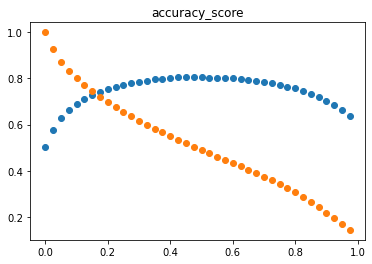

In [17]:
best_score, best_threshold = optimize_accuracy(_oof, list(train_set["state"]))
print(best_score, best_threshold)

In [18]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.8115004806431881 0.35000000000000003


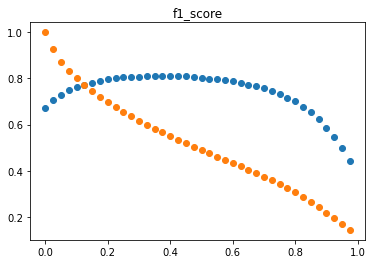

In [19]:
best_score, best_threshold = optimize_threshold(_oof, list(train_set["state"]))
print(best_score, best_threshold)
#0.8122529644268774 0.4 orginal
#0.8102929099370381 0.425 without agg
#0.810931899641577 0.4 with agg_svd64
#0.8107380140061052 0.4 with agg_svd16

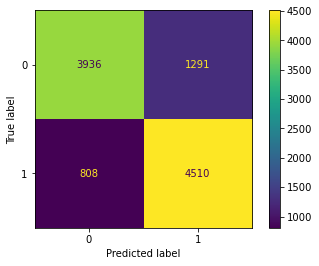

In [20]:
cm = confusion_matrix(list(train_set["state"]), np.where(_oof<0.4, 0, 1))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [21]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

def making_preds(preds1, preds2):
    preds1 += preds2
    preds1 /= 2
    #df = pd.DataFrame(columns=["id", "state"])
    #df["state"] = preds1
    #df["id"] = range(10545, 21089)
    return preds1

<AxesSubplot:>

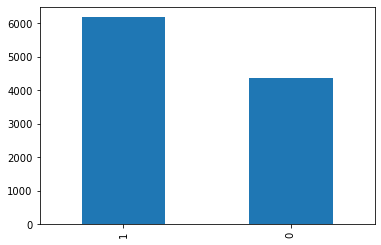

In [22]:
sub_file = making_sub(_preds, best_threshold)
sub_file.to_csv(f"./sub_files/optuna_lgbm_sub_{48}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")

In [23]:
config_dict = {
    "selected_feature": feature_cols,
    "out_of_fold": list(_oof),
    "prediction": list(_preds),
}

In [24]:
with open("data/lgbm_config_svd128_raw_2gram_agg_svd32.json", 'w') as f:
    json.dump(config_dict, f)